In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
import random
from ipdb import set_trace as st
from tqdm import tqdm

In [2]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde


In [3]:
import sys
sys.argv=['']
del sys

In [4]:
# construct the argument parser and parser the arguments
parser = argparse.ArgumentParser(description='VAE Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=200, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

torch.manual_seed(args.seed)

# we use CPU for computation
device = torch.device("cpu")

#K = 1024
K = 40

In [5]:
def gen_batch(BATCH_SIZE):
    theta = (np.pi/4) * torch.randint(0, 8, (BATCH_SIZE,)).float().to(device)
    centers = torch.stack((torch.cos(theta), torch.sin(theta)), dim = -1)
    noise = torch.randn_like(centers) * 0.1

    return centers + noise

def data_gen(BATCH_SIZE):
    #8 gaussians
    while 1:
        yield gen_batch(BATCH_SIZE)


In [6]:
test_loader = train_loader = data_gen(args.batch_size)

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, K)
        self.fc22 = nn.Linear(K, K)
        self.fc3 = nn.Linear(K, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x):
        h1 = F.selu(self.fc1(F.selu(self.fc0(x))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def sample(self, n=2048):
        """
        Generate n samples from the generative model.
        """
        sample = torch.randn(n, K).to(device)
        out = model.decode(sample)

        return out.cpu().detach().numpy()


    def decode(self, z):
        return self.fc5(F.selu(self.fc4(F.selu(self.fc3(z)))))

#    def decode(self, z):
#        h = F.relu(self.fc3(z))
#        mu = self.fc4(h)
#        logvar = self.fc5(h)
#        return mu, logvar

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu, logvar)
     #   mu_x, logvar_x = self.decode(z)
        return self.decode(z), mu, logvar



In [8]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose = True, threshold = 1E-2, eps=1e-6)

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 2), reduction='sum')
    L2 = torch.mean((recon_x-x)**2)
 
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 + KLD

Apply KernelDensity Estimation on recon_batch

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
   # train_100 = []
   # log_100 = []
 #   train_likli = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break #100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        recon_batch = recon_batch.detach().numpy()
       
        loss.backward()
     #   liklihood.backward()
        train_loss += loss.item()
     #   train_likli += liklihood.item()
        optimizer.step()
    train_loss /= 100
   # train_100.append(train_loss)
  #  train_likli /= 100
    scheduler.step(train_loss)


    samples_model = model.sample()
    samples_gt = gen_batch(2048)     
    kde_skl = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde_skl.fit(samples_gt)

    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(samples_model)
   # log_100.append(np.mean(log_pdf))

    print ("Epoch  average reconstruction error   :" ,epoch ,  train_loss )
    print (" likelihood  :", np.mean(log_pdf))
   # print (" likelihood  :", log_100)
    return train_loss, np.mean(log_pdf)


  0%|          | 0/200 [00:00<?, ?it/s]

Starting training....


  0%|          | 1/200 [00:21<1:11:23, 21.53s/it]

Epoch  average reconstruction error   : 1 0.6025810366868973
 likelihood  : -6.843324727624557


  1%|          | 2/200 [00:31<59:53, 18.15s/it]  

Epoch  average reconstruction error   : 2 0.4918522956967354
 likelihood  : -5.5811631283522205


  2%|▏         | 3/200 [00:38<48:22, 14.73s/it]

Epoch  average reconstruction error   : 3 0.47306586891412733
 likelihood  : -5.31989071497139


  2%|▏         | 4/200 [00:43<38:16, 11.72s/it]

Epoch  average reconstruction error   : 4 0.4631866797804832
 likelihood  : -4.90083662235437


  2%|▎         | 5/200 [00:47<31:09,  9.59s/it]

Epoch  average reconstruction error   : 5 0.43488260120153427
 likelihood  : -3.3257538047581043


  3%|▎         | 6/200 [00:53<26:54,  8.32s/it]

Epoch  average reconstruction error   : 6 0.40637035459280013
 likelihood  : -3.0353354264559993


  4%|▎         | 7/200 [00:57<23:17,  7.24s/it]

Epoch  average reconstruction error   : 7 0.4034860464930534
 likelihood  : -3.106573665512153


  4%|▍         | 8/200 [01:02<20:37,  6.44s/it]

Epoch  average reconstruction error   : 8 0.4003155308961868
 likelihood  : -2.9606916784560506


  4%|▍         | 9/200 [01:08<19:37,  6.17s/it]

Epoch  average reconstruction error   : 9 0.3972718274593353
 likelihood  : -2.8586963643036682


  5%|▌         | 10/200 [01:14<19:45,  6.24s/it]

Epoch  average reconstruction error   : 10 0.39636685758829115
 likelihood  : -2.827546440929315


  6%|▌         | 11/200 [01:20<19:22,  6.15s/it]

Epoch  average reconstruction error   : 11 0.39351062923669816
 likelihood  : -2.717658089673751


  6%|▌         | 12/200 [01:26<19:02,  6.08s/it]

Epoch  average reconstruction error   : 12 0.3851198342442512
 likelihood  : -2.5227400704638243


  6%|▋         | 13/200 [01:32<18:36,  5.97s/it]

Epoch  average reconstruction error   : 13 0.3782813596725464
 likelihood  : -2.465368364447271


  7%|▋         | 14/200 [01:37<18:14,  5.89s/it]

Epoch  average reconstruction error   : 14 0.3755060794949532
 likelihood  : -2.4603813179008593


  8%|▊         | 15/200 [01:45<20:05,  6.52s/it]

Epoch  average reconstruction error   : 15 0.374539420902729
 likelihood  : -2.361597601256091


  8%|▊         | 16/200 [01:51<19:45,  6.44s/it]

Epoch  average reconstruction error   : 16 0.3746777388453484
 likelihood  : -2.374144315120981


  8%|▊         | 17/200 [01:58<20:08,  6.60s/it]

Epoch  average reconstruction error   : 17 0.3727256029844284
 likelihood  : -2.2489333954129704


  9%|▉         | 18/200 [02:03<18:10,  5.99s/it]

Epoch  average reconstruction error   : 18 0.37255309760570526
 likelihood  : -2.274600359809072


 10%|▉         | 19/200 [02:08<16:52,  5.59s/it]

Epoch  average reconstruction error   : 19 0.371301543712616
 likelihood  : -2.2589438758914655


 10%|█         | 20/200 [02:14<17:10,  5.72s/it]

Epoch  average reconstruction error   : 20 0.37124091118574143
 likelihood  : -2.1680869660959603


 10%|█         | 21/200 [02:18<16:00,  5.36s/it]

Epoch  average reconstruction error   : 21 0.3713985642790794
 likelihood  : -2.107953110001784


 11%|█         | 22/200 [02:24<15:50,  5.34s/it]

Epoch  average reconstruction error   : 22 0.3702926164865494
 likelihood  : -2.1297780676117957


 12%|█▏        | 23/200 [02:29<15:45,  5.34s/it]

Epoch  average reconstruction error   : 23 0.3705421504378319
 likelihood  : -2.0376513434336756


 12%|█▏        | 24/200 [02:34<15:21,  5.23s/it]

Epoch  average reconstruction error   : 24 0.36950279027223587
 likelihood  : -2.1095759411207173


 12%|█▎        | 25/200 [02:39<14:47,  5.07s/it]

Epoch  average reconstruction error   : 25 0.36881472676992416
 likelihood  : -2.0615467296088252


 13%|█▎        | 26/200 [02:43<14:19,  4.94s/it]

Epoch  average reconstruction error   : 26 0.36922949880361555
 likelihood  : -2.021086958790121


 14%|█▎        | 27/200 [02:48<14:32,  5.04s/it]

Epoch  average reconstruction error   : 27 0.36970208674669264
 likelihood  : -1.970634981484062


 14%|█▍        | 28/200 [02:53<14:02,  4.90s/it]

Epoch  average reconstruction error   : 28 0.3691235488653183
 likelihood  : -1.9749183551830896


 14%|█▍        | 29/200 [02:58<13:40,  4.80s/it]

Epoch  average reconstruction error   : 29 0.3684946942329407
 likelihood  : -2.036271274424404


 15%|█▌        | 30/200 [03:04<14:40,  5.18s/it]

Epoch  average reconstruction error   : 30 0.3693035352230072
 likelihood  : -1.9935850847284544


 16%|█▌        | 31/200 [03:08<14:03,  4.99s/it]

Epoch  average reconstruction error   : 31 0.3681741645932198
 likelihood  : -1.9658637369222154


 16%|█▌        | 32/200 [03:13<13:37,  4.87s/it]

Epoch  average reconstruction error   : 32 0.3684951567649841
 likelihood  : -1.9834567507530787


 16%|█▋        | 33/200 [03:19<14:38,  5.26s/it]

Epoch  average reconstruction error   : 33 0.36902687460184097
 likelihood  : -1.9884675461361998


 17%|█▋        | 34/200 [03:23<13:57,  5.05s/it]

Epoch  average reconstruction error   : 34 0.3689547821879387
 likelihood  : -1.9844885127879361


 18%|█▊        | 35/200 [03:28<13:27,  4.89s/it]

Epoch  average reconstruction error   : 35 0.3685853612422943
 likelihood  : -1.979913478110225
Epoch    36: reducing learning rate of group 0 to 1.0000e-04.


 18%|█▊        | 36/200 [03:34<14:12,  5.20s/it]

Epoch  average reconstruction error   : 36 0.36851350277662276
 likelihood  : -1.9200379595823918


 18%|█▊        | 37/200 [03:43<16:56,  6.23s/it]

Epoch  average reconstruction error   : 37 0.36789225071668624
 likelihood  : -1.9367706373398672


 19%|█▉        | 38/200 [03:47<15:31,  5.75s/it]

Epoch  average reconstruction error   : 38 0.3679907405376434
 likelihood  : -1.9005971661239878


 20%|█▉        | 39/200 [03:52<14:39,  5.46s/it]

Epoch  average reconstruction error   : 39 0.3679739660024643
 likelihood  : -1.9214183424429936


 20%|██        | 40/200 [03:57<13:52,  5.20s/it]

Epoch  average reconstruction error   : 40 0.36827628821134567
 likelihood  : -1.9073959381228174


 20%|██        | 41/200 [04:01<13:17,  5.01s/it]

Epoch  average reconstruction error   : 41 0.3672530370950699
 likelihood  : -1.9460079910976082


 21%|██        | 42/200 [04:08<14:41,  5.58s/it]

Epoch  average reconstruction error   : 42 0.3685851657390595
 likelihood  : -1.9478759473955622


 22%|██▏       | 43/200 [04:13<13:45,  5.26s/it]

Epoch  average reconstruction error   : 43 0.36818487733602523
 likelihood  : -1.9227499633394878


 22%|██▏       | 44/200 [04:17<13:06,  5.04s/it]

Epoch  average reconstruction error   : 44 0.36733806014060977
 likelihood  : -1.9433861896785436


 22%|██▎       | 45/200 [04:24<14:25,  5.59s/it]

Epoch  average reconstruction error   : 45 0.36790374338626863
 likelihood  : -1.9258350883078514


 23%|██▎       | 46/200 [04:28<13:31,  5.27s/it]

Epoch  average reconstruction error   : 46 0.3679676276445389
 likelihood  : -1.8981564659546573
Epoch    47: reducing learning rate of group 0 to 1.0000e-05.


 24%|██▎       | 47/200 [04:33<12:51,  5.04s/it]

Epoch  average reconstruction error   : 47 0.3672456270456314
 likelihood  : -1.8938358675979035


 24%|██▍       | 48/200 [04:39<13:38,  5.39s/it]

Epoch  average reconstruction error   : 48 0.3673597499728203
 likelihood  : -1.883687939926025


 24%|██▍       | 49/200 [04:44<13:00,  5.17s/it]

Epoch  average reconstruction error   : 49 0.36797517448663714
 likelihood  : -1.8973516896370575


 25%|██▌       | 50/200 [04:49<12:43,  5.09s/it]

Epoch  average reconstruction error   : 50 0.36769002974033355
 likelihood  : -1.935259152406724


 26%|██▌       | 51/200 [04:55<13:20,  5.37s/it]

Epoch  average reconstruction error   : 51 0.36754376262426375
 likelihood  : -1.91866593679456


 26%|██▌       | 52/200 [04:59<12:39,  5.13s/it]

Epoch  average reconstruction error   : 52 0.36720957249403
 likelihood  : -1.9194794011025156


 26%|██▋       | 53/200 [05:04<12:07,  4.95s/it]

Epoch  average reconstruction error   : 53 0.36834173172712326
 likelihood  : -1.9117487534399187


 27%|██▋       | 54/200 [05:10<12:34,  5.16s/it]

Epoch  average reconstruction error   : 54 0.36789437860250473
 likelihood  : -1.9218934417010791


 28%|██▊       | 55/200 [05:14<12:02,  4.98s/it]

Epoch  average reconstruction error   : 55 0.3671388354897499
 likelihood  : -1.9064531070332262


 28%|██▊       | 56/200 [05:19<11:55,  4.97s/it]

Epoch  average reconstruction error   : 56 0.36705235034227374
 likelihood  : -1.9063486065819109


 28%|██▊       | 57/200 [05:24<11:46,  4.94s/it]

Epoch  average reconstruction error   : 57 0.36774798452854157
 likelihood  : -1.9259397544778976
Epoch    58: reducing learning rate of group 0 to 1.0000e-06.


 29%|██▉       | 58/200 [05:29<11:49,  5.00s/it]

Epoch  average reconstruction error   : 58 0.36653386741876604
 likelihood  : -1.938189871826908


 30%|██▉       | 59/200 [05:34<11:25,  4.86s/it]

Epoch  average reconstruction error   : 59 0.3672312182188034
 likelihood  : -1.8813355846937232


 30%|███       | 60/200 [05:38<11:09,  4.78s/it]

Epoch  average reconstruction error   : 60 0.36660322934389117
 likelihood  : -1.9280677932534318


 30%|███       | 61/200 [05:43<11:06,  4.79s/it]

Epoch  average reconstruction error   : 61 0.3681373617053032
 likelihood  : -1.9456269583051014


 31%|███       | 62/200 [05:48<10:52,  4.73s/it]

Epoch  average reconstruction error   : 62 0.3675608664751053
 likelihood  : -1.9065686180425165


 32%|███▏      | 63/200 [05:53<10:58,  4.81s/it]

Epoch  average reconstruction error   : 63 0.3680274814367294
 likelihood  : -1.917775148069559


 32%|███▏      | 64/200 [05:59<11:45,  5.19s/it]

Epoch  average reconstruction error   : 64 0.36726867854595185
 likelihood  : -1.866028892041693


 32%|███▎      | 65/200 [06:03<11:15,  5.00s/it]

Epoch  average reconstruction error   : 65 0.36802843064069746
 likelihood  : -1.9190087639320332


 33%|███▎      | 66/200 [06:09<11:56,  5.34s/it]

Epoch  average reconstruction error   : 66 0.36793233692646027
 likelihood  : -1.9289232502171463


 34%|███▎      | 67/200 [06:17<13:17,  5.99s/it]

Epoch  average reconstruction error   : 67 0.3676339966058731
 likelihood  : -1.8870621928790952


 34%|███▍      | 68/200 [06:22<12:25,  5.65s/it]

Epoch  average reconstruction error   : 68 0.3674639943242073
 likelihood  : -1.9408542052599


 34%|███▍      | 69/200 [06:28<12:53,  5.91s/it]

Epoch  average reconstruction error   : 69 0.3671945008635521
 likelihood  : -1.914274870229821


 35%|███▌      | 70/200 [06:36<14:00,  6.46s/it]

Epoch  average reconstruction error   : 70 0.3674836140871048
 likelihood  : -1.9167807210244456


 36%|███▌      | 71/200 [06:43<14:26,  6.72s/it]

Epoch  average reconstruction error   : 71 0.36801582753658296
 likelihood  : -1.9074772950272436


 36%|███▌      | 72/200 [06:49<13:24,  6.29s/it]

Epoch  average reconstruction error   : 72 0.3672815454006195
 likelihood  : -1.899393660140146


 36%|███▋      | 73/200 [06:58<15:30,  7.33s/it]

Epoch  average reconstruction error   : 73 0.36703715443611146
 likelihood  : -1.9099205916546795


 37%|███▋      | 74/200 [07:04<14:06,  6.71s/it]

Epoch  average reconstruction error   : 74 0.3677264961600304
 likelihood  : -1.9355906940729055


 38%|███▊      | 75/200 [07:09<13:16,  6.37s/it]

Epoch  average reconstruction error   : 75 0.3682695057988167
 likelihood  : -1.900970348402125


 38%|███▊      | 76/200 [07:15<12:47,  6.19s/it]

Epoch  average reconstruction error   : 76 0.3683836427330971
 likelihood  : -1.9173331321075038


 38%|███▊      | 77/200 [07:20<11:59,  5.85s/it]

Epoch  average reconstruction error   : 77 0.36726499646902083
 likelihood  : -1.9412376479433329


 39%|███▉      | 78/200 [07:26<11:44,  5.77s/it]

Epoch  average reconstruction error   : 78 0.3678983271121979
 likelihood  : -1.9087160085033015


 40%|███▉      | 79/200 [07:30<11:03,  5.49s/it]

Epoch  average reconstruction error   : 79 0.3670702588558197
 likelihood  : -1.9341889252298248


 40%|████      | 80/200 [07:38<12:28,  6.24s/it]

Epoch  average reconstruction error   : 80 0.3674483275413513
 likelihood  : -1.935175774353978


 40%|████      | 81/200 [07:46<13:06,  6.61s/it]

Epoch  average reconstruction error   : 81 0.3678013026714325
 likelihood  : -1.9213955380071523


 41%|████      | 82/200 [07:54<13:52,  7.05s/it]

Epoch  average reconstruction error   : 82 0.36768737107515337
 likelihood  : -1.9092578326362277


 42%|████▏     | 83/200 [08:00<13:23,  6.86s/it]

Epoch  average reconstruction error   : 83 0.3676543641090393
 likelihood  : -1.9113580842443596


 42%|████▏     | 84/200 [08:08<13:42,  7.09s/it]

Epoch  average reconstruction error   : 84 0.36759621143341065
 likelihood  : -1.9289343784092448


 42%|████▎     | 85/200 [08:13<12:08,  6.33s/it]

Epoch  average reconstruction error   : 85 0.3669870683550835
 likelihood  : -1.8349753187233526


 43%|████▎     | 86/200 [08:17<11:03,  5.82s/it]

Epoch  average reconstruction error   : 86 0.36771540135145186
 likelihood  : -1.9392594306591517


 44%|████▎     | 87/200 [08:24<11:43,  6.23s/it]

Epoch  average reconstruction error   : 87 0.36734737396240236
 likelihood  : -1.925939309811887


 44%|████▍     | 88/200 [08:29<10:42,  5.73s/it]

Epoch  average reconstruction error   : 88 0.36800687402486804
 likelihood  : -1.8943969752338683


 44%|████▍     | 89/200 [08:34<10:02,  5.43s/it]

Epoch  average reconstruction error   : 89 0.36797652155160904
 likelihood  : -1.9096594597608072


 45%|████▌     | 90/200 [08:39<09:41,  5.29s/it]

Epoch  average reconstruction error   : 90 0.3677945870161057
 likelihood  : -1.9084940413812754


 46%|████▌     | 91/200 [08:44<09:23,  5.17s/it]

Epoch  average reconstruction error   : 91 0.367767154276371
 likelihood  : -1.9216815061034993


 46%|████▌     | 92/200 [08:48<09:00,  5.00s/it]

Epoch  average reconstruction error   : 92 0.36730563163757324
 likelihood  : -1.956163226788542


 46%|████▋     | 93/200 [08:54<09:22,  5.26s/it]

Epoch  average reconstruction error   : 93 0.3672242206335068
 likelihood  : -1.9203014022570115


 47%|████▋     | 94/200 [08:59<08:56,  5.06s/it]

Epoch  average reconstruction error   : 94 0.3671718996763229
 likelihood  : -1.913230202925293


 48%|████▊     | 95/200 [09:04<09:08,  5.22s/it]

Epoch  average reconstruction error   : 95 0.36750540673732757
 likelihood  : -1.9433393546042186


 48%|████▊     | 96/200 [09:11<09:36,  5.54s/it]

Epoch  average reconstruction error   : 96 0.36789404809474946
 likelihood  : -1.934420254959882


 48%|████▊     | 97/200 [09:15<09:03,  5.28s/it]

Epoch  average reconstruction error   : 97 0.3670796945691109
 likelihood  : -1.897332658798363


 49%|████▉     | 98/200 [09:20<08:37,  5.07s/it]

Epoch  average reconstruction error   : 98 0.3682875177264214
 likelihood  : -1.9371271432990027


 50%|████▉     | 99/200 [09:25<08:43,  5.19s/it]

Epoch  average reconstruction error   : 99 0.36788457751274106
 likelihood  : -1.8988053813179977


 50%|█████     | 100/200 [09:30<08:20,  5.01s/it]

Epoch  average reconstruction error   : 100 0.3684796994924545
 likelihood  : -1.9403157000917313


 50%|█████     | 101/200 [09:34<08:02,  4.87s/it]

Epoch  average reconstruction error   : 101 0.3666409060359001
 likelihood  : -1.8963044110359761


 51%|█████     | 102/200 [09:39<07:48,  4.78s/it]

Epoch  average reconstruction error   : 102 0.3672670233249664
 likelihood  : -1.9562050291998478


 52%|█████▏    | 103/200 [09:44<07:43,  4.78s/it]

Epoch  average reconstruction error   : 103 0.3674387744069099
 likelihood  : -1.9197290889472456


 52%|█████▏    | 104/200 [09:48<07:33,  4.73s/it]

Epoch  average reconstruction error   : 104 0.3673219159245491
 likelihood  : -1.9610700980835274


 52%|█████▎    | 105/200 [09:53<07:24,  4.68s/it]

Epoch  average reconstruction error   : 105 0.3678845825791359
 likelihood  : -1.88713303850567


 53%|█████▎    | 106/200 [09:59<07:58,  5.09s/it]

Epoch  average reconstruction error   : 106 0.36804090172052384
 likelihood  : -1.9005302478235366


 54%|█████▎    | 107/200 [10:04<07:39,  4.94s/it]

Epoch  average reconstruction error   : 107 0.3669832113385201
 likelihood  : -1.9859658130292526


 54%|█████▍    | 108/200 [10:08<07:23,  4.82s/it]

Epoch  average reconstruction error   : 108 0.36764398247003555
 likelihood  : -1.9180565252392663


 55%|█████▍    | 109/200 [10:14<07:43,  5.09s/it]

Epoch  average reconstruction error   : 109 0.3674692928791046
 likelihood  : -1.9244039101447123


 55%|█████▌    | 110/200 [10:19<07:40,  5.11s/it]

Epoch  average reconstruction error   : 110 0.368048155605793
 likelihood  : -1.927730848737299


 56%|█████▌    | 111/200 [10:24<07:21,  4.96s/it]

Epoch  average reconstruction error   : 111 0.3683323559165001
 likelihood  : -1.8729473122920197


 56%|█████▌    | 112/200 [10:29<07:22,  5.03s/it]

Epoch  average reconstruction error   : 112 0.3679351431131363
 likelihood  : -1.861988063296491


 56%|█████▋    | 113/200 [10:33<07:08,  4.93s/it]

Epoch  average reconstruction error   : 113 0.36786928653717044
 likelihood  : -1.9479172218558753


 57%|█████▋    | 114/200 [10:38<06:53,  4.81s/it]

Epoch  average reconstruction error   : 114 0.36771194756031034
 likelihood  : -1.8648959079160945


 57%|█████▊    | 115/200 [10:43<06:44,  4.76s/it]

Epoch  average reconstruction error   : 115 0.3684205937385559
 likelihood  : -1.9053038353238316


 58%|█████▊    | 116/200 [10:47<06:42,  4.79s/it]

Epoch  average reconstruction error   : 116 0.367589516043663
 likelihood  : -1.9545257317028826


 58%|█████▊    | 117/200 [10:52<06:32,  4.73s/it]

Epoch  average reconstruction error   : 117 0.36819846272468565
 likelihood  : -1.925850553856916


 59%|█████▉    | 118/200 [10:57<06:22,  4.67s/it]

Epoch  average reconstruction error   : 118 0.3675880199670792
 likelihood  : -1.9227836740402107


 60%|█████▉    | 119/200 [11:03<06:56,  5.14s/it]

Epoch  average reconstruction error   : 119 0.3681361064314842
 likelihood  : -1.9780121643417496


 60%|██████    | 120/200 [11:11<07:55,  5.94s/it]

Epoch  average reconstruction error   : 120 0.3679082688689232
 likelihood  : -1.88959069698023


 60%|██████    | 121/200 [11:15<07:19,  5.56s/it]

Epoch  average reconstruction error   : 121 0.3674439984560013
 likelihood  : -1.9624497790037507


 61%|██████    | 122/200 [11:21<07:14,  5.57s/it]

Epoch  average reconstruction error   : 122 0.3677948078513145
 likelihood  : -1.9261714331030135


 62%|██████▏   | 123/200 [11:26<06:51,  5.34s/it]

Epoch  average reconstruction error   : 123 0.3675390601158142
 likelihood  : -1.9365867078216947


 62%|██████▏   | 124/200 [11:30<06:30,  5.13s/it]

Epoch  average reconstruction error   : 124 0.36744725197553635
 likelihood  : -1.8819192814890053


 62%|██████▎   | 125/200 [11:36<06:41,  5.36s/it]

Epoch  average reconstruction error   : 125 0.367310890853405
 likelihood  : -1.8766005880293166


 63%|██████▎   | 126/200 [11:41<06:19,  5.13s/it]

Epoch  average reconstruction error   : 126 0.36810117185115815
 likelihood  : -1.8991627416087584


 64%|██████▎   | 127/200 [11:45<06:02,  4.97s/it]

Epoch  average reconstruction error   : 127 0.3662732592225075
 likelihood  : -1.903636039629321


 64%|██████▍   | 128/200 [11:52<06:24,  5.34s/it]

Epoch  average reconstruction error   : 128 0.3678234758973122
 likelihood  : -1.9511304976927062


 64%|██████▍   | 129/200 [11:56<06:03,  5.12s/it]

Epoch  average reconstruction error   : 129 0.3672396796941757
 likelihood  : -1.9109699417284607


 65%|██████▌   | 130/200 [12:01<05:47,  4.96s/it]

Epoch  average reconstruction error   : 130 0.36691138744354246
 likelihood  : -1.955766505931394


 66%|██████▌   | 131/200 [12:07<06:11,  5.39s/it]

Epoch  average reconstruction error   : 131 0.3668826061487198
 likelihood  : -1.9016751391785787


 66%|██████▌   | 132/200 [12:12<05:50,  5.15s/it]

Epoch  average reconstruction error   : 132 0.3685541418194771
 likelihood  : -1.8847367048565715


 66%|██████▋   | 133/200 [12:16<05:32,  4.97s/it]

Epoch  average reconstruction error   : 133 0.36729620218276976
 likelihood  : -1.9369528532387255


 67%|██████▋   | 134/200 [12:22<05:50,  5.32s/it]

Epoch  average reconstruction error   : 134 0.36733446091413496
 likelihood  : -1.955254835644332


 68%|██████▊   | 135/200 [12:27<05:34,  5.14s/it]

Epoch  average reconstruction error   : 135 0.3685651674866676
 likelihood  : -1.9231146824467016


 68%|██████▊   | 136/200 [12:32<05:22,  5.03s/it]

Epoch  average reconstruction error   : 136 0.367080774307251
 likelihood  : -1.9045403996145116


 68%|██████▊   | 137/200 [12:38<05:27,  5.20s/it]

Epoch  average reconstruction error   : 137 0.3681533908843994
 likelihood  : -1.901938929290234


 69%|██████▉   | 138/200 [12:42<05:13,  5.05s/it]

Epoch  average reconstruction error   : 138 0.36810607761144637
 likelihood  : -1.903811098508075


 70%|██████▉   | 139/200 [12:47<04:58,  4.89s/it]

Epoch  average reconstruction error   : 139 0.36653166234493256
 likelihood  : -1.8736273425501184


 70%|███████   | 140/200 [12:51<04:48,  4.81s/it]

Epoch  average reconstruction error   : 140 0.36716364324092865
 likelihood  : -1.931302058742813


 70%|███████   | 141/200 [12:57<04:53,  4.98s/it]

Epoch  average reconstruction error   : 141 0.3671949505805969
 likelihood  : -1.8945646212210834


 71%|███████   | 142/200 [13:01<04:41,  4.86s/it]

Epoch  average reconstruction error   : 142 0.3676020294427872
 likelihood  : -1.9153607766384453


 72%|███████▏  | 143/200 [13:06<04:32,  4.78s/it]

Epoch  average reconstruction error   : 143 0.36775216370821
 likelihood  : -1.917679275271274


 72%|███████▏  | 144/200 [13:12<04:52,  5.23s/it]

Epoch  average reconstruction error   : 144 0.3668952488899231
 likelihood  : -1.8713408403464191


 72%|███████▎  | 145/200 [13:17<04:36,  5.03s/it]

Epoch  average reconstruction error   : 145 0.3678055426478386
 likelihood  : -1.9259263346258664


 73%|███████▎  | 146/200 [13:21<04:23,  4.89s/it]

Epoch  average reconstruction error   : 146 0.36785799264907837
 likelihood  : -1.9552558811314025


 74%|███████▎  | 147/200 [13:28<04:52,  5.53s/it]

Epoch  average reconstruction error   : 147 0.366909776031971
 likelihood  : -1.9308144022185036


 74%|███████▍  | 148/200 [13:34<04:40,  5.40s/it]

Epoch  average reconstruction error   : 148 0.3670568111538887
 likelihood  : -1.889249874637534


 74%|███████▍  | 149/200 [13:42<05:21,  6.31s/it]

Epoch  average reconstruction error   : 149 0.36793549835681916
 likelihood  : -1.9449358957220788


 75%|███████▌  | 150/200 [13:48<05:16,  6.33s/it]

Epoch  average reconstruction error   : 150 0.3680301868915558
 likelihood  : -1.9302936538788722


 76%|███████▌  | 151/200 [13:53<04:43,  5.78s/it]

Epoch  average reconstruction error   : 151 0.3685161617398262
 likelihood  : -1.8923254912512395


 76%|███████▌  | 152/200 [13:59<04:41,  5.87s/it]

Epoch  average reconstruction error   : 152 0.3680268007516861
 likelihood  : -1.9069512600120397


 76%|███████▋  | 153/200 [14:03<04:16,  5.47s/it]

Epoch  average reconstruction error   : 153 0.3674119421839714
 likelihood  : -1.955940225547224


 77%|███████▋  | 154/200 [14:08<03:58,  5.18s/it]

Epoch  average reconstruction error   : 154 0.36735503524541857
 likelihood  : -1.8775665190726607


 78%|███████▊  | 155/200 [14:13<03:56,  5.25s/it]

Epoch  average reconstruction error   : 155 0.3676405540108681
 likelihood  : -1.915353208029604


 78%|███████▊  | 156/200 [14:18<03:42,  5.05s/it]

Epoch  average reconstruction error   : 156 0.3670601472258568
 likelihood  : -1.9502506079148778


 78%|███████▊  | 157/200 [14:23<03:31,  4.91s/it]

Epoch  average reconstruction error   : 157 0.3679381674528122
 likelihood  : -1.9446609369653154


 79%|███████▉  | 158/200 [14:27<03:22,  4.83s/it]

Epoch  average reconstruction error   : 158 0.367612729370594
 likelihood  : -1.8921027068812242


 80%|███████▉  | 159/200 [14:32<03:17,  4.80s/it]

Epoch  average reconstruction error   : 159 0.367332444190979
 likelihood  : -1.8685640551861629


 80%|████████  | 160/200 [14:36<03:09,  4.73s/it]

Epoch  average reconstruction error   : 160 0.3667597824335098
 likelihood  : -1.9248209892961108


 80%|████████  | 161/200 [14:41<03:07,  4.82s/it]

Epoch  average reconstruction error   : 161 0.3673914983868599
 likelihood  : -1.9699492611810996


 81%|████████  | 162/200 [14:47<03:16,  5.17s/it]

Epoch  average reconstruction error   : 162 0.3677336144447327
 likelihood  : -1.8939418847409664


 82%|████████▏ | 163/200 [14:52<03:04,  4.98s/it]

Epoch  average reconstruction error   : 163 0.3677362290024757
 likelihood  : -1.8849103940978809


 82%|████████▏ | 164/200 [14:57<02:54,  4.85s/it]

Epoch  average reconstruction error   : 164 0.36723980396986006
 likelihood  : -1.9344950504570355


 82%|████████▎ | 165/200 [15:03<03:02,  5.21s/it]

Epoch  average reconstruction error   : 165 0.3675845256447792
 likelihood  : -1.906527852435625


 83%|████████▎ | 166/200 [15:07<02:50,  5.00s/it]

Epoch  average reconstruction error   : 166 0.367407468855381
 likelihood  : -1.9295900871702585


 84%|████████▎ | 167/200 [15:12<02:41,  4.88s/it]

Epoch  average reconstruction error   : 167 0.36679439097642896
 likelihood  : -1.9535335564930423


 84%|████████▍ | 168/200 [15:17<02:39,  4.97s/it]

Epoch  average reconstruction error   : 168 0.36700177311897275
 likelihood  : -1.8934114150155619


 84%|████████▍ | 169/200 [15:22<02:31,  4.90s/it]

Epoch  average reconstruction error   : 169 0.3688188222050667
 likelihood  : -1.9624966814792937


 85%|████████▌ | 170/200 [15:26<02:24,  4.82s/it]

Epoch  average reconstruction error   : 170 0.36759197622537615
 likelihood  : -1.8749374794730738


 86%|████████▌ | 171/200 [15:31<02:20,  4.84s/it]

Epoch  average reconstruction error   : 171 0.3687757414579391
 likelihood  : -1.9154540988759918


 86%|████████▌ | 172/200 [15:36<02:16,  4.89s/it]

Epoch  average reconstruction error   : 172 0.36756340086460115
 likelihood  : -1.9681097453846048


 86%|████████▋ | 173/200 [15:41<02:11,  4.86s/it]

Epoch  average reconstruction error   : 173 0.36757606983184815
 likelihood  : -1.9375627362264767


 87%|████████▋ | 174/200 [15:46<02:10,  5.03s/it]

Epoch  average reconstruction error   : 174 0.3672973451018333
 likelihood  : -1.918895824339871


 88%|████████▊ | 175/200 [15:53<02:14,  5.37s/it]

Epoch  average reconstruction error   : 175 0.36751803517341614
 likelihood  : -1.9221658576710268


 88%|████████▊ | 176/200 [15:57<02:03,  5.13s/it]

Epoch  average reconstruction error   : 176 0.36734733492136
 likelihood  : -1.9017120707034816


 88%|████████▊ | 177/200 [16:02<01:53,  4.95s/it]

Epoch  average reconstruction error   : 177 0.36683078825473786
 likelihood  : -1.9735579287087281


 89%|████████▉ | 178/200 [16:09<02:05,  5.71s/it]

Epoch  average reconstruction error   : 178 0.3678737139701843
 likelihood  : -1.8916409371728533


 90%|████████▉ | 179/200 [16:15<01:58,  5.66s/it]

Epoch  average reconstruction error   : 179 0.3678970018029213
 likelihood  : -1.9315584261118883


 90%|█████████ | 180/200 [16:20<01:49,  5.50s/it]

Epoch  average reconstruction error   : 180 0.36724568843841554
 likelihood  : -1.9024609778529133


 90%|█████████ | 181/200 [16:25<01:42,  5.40s/it]

Epoch  average reconstruction error   : 181 0.36824296981096266
 likelihood  : -1.9317190477240658


 91%|█████████ | 182/200 [16:30<01:32,  5.16s/it]

Epoch  average reconstruction error   : 182 0.36800200045108794
 likelihood  : -1.898421804426006


 92%|█████████▏| 183/200 [16:34<01:24,  4.97s/it]

Epoch  average reconstruction error   : 183 0.36684439539909364
 likelihood  : -1.9153813324848774


 92%|█████████▏| 184/200 [16:40<01:26,  5.40s/it]

Epoch  average reconstruction error   : 184 0.36740426540374754
 likelihood  : -1.9102281336621094


 92%|█████████▎| 185/200 [16:45<01:17,  5.14s/it]

Epoch  average reconstruction error   : 185 0.36742805033922193
 likelihood  : -1.9061723035876932


 93%|█████████▎| 186/200 [16:50<01:09,  5.00s/it]

Epoch  average reconstruction error   : 186 0.3672257715463638
 likelihood  : -1.922448591589799


 94%|█████████▎| 187/200 [16:57<01:14,  5.71s/it]

Epoch  average reconstruction error   : 187 0.36719425350427626
 likelihood  : -1.9355345234708923


 94%|█████████▍| 188/200 [17:02<01:04,  5.37s/it]

Epoch  average reconstruction error   : 188 0.3683990740776062
 likelihood  : -1.8951434785781514


 94%|█████████▍| 189/200 [17:06<00:56,  5.14s/it]

Epoch  average reconstruction error   : 189 0.3676273646950722
 likelihood  : -1.9415067056597821


 95%|█████████▌| 190/200 [17:12<00:54,  5.41s/it]

Epoch  average reconstruction error   : 190 0.3675175401568413
 likelihood  : -1.920860984606365


 96%|█████████▌| 191/200 [17:17<00:46,  5.16s/it]

Epoch  average reconstruction error   : 191 0.3677235043048859
 likelihood  : -1.9050291046873058


 96%|█████████▌| 192/200 [17:21<00:39,  5.00s/it]

Epoch  average reconstruction error   : 192 0.3678265452384949
 likelihood  : -1.8888558525596717


 96%|█████████▋| 193/200 [17:29<00:40,  5.74s/it]

Epoch  average reconstruction error   : 193 0.36821991086006167
 likelihood  : -1.9113192905926308


 97%|█████████▋| 194/200 [17:33<00:32,  5.38s/it]

Epoch  average reconstruction error   : 194 0.36713870406150817
 likelihood  : -1.9861579930625433


 98%|█████████▊| 195/200 [17:38<00:25,  5.13s/it]

Epoch  average reconstruction error   : 195 0.36759300619363783
 likelihood  : -1.9033944446195448


 98%|█████████▊| 196/200 [17:44<00:21,  5.43s/it]

Epoch  average reconstruction error   : 196 0.3679438617825508
 likelihood  : -1.9459584760166484


 98%|█████████▊| 197/200 [17:49<00:15,  5.17s/it]

Epoch  average reconstruction error   : 197 0.36763758927583695
 likelihood  : -1.9311970324207401


 99%|█████████▉| 198/200 [17:53<00:09,  4.98s/it]

Epoch  average reconstruction error   : 198 0.3677093631029129
 likelihood  : -1.9790549995207463


100%|█████████▉| 199/200 [17:59<00:05,  5.35s/it]

Epoch  average reconstruction error   : 199 0.3680696216225624
 likelihood  : -1.8914136955343759


100%|██████████| 200/200 [18:04<00:00,  5.42s/it]

Epoch  average reconstruction error   : 200 0.3675889241695404
 likelihood  : -1.9555788471865683
train1 [0.6025810366868973, 0.4918522956967354, 0.47306586891412733, 0.4631866797804832, 0.43488260120153427, 0.40637035459280013, 0.4034860464930534, 0.4003155308961868, 0.3972718274593353, 0.39636685758829115, 0.39351062923669816, 0.3851198342442512, 0.3782813596725464, 0.3755060794949532, 0.374539420902729, 0.3746777388453484, 0.3727256029844284, 0.37255309760570526, 0.371301543712616, 0.37124091118574143, 0.3713985642790794, 0.3702926164865494, 0.3705421504378319, 0.36950279027223587, 0.36881472676992416, 0.36922949880361555, 0.36970208674669264, 0.3691235488653183, 0.3684946942329407, 0.3693035352230072, 0.3681741645932198, 0.3684951567649841, 0.36902687460184097, 0.3689547821879387, 0.3685853612422943, 0.36851350277662276, 0.36789225071668624, 0.3679907405376434, 0.3679739660024643, 0.36827628821134567, 0.3672530370950699, 0.3685851657390595, 0.36818487733602523, 0.36733806014060977,


__main__:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


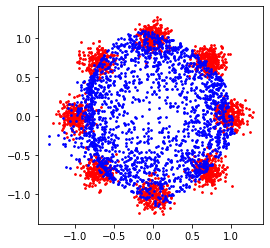

In [11]:
# k = 5, epoch 200
if __name__ == "__main__":
    print("Starting training....")
    train_5 = []
    log_5 = []
    
    for epoch in tqdm(range(1, args.epochs + 1)):
      #  train(epoch)
        a,b= train(epoch)
        train_5.append(a)
        log_5.append(b)
        
  
    print("train1", train_5, log_5)


    gt = next(train_loader)
        
    with torch.no_grad():
        #sample = torch.randn(2048, K).to(device)
        #out = model.decode(sample).cpu().numpy()
        out1 = model.sample()
        recon = model(gt)[0].cpu().numpy()

    rx,ry = recon[:,0], recon[:,1]
        
    gt = gt.cpu().numpy()
    gx, gy = gt[:,0], gt[:,1]
        
    xs, ys = out1[:,0], out1[:,1]

    plt.scatter(gx, gy, c = 'red', s=3)
    plt.scatter(xs, ys, c = 'blue', s=3)
    plt.axes().set_aspect('equal')
    plt.show()
    
#    st()

In [11]:
train_5 = [0.6025810366868973, 0.4918522956967354, 0.47306586891412733, 0.4631866797804832, 0.43488260120153427, 0.40637035459280013, 0.4034860464930534, 0.4003155308961868, 0.3972718274593353, 0.39636685758829115, 0.39351062923669816, 0.3851198342442512, 0.3782813596725464, 0.3755060794949532, 0.374539420902729, 0.3746777388453484, 0.3727256029844284, 0.37255309760570526, 0.371301543712616, 0.37124091118574143, 0.3713985642790794, 0.3702926164865494, 0.3705421504378319, 0.36950279027223587, 0.36881472676992416, 0.36922949880361555, 0.36970208674669264, 0.3691235488653183, 0.3684946942329407, 0.3693035352230072, 0.3681741645932198, 0.3684951567649841, 0.36902687460184097, 0.3689547821879387, 0.3685853612422943, 0.36851350277662276, 0.36789225071668624, 0.3679907405376434, 0.3679739660024643, 0.36827628821134567, 0.3672530370950699, 0.3685851657390595, 0.36818487733602523, 0.36733806014060977, 0.36790374338626863, 0.3679676276445389, 0.3672456270456314, 0.3673597499728203, 0.36797517448663714, 0.36769002974033355, 0.36754376262426375, 0.36720957249403, 0.36834173172712326, 0.36789437860250473, 0.3671388354897499, 0.36705235034227374, 0.36774798452854157, 0.36653386741876604, 0.3672312182188034, 0.36660322934389117, 0.3681373617053032, 0.3675608664751053, 0.3680274814367294, 0.36726867854595185, 0.36802843064069746, 0.36793233692646027, 0.3676339966058731, 0.3674639943242073, 0.3671945008635521, 0.3674836140871048, 0.36801582753658296, 0.3672815454006195, 0.36703715443611146, 0.3677264961600304, 0.3682695057988167, 0.3683836427330971, 0.36726499646902083, 0.3678983271121979, 0.3670702588558197, 0.3674483275413513, 0.3678013026714325, 0.36768737107515337, 0.3676543641090393, 0.36759621143341065, 0.3669870683550835, 0.36771540135145186, 0.36734737396240236, 0.36800687402486804, 0.36797652155160904, 0.3677945870161057, 0.367767154276371, 0.36730563163757324, 0.3672242206335068, 0.3671718996763229, 0.36750540673732757, 0.36789404809474946, 0.3670796945691109, 0.3682875177264214, 0.36788457751274106, 0.3684796994924545, 0.3666409060359001, 0.3672670233249664, 0.3674387744069099, 0.3673219159245491, 0.3678845825791359, 0.36804090172052384, 0.3669832113385201, 0.36764398247003555, 0.3674692928791046, 0.368048155605793, 0.3683323559165001, 0.3679351431131363, 0.36786928653717044, 0.36771194756031034, 0.3684205937385559, 0.367589516043663, 0.36819846272468565, 0.3675880199670792, 0.3681361064314842, 0.3679082688689232, 0.3674439984560013, 0.3677948078513145, 0.3675390601158142, 0.36744725197553635, 0.367310890853405, 0.36810117185115815, 0.3662732592225075, 0.3678234758973122, 0.3672396796941757, 0.36691138744354246, 0.3668826061487198, 0.3685541418194771, 0.36729620218276976, 0.36733446091413496, 0.3685651674866676, 0.367080774307251, 0.3681533908843994, 0.36810607761144637, 0.36653166234493256, 0.36716364324092865, 0.3671949505805969, 0.3676020294427872, 0.36775216370821, 0.3668952488899231, 0.3678055426478386, 0.36785799264907837, 0.366909776031971, 0.3670568111538887, 0.36793549835681916, 0.3680301868915558, 0.3685161617398262, 0.3680268007516861, 0.3674119421839714, 0.36735503524541857, 0.3676405540108681, 0.3670601472258568, 0.3679381674528122, 0.367612729370594, 0.367332444190979, 0.3667597824335098, 0.3673914983868599, 0.3677336144447327, 0.3677362290024757, 0.36723980396986006, 0.3675845256447792, 0.367407468855381, 0.36679439097642896, 0.36700177311897275, 0.3688188222050667, 0.36759197622537615, 0.3687757414579391, 0.36756340086460115, 0.36757606983184815, 0.3672973451018333, 0.36751803517341614, 0.36734733492136, 0.36683078825473786, 0.3678737139701843, 0.3678970018029213, 0.36724568843841554, 0.36824296981096266, 0.36800200045108794, 0.36684439539909364, 0.36740426540374754, 0.36742805033922193, 0.3672257715463638, 0.36719425350427626, 0.3683990740776062, 0.3676273646950722, 0.3675175401568413, 0.3677235043048859, 0.3678265452384949, 0.36821991086006167, 0.36713870406150817, 0.36759300619363783, 0.3679438617825508, 0.36763758927583695, 0.3677093631029129, 0.3680696216225624, 0.3675889241695404]

In [12]:
train_25 = [0.3666409060359001, 0.3672670233249664, 0.3674387744069099, 0.3673219159245491, 0.3678845825791359, 0.36804090172052384, 0.3669832113385201, 0.36764398247003555, 0.3674692928791046, 0.368048155605793, 0.3683323559165001, 0.3679351431131363, 0.36786928653717044, 0.36771194756031034, 0.3684205937385559, 0.367589516043663, 0.36819846272468565, 0.3675880199670792, 0.3681361064314842, 0.3679082688689232, 0.3674439984560013, 0.3677948078513145, 0.3675390601158142, 0.36744725197553635, 0.367310890853405, 0.36810117185115815, 0.3662732592225075, 0.3678234758973122, 0.3672396796941757, 0.36691138744354246, 0.3668826061487198, 0.3685541418194771, 0.36729620218276976, 0.36733446091413496, 0.3685651674866676, 0.367080774307251, 0.3681533908843994, 0.36810607761144637, 0.36653166234493256, 0.36716364324092865, 0.3671949505805969, 0.3676020294427872, 0.36775216370821, 0.3668952488899231, 0.3678055426478386, 0.36785799264907837, 0.366909776031971, 0.3670568111538887, 0.36793549835681916, 0.3680301868915558, 0.3685161617398262, 0.3680268007516861, 0.3674119421839714, 0.36735503524541857, 0.3676405540108681, 0.3670601472258568, 0.3679381674528122, 0.367612729370594, 0.367332444190979, 0.3667597824335098, 0.3673914983868599, 0.3677336144447327, 0.3677362290024757, 0.36723980396986006, 0.3675845256447792, 0.367407468855381, 0.36679439097642896, 0.36700177311897275, 0.3688188222050667, 0.36759197622537615, 0.3687757414579391, 0.36756340086460115, 0.36757606983184815, 0.3672973451018333, 0.36751803517341614, 0.36734733492136, 0.36683078825473786, 0.3678737139701843, 0.3678970018029213, 0.36724568843841554, 0.36824296981096266, 0.36800200045108794, 0.36684439539909364, 0.36740426540374754, 0.36742805033922193, 0.3672257715463638, 0.36719425350427626, 0.3683990740776062, 0.3676273646950722, 0.3675175401568413, 0.3677235043048859, 0.3678265452384949, 0.36821991086006167, 0.36713870406150817, 0.36759300619363783, 0.3679438617825508, 0.36763758927583695, 0.3677093631029129, 0.3680696216225624, 0.3675889241695404]

In [13]:
train5= np.mean(train_25)

In [14]:
log_5 = [-6.843324727624557, -5.5811631283522205, -5.31989071497139, -4.90083662235437, -3.3257538047581043, -3.0353354264559993, -3.106573665512153, -2.9606916784560506, -2.8586963643036682, -2.827546440929315, -2.717658089673751, -2.5227400704638243, -2.465368364447271, -2.4603813179008593, -2.361597601256091, -2.374144315120981, -2.2489333954129704, -2.274600359809072, -2.2589438758914655, -2.1680869660959603, -2.107953110001784, -2.1297780676117957, -2.0376513434336756, -2.1095759411207173, -2.0615467296088252, -2.021086958790121, -1.970634981484062, -1.9749183551830896, -2.036271274424404, -1.9935850847284544, -1.9658637369222154, -1.9834567507530787, -1.9884675461361998, -1.9844885127879361, -1.979913478110225, -1.9200379595823918, -1.9367706373398672, -1.9005971661239878, -1.9214183424429936, -1.9073959381228174, -1.9460079910976082, -1.9478759473955622, -1.9227499633394878, -1.9433861896785436, -1.9258350883078514, -1.8981564659546573, -1.8938358675979035, -1.883687939926025, -1.8973516896370575, -1.935259152406724, -1.91866593679456, -1.9194794011025156, -1.9117487534399187, -1.9218934417010791, -1.9064531070332262, -1.9063486065819109, -1.9259397544778976, -1.938189871826908, -1.8813355846937232, -1.9280677932534318, -1.9456269583051014, -1.9065686180425165, -1.917775148069559, -1.866028892041693, -1.9190087639320332, -1.9289232502171463, -1.8870621928790952, -1.9408542052599, -1.914274870229821, -1.9167807210244456, -1.9074772950272436, -1.899393660140146, -1.9099205916546795, -1.9355906940729055, -1.900970348402125, -1.9173331321075038, -1.9412376479433329, -1.9087160085033015, -1.9341889252298248, -1.935175774353978, -1.9213955380071523, -1.9092578326362277, -1.9113580842443596, -1.9289343784092448, -1.8349753187233526, -1.9392594306591517, -1.925939309811887, -1.8943969752338683, -1.9096594597608072, -1.9084940413812754, -1.9216815061034993, -1.956163226788542, -1.9203014022570115, -1.913230202925293, -1.9433393546042186, -1.934420254959882, -1.897332658798363, -1.9371271432990027, -1.8988053813179977, -1.9403157000917313, -1.8963044110359761, -1.9562050291998478, -1.9197290889472456, -1.9610700980835274, -1.88713303850567, -1.9005302478235366, -1.9859658130292526, -1.9180565252392663, -1.9244039101447123, -1.927730848737299, -1.8729473122920197, -1.861988063296491, -1.9479172218558753, -1.8648959079160945, -1.9053038353238316, -1.9545257317028826, -1.925850553856916, -1.9227836740402107, -1.9780121643417496, -1.88959069698023, -1.9624497790037507, -1.9261714331030135, -1.9365867078216947, -1.8819192814890053, -1.8766005880293166, -1.8991627416087584, -1.903636039629321, -1.9511304976927062, -1.9109699417284607, -1.955766505931394, -1.9016751391785787, -1.8847367048565715, -1.9369528532387255, -1.955254835644332, -1.9231146824467016, -1.9045403996145116, -1.901938929290234, -1.903811098508075, -1.8736273425501184, -1.931302058742813, -1.8945646212210834, -1.9153607766384453, -1.917679275271274, -1.8713408403464191, -1.9259263346258664, -1.9552558811314025, -1.9308144022185036, -1.889249874637534, -1.9449358957220788, -1.9302936538788722, -1.8923254912512395, -1.9069512600120397, -1.955940225547224, -1.8775665190726607, -1.915353208029604, -1.9502506079148778, -1.9446609369653154, -1.8921027068812242, -1.8685640551861629, -1.9248209892961108, -1.9699492611810996, -1.8939418847409664, -1.8849103940978809, -1.9344950504570355, -1.906527852435625, -1.9295900871702585, -1.9535335564930423, -1.8934114150155619, -1.9624966814792937, -1.8749374794730738, -1.9154540988759918, -1.9681097453846048, -1.9375627362264767, -1.918895824339871, -1.9221658576710268, -1.9017120707034816, -1.9735579287087281, -1.8916409371728533, -1.9315584261118883, -1.9024609778529133, -1.9317190477240658, -1.898421804426006, -1.9153813324848774, -1.9102281336621094, -1.9061723035876932, -1.922448591589799, -1.9355345234708923, -1.8951434785781514, -1.9415067056597821, -1.920860984606365, -1.9050291046873058, -1.8888558525596717, -1.9113192905926308, -1.9861579930625433, -1.9033944446195448, -1.9459584760166484, -1.9311970324207401, -1.9790549995207463, -1.8914136955343759, -1.9555788471865683]

In [15]:
log_25 = [-1.8963044110359761, -1.9562050291998478, -1.9197290889472456, -1.9610700980835274, -1.88713303850567, -1.9005302478235366, -1.9859658130292526, -1.9180565252392663, -1.9244039101447123, -1.927730848737299, -1.8729473122920197, -1.861988063296491, -1.9479172218558753, -1.8648959079160945, -1.9053038353238316, -1.9545257317028826, -1.925850553856916, -1.9227836740402107, -1.9780121643417496, -1.88959069698023, -1.9624497790037507, -1.9261714331030135, -1.9365867078216947, -1.8819192814890053, -1.8766005880293166, -1.8991627416087584, -1.903636039629321, -1.9511304976927062, -1.9109699417284607, -1.955766505931394, -1.9016751391785787, -1.8847367048565715, -1.9369528532387255, -1.955254835644332, -1.9231146824467016, -1.9045403996145116, -1.901938929290234, -1.903811098508075, -1.8736273425501184, -1.931302058742813, -1.8945646212210834, -1.9153607766384453, -1.917679275271274, -1.8713408403464191, -1.9259263346258664, -1.9552558811314025, -1.9308144022185036, -1.889249874637534, -1.9449358957220788, -1.9302936538788722, -1.8923254912512395, -1.9069512600120397, -1.955940225547224, -1.8775665190726607, -1.915353208029604, -1.9502506079148778, -1.9446609369653154, -1.8921027068812242, -1.8685640551861629, -1.9248209892961108, -1.9699492611810996, -1.8939418847409664, -1.8849103940978809, -1.9344950504570355, -1.906527852435625, -1.9295900871702585, -1.9535335564930423, -1.8934114150155619, -1.9624966814792937, -1.8749374794730738, -1.9154540988759918, -1.9681097453846048, -1.9375627362264767, -1.918895824339871, -1.9221658576710268, -1.9017120707034816, -1.9735579287087281, -1.8916409371728533, -1.9315584261118883, -1.9024609778529133, -1.9317190477240658, -1.898421804426006, -1.9153813324848774, -1.9102281336621094, -1.9061723035876932, -1.922448591589799, -1.9355345234708923, -1.8951434785781514, -1.9415067056597821, -1.920860984606365, -1.9050291046873058, -1.8888558525596717, -1.9113192905926308, -1.9861579930625433, -1.9033944446195448, -1.9459584760166484, -1.9311970324207401, -1.9790549995207463, -1.8914136955343759, -1.9555788471865683]

In [16]:
log5= np.mean(log_25)

  0%|          | 0/200 [00:00<?, ?it/s]

Starting training....


  0%|          | 1/200 [00:10<35:01, 10.56s/it]

Epoch  average reconstruction error   : 1 0.3462608015537262
 likelihood  : -3.1071118162663627


  1%|          | 2/200 [00:19<33:02, 10.01s/it]

Epoch  average reconstruction error   : 2 0.29327857613563535
 likelihood  : -2.8015619691174205


  2%|▏         | 3/200 [00:25<28:40,  8.73s/it]

Epoch  average reconstruction error   : 3 0.27696271777153014
 likelihood  : -2.68619444314269


  2%|▏         | 4/200 [00:31<25:50,  7.91s/it]

Epoch  average reconstruction error   : 4 0.2610496427118778
 likelihood  : -2.466577561909766


  2%|▎         | 5/200 [00:37<23:57,  7.37s/it]

Epoch  average reconstruction error   : 5 0.25164763629436493
 likelihood  : -2.3755620613055575


  3%|▎         | 6/200 [00:42<22:16,  6.89s/it]

Epoch  average reconstruction error   : 6 0.24957043603062629
 likelihood  : -2.3462097518058043


  4%|▎         | 7/200 [00:51<23:25,  7.28s/it]

Epoch  average reconstruction error   : 7 0.24822999581694602
 likelihood  : -2.2884687300309308


  4%|▍         | 8/200 [00:56<21:49,  6.82s/it]

Epoch  average reconstruction error   : 8 0.24667362347245217
 likelihood  : -2.208594896980684


  4%|▍         | 9/200 [01:02<20:44,  6.51s/it]

Epoch  average reconstruction error   : 9 0.24582475617527963
 likelihood  : -2.175520095967312


  5%|▌         | 10/200 [01:10<21:56,  6.93s/it]

Epoch  average reconstruction error   : 10 0.24513932585716247
 likelihood  : -2.2068190321820738


  6%|▌         | 11/200 [01:16<20:42,  6.57s/it]

Epoch  average reconstruction error   : 11 0.2441394481062889
 likelihood  : -2.0410515974329684


  6%|▌         | 12/200 [01:25<22:47,  7.28s/it]

Epoch  average reconstruction error   : 12 0.24299986630678178
 likelihood  : -1.9954941092766778


  6%|▋         | 13/200 [01:30<21:13,  6.81s/it]

Epoch  average reconstruction error   : 13 0.24237348675727843
 likelihood  : -1.9694546198058631


  7%|▋         | 14/200 [01:39<22:23,  7.22s/it]

Epoch  average reconstruction error   : 14 0.24132728919386864
 likelihood  : -1.870443183736969


  8%|▊         | 15/200 [01:44<20:54,  6.78s/it]

Epoch  average reconstruction error   : 15 0.24070996552705765
 likelihood  : -1.7990540727755318


  8%|▊         | 16/200 [01:50<19:59,  6.52s/it]

Epoch  average reconstruction error   : 16 0.23956415489315985
 likelihood  : -1.8198353692219427


  8%|▊         | 17/200 [02:05<27:21,  8.97s/it]

Epoch  average reconstruction error   : 17 0.23917783215641975
 likelihood  : -1.7337396926314206


  9%|▉         | 18/200 [02:13<26:27,  8.72s/it]

Epoch  average reconstruction error   : 18 0.23873774126172065
 likelihood  : -1.7309592994981262


 10%|▉         | 19/200 [02:19<24:00,  7.96s/it]

Epoch  average reconstruction error   : 19 0.2377087165415287
 likelihood  : -1.705294047055987


 10%|█         | 20/200 [02:28<24:31,  8.18s/it]

Epoch  average reconstruction error   : 20 0.23828084543347358
 likelihood  : -1.6952038950186852


 10%|█         | 21/200 [02:34<22:28,  7.53s/it]

Epoch  average reconstruction error   : 21 0.23764635026454925
 likelihood  : -1.644611255577425


 11%|█         | 22/200 [02:42<22:55,  7.73s/it]

Epoch  average reconstruction error   : 22 0.23759534269571303
 likelihood  : -1.6159923296201577


 12%|█▏        | 23/200 [02:48<20:59,  7.11s/it]

Epoch  average reconstruction error   : 23 0.23785562112927436
 likelihood  : -1.5633045874296247


 12%|█▏        | 24/200 [02:54<19:42,  6.72s/it]

Epoch  average reconstruction error   : 24 0.23738096818327903
 likelihood  : -1.585449230346974


 12%|█▎        | 25/200 [03:02<20:59,  7.20s/it]

Epoch  average reconstruction error   : 25 0.2373053702712059
 likelihood  : -1.5862811396408047


 13%|█▎        | 26/200 [03:08<19:31,  6.73s/it]

Epoch  average reconstruction error   : 26 0.23674861907958986
 likelihood  : -1.6085189757006326


 14%|█▎        | 27/200 [03:16<20:38,  7.16s/it]

Epoch  average reconstruction error   : 27 0.23700593739748002
 likelihood  : -1.563264368554937


 14%|█▍        | 28/200 [03:21<19:14,  6.71s/it]

Epoch  average reconstruction error   : 28 0.23672787249088287
 likelihood  : -1.5544015540079568


 14%|█▍        | 29/200 [03:27<18:19,  6.43s/it]

Epoch  average reconstruction error   : 29 0.23709127694368362
 likelihood  : -1.5564397351917136


 15%|█▌        | 30/200 [03:35<19:39,  6.94s/it]

Epoch  average reconstruction error   : 30 0.2369668285548687
 likelihood  : -1.5915007309154556


 16%|█▌        | 31/200 [03:41<18:42,  6.64s/it]

Epoch  average reconstruction error   : 31 0.2370500835776329
 likelihood  : -1.5764068246021146


 16%|█▌        | 32/200 [03:50<20:02,  7.16s/it]

Epoch  average reconstruction error   : 32 0.2366880477964878
 likelihood  : -1.583299117457671


 16%|█▋        | 33/200 [03:55<18:44,  6.73s/it]

Epoch  average reconstruction error   : 33 0.23680815145373343
 likelihood  : -1.5349757741867796


 17%|█▋        | 34/200 [04:04<19:52,  7.18s/it]

Epoch  average reconstruction error   : 34 0.23629325836896897
 likelihood  : -1.5591520702975847


 18%|█▊        | 35/200 [04:09<18:29,  6.72s/it]

Epoch  average reconstruction error   : 35 0.23648156970739365
 likelihood  : -1.5739032134562332


 18%|█▊        | 36/200 [04:15<17:32,  6.42s/it]

Epoch  average reconstruction error   : 36 0.23624357342720032
 likelihood  : -1.533293606911129
Epoch    38: reducing learning rate of group 0 to 1.0000e-04.


 18%|█▊        | 37/200 [04:22<17:43,  6.52s/it]

Epoch  average reconstruction error   : 37 0.23727938085794448
 likelihood  : -1.5704025952188132


 19%|█▉        | 38/200 [04:28<17:22,  6.44s/it]

Epoch  average reconstruction error   : 38 0.2360643057525158
 likelihood  : -1.5563383885921738


 20%|█▉        | 39/200 [04:42<23:32,  8.77s/it]

Epoch  average reconstruction error   : 39 0.2362712399661541
 likelihood  : -1.5342055507876338


 20%|██        | 40/200 [04:50<22:41,  8.51s/it]

Epoch  average reconstruction error   : 40 0.23650095313787461
 likelihood  : -1.5811495706706955


 20%|██        | 41/200 [04:56<20:32,  7.75s/it]

Epoch  average reconstruction error   : 41 0.23597831144928932
 likelihood  : -1.5617223762324


 21%|██        | 42/200 [05:02<18:46,  7.13s/it]

Epoch  average reconstruction error   : 42 0.23595388486981392
 likelihood  : -1.5540778060208051


 22%|██▏       | 43/200 [05:10<19:28,  7.44s/it]

Epoch  average reconstruction error   : 43 0.2365103717148304
 likelihood  : -1.5789896204793485


 22%|██▏       | 44/200 [05:16<18:00,  6.93s/it]

Epoch  average reconstruction error   : 44 0.23594656735658645
 likelihood  : -1.5740611091273486


 22%|██▎       | 45/200 [05:24<18:50,  7.29s/it]

Epoch  average reconstruction error   : 45 0.23688065081834794
 likelihood  : -1.531314081871672


 23%|██▎       | 46/200 [05:30<17:29,  6.81s/it]

Epoch  average reconstruction error   : 46 0.23630177050828935
 likelihood  : -1.5390190455717319


 24%|██▎       | 47/200 [05:35<16:31,  6.48s/it]

Epoch  average reconstruction error   : 47 0.23640200778841972
 likelihood  : -1.5789760790315472
Epoch    49: reducing learning rate of group 0 to 1.0000e-05.


 24%|██▍       | 48/200 [05:41<16:08,  6.37s/it]

Epoch  average reconstruction error   : 48 0.23617146790027618
 likelihood  : -1.5317813152320026


 24%|██▍       | 49/200 [05:47<15:41,  6.24s/it]

Epoch  average reconstruction error   : 49 0.23642052218317985
 likelihood  : -1.5394569416926236


 25%|██▌       | 50/200 [05:56<17:24,  6.96s/it]

Epoch  average reconstruction error   : 50 0.23605721369385718
 likelihood  : -1.5561733236830066


 26%|██▌       | 51/200 [06:02<16:18,  6.57s/it]

Epoch  average reconstruction error   : 51 0.2360522623360157
 likelihood  : -1.5379697175325928


 26%|██▌       | 52/200 [06:07<15:35,  6.32s/it]

Epoch  average reconstruction error   : 52 0.23609584972262382
 likelihood  : -1.5443426399838482


 26%|██▋       | 53/200 [06:14<15:53,  6.49s/it]

Epoch  average reconstruction error   : 53 0.23554669499397277
 likelihood  : -1.5532377292845951


 27%|██▋       | 54/200 [06:21<15:43,  6.46s/it]

Epoch  average reconstruction error   : 54 0.23622530415654183
 likelihood  : -1.5745203021599616


 28%|██▊       | 55/200 [06:29<17:00,  7.04s/it]

Epoch  average reconstruction error   : 55 0.2362384571135044
 likelihood  : -1.5335508855680202


 28%|██▊       | 56/200 [06:35<15:57,  6.65s/it]

Epoch  average reconstruction error   : 56 0.23640617564320565
 likelihood  : -1.5553909809565756


 28%|██▊       | 57/200 [06:43<17:02,  7.15s/it]

Epoch  average reconstruction error   : 57 0.2362918223440647
 likelihood  : -1.5616182406525603


 29%|██▉       | 58/200 [06:49<15:52,  6.71s/it]

Epoch  average reconstruction error   : 58 0.23626426205039025
 likelihood  : -1.5624661941055937
Epoch    60: reducing learning rate of group 0 to 1.0000e-06.


 30%|██▉       | 59/200 [06:59<18:24,  7.83s/it]

Epoch  average reconstruction error   : 59 0.23641805112361908
 likelihood  : -1.550729598253545


 30%|███       | 60/200 [07:05<16:44,  7.17s/it]

Epoch  average reconstruction error   : 60 0.23600708633661271
 likelihood  : -1.5362521558346196


 30%|███       | 61/200 [07:11<15:39,  6.76s/it]

Epoch  average reconstruction error   : 61 0.23599656134843827
 likelihood  : -1.541911571845807


 31%|███       | 62/200 [07:25<20:45,  9.03s/it]

Epoch  average reconstruction error   : 62 0.23614174038171767
 likelihood  : -1.5260181340558412


 32%|███▏      | 63/200 [07:33<20:01,  8.77s/it]

Epoch  average reconstruction error   : 63 0.2363138224184513
 likelihood  : -1.551280825895658


 32%|███▏      | 64/200 [07:39<17:46,  7.84s/it]

Epoch  average reconstruction error   : 64 0.23594748914241792
 likelihood  : -1.55831810011733


 32%|███▎      | 65/200 [07:48<18:38,  8.28s/it]

Epoch  average reconstruction error   : 65 0.23630114927887916
 likelihood  : -1.5547640375784506


 33%|███▎      | 66/200 [07:54<16:43,  7.49s/it]

Epoch  average reconstruction error   : 66 0.23622464135289192
 likelihood  : -1.5311514109594266


 34%|███▎      | 67/200 [08:02<16:54,  7.63s/it]

Epoch  average reconstruction error   : 67 0.2367207470536232
 likelihood  : -1.5433301403330988


 34%|███▍      | 68/200 [08:09<16:49,  7.65s/it]

Epoch  average reconstruction error   : 68 0.23613750353455543
 likelihood  : -1.5578230781800355


 34%|███▍      | 69/200 [08:22<19:43,  9.04s/it]

Epoch  average reconstruction error   : 69 0.23604561418294906
 likelihood  : -1.551082757142071


 35%|███▌      | 70/200 [08:29<18:12,  8.41s/it]

Epoch  average reconstruction error   : 70 0.23614007651805877
 likelihood  : -1.5757255834416042


 36%|███▌      | 71/200 [08:37<18:19,  8.52s/it]

Epoch  average reconstruction error   : 71 0.23617302030324935
 likelihood  : -1.5667752545505218


 36%|███▌      | 72/200 [08:44<16:54,  7.92s/it]

Epoch  average reconstruction error   : 72 0.2360368025302887
 likelihood  : -1.544394207514458


 36%|███▋      | 73/200 [08:54<17:55,  8.47s/it]

Epoch  average reconstruction error   : 73 0.2361525148153305
 likelihood  : -1.5867687163590505


 37%|███▋      | 74/200 [09:01<16:51,  8.02s/it]

Epoch  average reconstruction error   : 74 0.23622859373688698
 likelihood  : -1.5552674061021237


 38%|███▊      | 75/200 [09:15<20:46,  9.97s/it]

Epoch  average reconstruction error   : 75 0.23609376773238183
 likelihood  : -1.5263211353866764


 38%|███▊      | 76/200 [09:25<20:50, 10.08s/it]

Epoch  average reconstruction error   : 76 0.23639962956309318
 likelihood  : -1.5231257455938327


 38%|███▊      | 77/200 [09:33<18:54,  9.23s/it]

Epoch  average reconstruction error   : 77 0.23595613270998
 likelihood  : -1.5416062993431432


 39%|███▉      | 78/200 [09:42<18:48,  9.25s/it]

Epoch  average reconstruction error   : 78 0.23644535839557648
 likelihood  : -1.5364645481186434


 40%|███▉      | 79/200 [09:48<16:42,  8.28s/it]

Epoch  average reconstruction error   : 79 0.23625670045614242
 likelihood  : -1.592972094826247


 40%|████      | 80/200 [10:03<20:41, 10.35s/it]

Epoch  average reconstruction error   : 80 0.23639321073889732
 likelihood  : -1.5648218011001593


 40%|████      | 81/200 [10:12<19:30,  9.83s/it]

Epoch  average reconstruction error   : 81 0.23607553228735922
 likelihood  : -1.5679865210889101


 41%|████      | 82/200 [10:18<17:13,  8.76s/it]

Epoch  average reconstruction error   : 82 0.23622651174664497
 likelihood  : -1.5178874787639427


 42%|████▏     | 83/200 [10:27<17:08,  8.79s/it]

Epoch  average reconstruction error   : 83 0.23618526443839072
 likelihood  : -1.5613230551443087


 42%|████▏     | 84/200 [10:33<15:34,  8.05s/it]

Epoch  average reconstruction error   : 84 0.23638751968741417
 likelihood  : -1.516774149374662


 42%|████▎     | 85/200 [10:39<14:09,  7.39s/it]

Epoch  average reconstruction error   : 85 0.23599781796336175
 likelihood  : -1.5364752209630073


 43%|████▎     | 86/200 [10:46<14:00,  7.37s/it]

Epoch  average reconstruction error   : 86 0.2363747201859951
 likelihood  : -1.5178752071749742


 44%|████▎     | 87/200 [10:52<13:00,  6.90s/it]

Epoch  average reconstruction error   : 87 0.23620160594582557
 likelihood  : -1.5436571057705075


 44%|████▍     | 88/200 [11:00<13:36,  7.29s/it]

Epoch  average reconstruction error   : 88 0.23604718685150147
 likelihood  : -1.5473344669046445


 44%|████▍     | 89/200 [11:06<12:39,  6.84s/it]

Epoch  average reconstruction error   : 89 0.23607246547937394
 likelihood  : -1.5508584383605186


 45%|████▌     | 90/200 [11:13<12:41,  6.93s/it]

Epoch  average reconstruction error   : 90 0.23598817557096483
 likelihood  : -1.5740721602651142


 46%|████▌     | 91/200 [11:21<12:53,  7.10s/it]

Epoch  average reconstruction error   : 91 0.23583234146237372
 likelihood  : -1.5358901743248659


 46%|████▌     | 92/200 [11:27<12:21,  6.86s/it]

Epoch  average reconstruction error   : 92 0.2357431010901928
 likelihood  : -1.529757049814735


 46%|████▋     | 93/200 [11:34<12:25,  6.97s/it]

Epoch  average reconstruction error   : 93 0.23600306630134582
 likelihood  : -1.5716146119821153


 47%|████▋     | 94/200 [11:40<11:38,  6.59s/it]

Epoch  average reconstruction error   : 94 0.2363328692317009
 likelihood  : -1.556484074847566


 48%|████▊     | 95/200 [11:48<12:26,  7.11s/it]

Epoch  average reconstruction error   : 95 0.23624474480748175
 likelihood  : -1.5649959808095142


 48%|████▊     | 96/200 [11:54<11:33,  6.67s/it]

Epoch  average reconstruction error   : 96 0.23626387029886245
 likelihood  : -1.5406801735204836


 48%|████▊     | 97/200 [12:00<10:58,  6.40s/it]

Epoch  average reconstruction error   : 97 0.2367622137069702
 likelihood  : -1.5513742418742655


 49%|████▉     | 98/200 [12:08<11:57,  7.03s/it]

Epoch  average reconstruction error   : 98 0.2359714537858963
 likelihood  : -1.5449713819004236


 50%|████▉     | 99/200 [12:14<11:08,  6.62s/it]

Epoch  average reconstruction error   : 99 0.23624029457569123
 likelihood  : -1.5505226435628627


 50%|█████     | 100/200 [12:23<12:08,  7.28s/it]

Epoch  average reconstruction error   : 100 0.23601486295461654
 likelihood  : -1.5423083642273585


 50%|█████     | 101/200 [12:30<11:46,  7.14s/it]

Epoch  average reconstruction error   : 101 0.23619221672415733
 likelihood  : -1.540632879018087


 51%|█████     | 102/200 [12:43<14:48,  9.06s/it]

Epoch  average reconstruction error   : 102 0.23654883429408075
 likelihood  : -1.5442775489758656


 52%|█████▏    | 103/200 [12:51<14:12,  8.79s/it]

Epoch  average reconstruction error   : 103 0.23632889717817307
 likelihood  : -1.566232721707425


 52%|█████▏    | 104/200 [12:57<12:33,  7.85s/it]

Epoch  average reconstruction error   : 104 0.23621061116456984
 likelihood  : -1.5501107941560353


 52%|█████▎    | 105/200 [13:03<11:24,  7.21s/it]

Epoch  average reconstruction error   : 105 0.236557587236166
 likelihood  : -1.5507864953659878


 53%|█████▎    | 106/200 [13:09<10:44,  6.86s/it]

Epoch  average reconstruction error   : 106 0.23631187707185744
 likelihood  : -1.507046437995995


 54%|█████▎    | 107/200 [13:14<10:04,  6.50s/it]

Epoch  average reconstruction error   : 107 0.2360907354950905
 likelihood  : -1.5450922157965843


 54%|█████▍    | 108/200 [13:22<10:35,  6.91s/it]

Epoch  average reconstruction error   : 108 0.2360381205379963
 likelihood  : -1.5511907542620647


 55%|█████▍    | 109/200 [13:28<10:04,  6.64s/it]

Epoch  average reconstruction error   : 109 0.23580805256962775
 likelihood  : -1.5928719024716542


 55%|█████▌    | 110/200 [13:35<09:56,  6.62s/it]

Epoch  average reconstruction error   : 110 0.23642006352543832
 likelihood  : -1.5520652770605565


 56%|█████▌    | 111/200 [13:43<10:18,  6.95s/it]

Epoch  average reconstruction error   : 111 0.23597345843911172
 likelihood  : -1.4959692291267341


 56%|█████▌    | 112/200 [13:49<10:03,  6.85s/it]

Epoch  average reconstruction error   : 112 0.23639499336481096
 likelihood  : -1.5446297840350431


 56%|█████▋    | 113/200 [13:58<10:39,  7.35s/it]

Epoch  average reconstruction error   : 113 0.23598670527338983
 likelihood  : -1.5355518115535314


 57%|█████▋    | 114/200 [14:03<09:50,  6.87s/it]

Epoch  average reconstruction error   : 114 0.23628863722085952
 likelihood  : -1.541965745321474


 57%|█████▊    | 115/200 [14:12<10:22,  7.33s/it]

Epoch  average reconstruction error   : 115 0.23647818952798844
 likelihood  : -1.5407235416864102


 58%|█████▊    | 116/200 [14:18<09:34,  6.84s/it]

Epoch  average reconstruction error   : 116 0.23592442035675049
 likelihood  : -1.5551559653419398


 58%|█████▊    | 117/200 [14:23<09:00,  6.51s/it]

Epoch  average reconstruction error   : 117 0.2361861699819565
 likelihood  : -1.5523980194214724


 59%|█████▉    | 118/200 [14:29<08:41,  6.36s/it]

Epoch  average reconstruction error   : 118 0.23629306644201278
 likelihood  : -1.5283251387978027


 60%|█████▉    | 119/200 [14:35<08:19,  6.17s/it]

Epoch  average reconstruction error   : 119 0.23606607764959336
 likelihood  : -1.535652780142296


 60%|██████    | 120/200 [14:44<09:17,  6.97s/it]

Epoch  average reconstruction error   : 120 0.23589468732476235
 likelihood  : -1.5582615221739635


 60%|██████    | 121/200 [14:50<08:40,  6.59s/it]

Epoch  average reconstruction error   : 121 0.2360842065513134
 likelihood  : -1.5574993909756976


 61%|██████    | 122/200 [14:57<08:50,  6.81s/it]

Epoch  average reconstruction error   : 122 0.23607646256685258
 likelihood  : -1.550104839049352


 62%|██████▏   | 123/200 [15:03<08:18,  6.47s/it]

Epoch  average reconstruction error   : 123 0.23654360294342042
 likelihood  : -1.5489412940924063


 62%|██████▏   | 124/200 [15:08<07:54,  6.25s/it]

Epoch  average reconstruction error   : 124 0.2365065497159958
 likelihood  : -1.5676433130264606


 62%|██████▎   | 125/200 [15:25<11:35,  9.28s/it]

Epoch  average reconstruction error   : 125 0.23633759424090386
 likelihood  : -1.5505318963699886


 63%|██████▎   | 126/200 [15:33<11:09,  9.04s/it]

Epoch  average reconstruction error   : 126 0.23602215349674224
 likelihood  : -1.5286893160249944


 64%|██████▎   | 127/200 [15:39<09:46,  8.03s/it]

Epoch  average reconstruction error   : 127 0.23607172057032585
 likelihood  : -1.5346102344530477


 64%|██████▍   | 128/200 [15:48<09:52,  8.23s/it]

Epoch  average reconstruction error   : 128 0.2363261567056179
 likelihood  : -1.5611821798930927


 64%|██████▍   | 129/200 [15:54<09:02,  7.63s/it]

Epoch  average reconstruction error   : 129 0.23634098708629608
 likelihood  : -1.553561737382433


 65%|██████▌   | 130/200 [16:00<08:15,  7.08s/it]

Epoch  average reconstruction error   : 130 0.2357862839102745
 likelihood  : -1.5613028130999895


 66%|██████▌   | 131/200 [16:06<08:04,  7.02s/it]

Epoch  average reconstruction error   : 131 0.2360091058909893
 likelihood  : -1.5345768330746847


 66%|██████▌   | 132/200 [16:12<07:29,  6.61s/it]

Epoch  average reconstruction error   : 132 0.23652187928557397
 likelihood  : -1.5624952872865747


 66%|██████▋   | 133/200 [16:20<07:57,  7.12s/it]

Epoch  average reconstruction error   : 133 0.23659199684858323
 likelihood  : -1.5507428429115127


 67%|██████▋   | 134/200 [16:26<07:20,  6.68s/it]

Epoch  average reconstruction error   : 134 0.2361086468398571
 likelihood  : -1.5486077040887842


 68%|██████▊   | 135/200 [16:32<06:55,  6.40s/it]

Epoch  average reconstruction error   : 135 0.2357642750442028
 likelihood  : -1.609378029881546


 68%|██████▊   | 136/200 [16:38<06:52,  6.45s/it]

Epoch  average reconstruction error   : 136 0.23610018983483314
 likelihood  : -1.5941711087477715


 68%|██████▊   | 137/200 [16:44<06:32,  6.23s/it]

Epoch  average reconstruction error   : 137 0.23610328689217566
 likelihood  : -1.577521624587326


 69%|██████▉   | 138/200 [16:53<07:07,  6.89s/it]

Epoch  average reconstruction error   : 138 0.23577330738306046
 likelihood  : -1.5820634102444582


 70%|██████▉   | 139/200 [16:58<06:41,  6.58s/it]

Epoch  average reconstruction error   : 139 0.23579066395759582
 likelihood  : -1.5446355264780038


 70%|███████   | 140/200 [17:07<07:08,  7.14s/it]

Epoch  average reconstruction error   : 140 0.2362656433880329
 likelihood  : -1.5410120360130695


 70%|███████   | 141/200 [17:13<06:40,  6.78s/it]

Epoch  average reconstruction error   : 141 0.23614489749073983
 likelihood  : -1.5395320860985147


 71%|███████   | 142/200 [17:20<06:42,  6.93s/it]

Epoch  average reconstruction error   : 142 0.23599698320031165
 likelihood  : -1.5653201916619237


 72%|███████▏  | 143/200 [17:28<06:46,  7.13s/it]

Epoch  average reconstruction error   : 143 0.23614333748817443
 likelihood  : -1.5446501070833165


 72%|███████▏  | 144/200 [17:33<06:15,  6.70s/it]

Epoch  average reconstruction error   : 144 0.23636433824896813
 likelihood  : -1.580501137280335


 72%|███████▎  | 145/200 [17:42<06:34,  7.18s/it]

Epoch  average reconstruction error   : 145 0.23615285381674767
 likelihood  : -1.553139058230459


 73%|███████▎  | 146/200 [17:48<06:13,  6.91s/it]

Epoch  average reconstruction error   : 146 0.2362585747241974
 likelihood  : -1.5635518125468586


 74%|███████▎  | 147/200 [18:02<08:07,  9.20s/it]

Epoch  average reconstruction error   : 147 0.23615834668278693
 likelihood  : -1.5657639401043713


 74%|███████▍  | 148/200 [18:10<07:38,  8.81s/it]

Epoch  average reconstruction error   : 148 0.2365859194099903
 likelihood  : -1.5428909071104737


 74%|███████▍  | 149/200 [18:16<06:44,  7.94s/it]

Epoch  average reconstruction error   : 149 0.23605989247560502
 likelihood  : -1.5230604446302916


 75%|███████▌  | 150/200 [18:22<06:03,  7.27s/it]

Epoch  average reconstruction error   : 150 0.23615045428276063
 likelihood  : -1.59154024665026


 76%|███████▌  | 151/200 [18:30<06:12,  7.59s/it]

Epoch  average reconstruction error   : 151 0.23617201820015907
 likelihood  : -1.5584150929206686


 76%|███████▌  | 152/200 [18:36<05:37,  7.03s/it]

Epoch  average reconstruction error   : 152 0.2361865745484829
 likelihood  : -1.5433010992757938


 76%|███████▋  | 153/200 [18:45<06:01,  7.68s/it]

Epoch  average reconstruction error   : 153 0.23611701264977455
 likelihood  : -1.5664192569467963


 77%|███████▋  | 154/200 [18:51<05:25,  7.08s/it]

Epoch  average reconstruction error   : 154 0.23580138027668
 likelihood  : -1.5252452091453652


 78%|███████▊  | 155/200 [18:59<05:34,  7.42s/it]

Epoch  average reconstruction error   : 155 0.23623911798000335
 likelihood  : -1.5799301005430113


 78%|███████▊  | 156/200 [19:05<05:11,  7.08s/it]

Epoch  average reconstruction error   : 156 0.23590380683541298
 likelihood  : -1.5602907439284208


 78%|███████▊  | 157/200 [19:11<04:50,  6.75s/it]

Epoch  average reconstruction error   : 157 0.23624118462204932
 likelihood  : -1.5681481405943285


 79%|███████▉  | 158/200 [19:17<04:33,  6.52s/it]

Epoch  average reconstruction error   : 158 0.23598563119769098
 likelihood  : -1.5291317525810268


 80%|███████▉  | 159/200 [19:23<04:17,  6.27s/it]

Epoch  average reconstruction error   : 159 0.23616092041134834
 likelihood  : -1.5537773096414451


 80%|████████  | 160/200 [19:31<04:34,  6.87s/it]

Epoch  average reconstruction error   : 160 0.2360132336616516
 likelihood  : -1.5235349653269405


 80%|████████  | 161/200 [19:37<04:15,  6.55s/it]

Epoch  average reconstruction error   : 161 0.23642451524734498
 likelihood  : -1.546598070436387


 81%|████████  | 162/200 [19:43<03:59,  6.30s/it]

Epoch  average reconstruction error   : 162 0.23608698770403863
 likelihood  : -1.5292661261722875


 82%|████████▏ | 163/200 [19:50<04:08,  6.71s/it]

Epoch  average reconstruction error   : 163 0.23595297753810882
 likelihood  : -1.5718371541619758


 82%|████████▏ | 164/200 [19:56<03:51,  6.43s/it]

Epoch  average reconstruction error   : 164 0.2355918850004673
 likelihood  : -1.5900912986744646


 82%|████████▎ | 165/200 [20:04<04:03,  6.95s/it]

Epoch  average reconstruction error   : 165 0.23628495931625365
 likelihood  : -1.540291169805695


 83%|████████▎ | 166/200 [20:10<03:46,  6.67s/it]

Epoch  average reconstruction error   : 166 0.2358745639026165
 likelihood  : -1.5588929140185153


 84%|████████▎ | 167/200 [20:19<03:57,  7.20s/it]

Epoch  average reconstruction error   : 167 0.23618697315454484
 likelihood  : -1.561167525996016


 84%|████████▍ | 168/200 [20:25<03:36,  6.76s/it]

Epoch  average reconstruction error   : 168 0.23615322589874269
 likelihood  : -1.5565478431500672


 84%|████████▍ | 169/200 [20:30<03:20,  6.45s/it]

Epoch  average reconstruction error   : 169 0.23601511865854263
 likelihood  : -1.5427183745772362


 85%|████████▌ | 170/200 [20:46<04:33,  9.11s/it]

Epoch  average reconstruction error   : 170 0.23617604479193688
 likelihood  : -1.5409967132733289


 86%|████████▌ | 171/200 [20:54<04:18,  8.93s/it]

Epoch  average reconstruction error   : 171 0.23665582105517388
 likelihood  : -1.5097224987921798


 86%|████████▌ | 172/200 [21:00<03:44,  8.03s/it]

Epoch  average reconstruction error   : 172 0.23648153886198997
 likelihood  : -1.5471166063917825


 86%|████████▋ | 173/200 [21:10<03:53,  8.66s/it]

Epoch  average reconstruction error   : 173 0.23682893499732016
 likelihood  : -1.5611571962940252


 87%|████████▋ | 174/200 [21:16<03:24,  7.86s/it]

Epoch  average reconstruction error   : 174 0.2363778407871723
 likelihood  : -1.5260888165340285


 88%|████████▊ | 175/200 [21:25<03:21,  8.06s/it]

Epoch  average reconstruction error   : 175 0.23629593804478646
 likelihood  : -1.5179404307947633


 88%|████████▊ | 176/200 [21:30<02:56,  7.34s/it]

Epoch  average reconstruction error   : 176 0.236123948097229
 likelihood  : -1.540606041314487


 88%|████████▊ | 177/200 [21:39<02:54,  7.58s/it]

Epoch  average reconstruction error   : 177 0.2365836925804615
 likelihood  : -1.5720628332021689


 89%|████████▉ | 178/200 [21:44<02:35,  7.05s/it]

Epoch  average reconstruction error   : 178 0.23659106269478797
 likelihood  : -1.550786659581378


 90%|████████▉ | 179/200 [21:50<02:19,  6.65s/it]

Epoch  average reconstruction error   : 179 0.23616000533103942
 likelihood  : -1.5281209736610428


 90%|█████████ | 180/200 [21:58<02:22,  7.12s/it]

Epoch  average reconstruction error   : 180 0.23611517176032065
 likelihood  : -1.5652888937426084


 90%|█████████ | 181/200 [22:04<02:07,  6.70s/it]

Epoch  average reconstruction error   : 181 0.2362860931456089
 likelihood  : -1.57869598010056


 91%|█████████ | 182/200 [22:12<02:09,  7.17s/it]

Epoch  average reconstruction error   : 182 0.23624687567353247
 likelihood  : -1.527350080579271


 92%|█████████▏| 183/200 [22:20<02:02,  7.23s/it]

Epoch  average reconstruction error   : 183 0.23617775365710258
 likelihood  : -1.5521268116431801


 92%|█████████▏| 184/200 [22:29<02:03,  7.73s/it]

Epoch  average reconstruction error   : 184 0.23621085941791534
 likelihood  : -1.5690691548364946


 92%|█████████▎| 185/200 [22:35<01:47,  7.20s/it]

Epoch  average reconstruction error   : 185 0.23614926725625993
 likelihood  : -1.529877821287816


 93%|█████████▎| 186/200 [22:42<01:42,  7.32s/it]

Epoch  average reconstruction error   : 186 0.2360099382698536
 likelihood  : -1.5486561101273182


 94%|█████████▎| 187/200 [22:49<01:33,  7.15s/it]

Epoch  average reconstruction error   : 187 0.23615637302398682
 likelihood  : -1.556862132282426


 94%|█████████▍| 188/200 [22:55<01:23,  6.99s/it]

Epoch  average reconstruction error   : 188 0.23580976977944373
 likelihood  : -1.5371784638966157


 94%|█████████▍| 189/200 [23:03<01:17,  7.03s/it]

Epoch  average reconstruction error   : 189 0.23593474075198173
 likelihood  : -1.544759094768846


 95%|█████████▌| 190/200 [23:08<01:06,  6.64s/it]

Epoch  average reconstruction error   : 190 0.23612998127937318
 likelihood  : -1.5643548963155975


 96%|█████████▌| 191/200 [23:25<01:26,  9.65s/it]

Epoch  average reconstruction error   : 191 0.2360336148738861
 likelihood  : -1.52835307173346


 96%|█████████▌| 192/200 [23:34<01:15,  9.40s/it]

Epoch  average reconstruction error   : 192 0.23618252754211425
 likelihood  : -1.5308158140716106


 96%|█████████▋| 193/200 [23:40<00:58,  8.40s/it]

Epoch  average reconstruction error   : 193 0.23676117941737174
 likelihood  : -1.5620343411060582


 97%|█████████▋| 194/200 [23:49<00:51,  8.63s/it]

Epoch  average reconstruction error   : 194 0.23622608974575995
 likelihood  : -1.5521459796516959


 98%|█████████▊| 195/200 [23:55<00:38,  7.77s/it]

Epoch  average reconstruction error   : 195 0.23585614711046218
 likelihood  : -1.5513865445023636


 98%|█████████▊| 196/200 [24:04<00:32,  8.15s/it]

Epoch  average reconstruction error   : 196 0.23568661645054817
 likelihood  : -1.5906610871773532


 98%|█████████▊| 197/200 [24:10<00:22,  7.44s/it]

Epoch  average reconstruction error   : 197 0.2366398511826992
 likelihood  : -1.5482791439193169


 99%|█████████▉| 198/200 [24:18<00:15,  7.67s/it]

Epoch  average reconstruction error   : 198 0.23624565303325654
 likelihood  : -1.5581994577175116


100%|█████████▉| 199/200 [24:26<00:07,  7.74s/it]

Epoch  average reconstruction error   : 199 0.2361878487467766
 likelihood  : -1.5717328522895753


100%|██████████| 200/200 [24:34<00:00,  7.37s/it]

Epoch  average reconstruction error   : 200 0.23561297371983528
 likelihood  : -1.520561428069512
train1 [0.3462608015537262, 0.29327857613563535, 0.27696271777153014, 0.2610496427118778, 0.25164763629436493, 0.24957043603062629, 0.24822999581694602, 0.24667362347245217, 0.24582475617527963, 0.24513932585716247, 0.2441394481062889, 0.24299986630678178, 0.24237348675727843, 0.24132728919386864, 0.24070996552705765, 0.23956415489315985, 0.23917783215641975, 0.23873774126172065, 0.2377087165415287, 0.23828084543347358, 0.23764635026454925, 0.23759534269571303, 0.23785562112927436, 0.23738096818327903, 0.2373053702712059, 0.23674861907958986, 0.23700593739748002, 0.23672787249088287, 0.23709127694368362, 0.2369668285548687, 0.2370500835776329, 0.2366880477964878, 0.23680815145373343, 0.23629325836896897, 0.23648156970739365, 0.23624357342720032, 0.23727938085794448, 0.2360643057525158, 0.2362712399661541, 0.23650095313787461, 0.23597831144928932, 0.23595388486981392, 0.2365103717148304, 0.


__main__:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


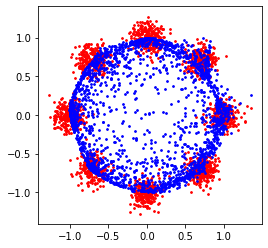

In [24]:
# k = 10, epoch 200
if __name__ == "__main__":
    print("Starting training....")
    train_10 = []
    log_10 = []
    
    for epoch in tqdm(range(1, args.epochs + 1)):
      #  train(epoch)
        a,b= train(epoch)
        train_10.append(a)
        log_10.append(b)
        
  
    print("train1", train_10, log_10)


    gt = next(train_loader)
        
    with torch.no_grad():
        #sample = torch.randn(2048, K).to(device)
        #out = model.decode(sample).cpu().numpy()
        out1 = model.sample()
        recon = model(gt)[0].cpu().numpy()

    rx,ry = recon[:,0], recon[:,1]
        
    gt = gt.cpu().numpy()
    gx, gy = gt[:,0], gt[:,1]
        
    xs, ys = out1[:,0], out1[:,1]

    plt.scatter(gx, gy, c = 'red', s=3)
    plt.scatter(xs, ys, c = 'blue', s=3)
    plt.axes().set_aspect('equal')
    plt.show()
    
#    st()

In [17]:
train_10 = [0.3462608015537262, 0.29327857613563535, 0.27696271777153014, 0.2610496427118778, 0.25164763629436493, 0.24957043603062629, 0.24822999581694602, 0.24667362347245217, 0.24582475617527963, 0.24513932585716247, 0.2441394481062889, 0.24299986630678178, 0.24237348675727843, 0.24132728919386864, 0.24070996552705765, 0.23956415489315985, 0.23917783215641975, 0.23873774126172065, 0.2377087165415287, 0.23828084543347358, 0.23764635026454925, 0.23759534269571303, 0.23785562112927436, 0.23738096818327903, 0.2373053702712059, 0.23674861907958986, 0.23700593739748002, 0.23672787249088287, 0.23709127694368362, 0.2369668285548687, 0.2370500835776329, 0.2366880477964878, 0.23680815145373343, 0.23629325836896897, 0.23648156970739365, 0.23624357342720032, 0.23727938085794448, 0.2360643057525158, 0.2362712399661541, 0.23650095313787461, 0.23597831144928932, 0.23595388486981392, 0.2365103717148304, 0.23594656735658645, 0.23688065081834794, 0.23630177050828935, 0.23640200778841972, 0.23617146790027618, 0.23642052218317985, 0.23605721369385718, 0.2360522623360157, 0.23609584972262382, 0.23554669499397277, 0.23622530415654183, 0.2362384571135044, 0.23640617564320565, 0.2362918223440647, 0.23626426205039025, 0.23641805112361908, 0.23600708633661271, 0.23599656134843827, 0.23614174038171767, 0.2363138224184513, 0.23594748914241792, 0.23630114927887916, 0.23622464135289192, 0.2367207470536232, 0.23613750353455543, 0.23604561418294906, 0.23614007651805877, 0.23617302030324935, 0.2360368025302887, 0.2361525148153305, 0.23622859373688698, 0.23609376773238183, 0.23639962956309318, 0.23595613270998, 0.23644535839557648, 0.23625670045614242, 0.23639321073889732, 0.23607553228735922, 0.23622651174664497, 0.23618526443839072, 0.23638751968741417, 0.23599781796336175, 0.2363747201859951, 0.23620160594582557, 0.23604718685150147, 0.23607246547937394, 0.23598817557096483, 0.23583234146237372, 0.2357431010901928, 0.23600306630134582, 0.2363328692317009, 0.23624474480748175, 0.23626387029886245, 0.2367622137069702, 0.2359714537858963, 0.23624029457569123, 0.23601486295461654, 0.23619221672415733, 0.23654883429408075, 0.23632889717817307, 0.23621061116456984, 0.236557587236166, 0.23631187707185744, 0.2360907354950905, 0.2360381205379963, 0.23580805256962775, 0.23642006352543832, 0.23597345843911172, 0.23639499336481096, 0.23598670527338983, 0.23628863722085952, 0.23647818952798844, 0.23592442035675049, 0.2361861699819565, 0.23629306644201278, 0.23606607764959336, 0.23589468732476235, 0.2360842065513134, 0.23607646256685258, 0.23654360294342042, 0.2365065497159958, 0.23633759424090386, 0.23602215349674224, 0.23607172057032585, 0.2363261567056179, 0.23634098708629608, 0.2357862839102745, 0.2360091058909893, 0.23652187928557397, 0.23659199684858323, 0.2361086468398571, 0.2357642750442028, 0.23610018983483314, 0.23610328689217566, 0.23577330738306046, 0.23579066395759582, 0.2362656433880329, 0.23614489749073983, 0.23599698320031165, 0.23614333748817443, 0.23636433824896813, 0.23615285381674767, 0.2362585747241974, 0.23615834668278693, 0.2365859194099903, 0.23605989247560502, 0.23615045428276063, 0.23617201820015907, 0.2361865745484829, 0.23611701264977455, 0.23580138027668, 0.23623911798000335, 0.23590380683541298, 0.23624118462204932, 0.23598563119769098, 0.23616092041134834, 0.2360132336616516, 0.23642451524734498, 0.23608698770403863, 0.23595297753810882, 0.2355918850004673, 0.23628495931625365, 0.2358745639026165, 0.23618697315454484, 0.23615322589874269, 0.23601511865854263, 0.23617604479193688, 0.23665582105517388, 0.23648153886198997, 0.23682893499732016, 0.2363778407871723, 0.23629593804478646, 0.236123948097229, 0.2365836925804615, 0.23659106269478797, 0.23616000533103942, 0.23611517176032065, 0.2362860931456089, 0.23624687567353247, 0.23617775365710258, 0.23621085941791534, 0.23614926725625993, 0.2360099382698536, 0.23615637302398682, 0.23580976977944373, 0.23593474075198173, 0.23612998127937318, 0.2360336148738861, 0.23618252754211425, 0.23676117941737174, 0.23622608974575995, 0.23585614711046218, 0.23568661645054817, 0.2366398511826992, 0.23624565303325654, 0.2361878487467766, 0.23561297371983528]

In [18]:
train_210=[0.23619221672415733, 0.23654883429408075, 0.23632889717817307, 0.23621061116456984, 0.236557587236166, 0.23631187707185744, 0.2360907354950905, 0.2360381205379963, 0.23580805256962775, 0.23642006352543832, 0.23597345843911172, 0.23639499336481096, 0.23598670527338983, 0.23628863722085952, 0.23647818952798844, 0.23592442035675049, 0.2361861699819565, 0.23629306644201278, 0.23606607764959336, 0.23589468732476235, 0.2360842065513134, 0.23607646256685258, 0.23654360294342042, 0.2365065497159958, 0.23633759424090386, 0.23602215349674224, 0.23607172057032585, 0.2363261567056179, 0.23634098708629608, 0.2357862839102745, 0.2360091058909893, 0.23652187928557397, 0.23659199684858323, 0.2361086468398571, 0.2357642750442028, 0.23610018983483314, 0.23610328689217566, 0.23577330738306046, 0.23579066395759582, 0.2362656433880329, 0.23614489749073983, 0.23599698320031165, 0.23614333748817443, 0.23636433824896813, 0.23615285381674767, 0.2362585747241974, 0.23615834668278693, 0.2365859194099903, 0.23605989247560502, 0.23615045428276063, 0.23617201820015907, 0.2361865745484829, 0.23611701264977455, 0.23580138027668, 0.23623911798000335, 0.23590380683541298, 0.23624118462204932, 0.23598563119769098, 0.23616092041134834, 0.2360132336616516, 0.23642451524734498, 0.23608698770403863, 0.23595297753810882, 0.2355918850004673, 0.23628495931625365, 0.2358745639026165, 0.23618697315454484, 0.23615322589874269, 0.23601511865854263, 0.23617604479193688, 0.23665582105517388, 0.23648153886198997, 0.23682893499732016, 0.2363778407871723, 0.23629593804478646, 0.236123948097229, 0.2365836925804615, 0.23659106269478797, 0.23616000533103942, 0.23611517176032065, 0.2362860931456089, 0.23624687567353247, 0.23617775365710258, 0.23621085941791534, 0.23614926725625993, 0.2360099382698536, 0.23615637302398682, 0.23580976977944373, 0.23593474075198173, 0.23612998127937318, 0.2360336148738861, 0.23618252754211425, 0.23676117941737174, 0.23622608974575995, 0.23585614711046218, 0.23568661645054817, 0.2366398511826992, 0.23624565303325654, 0.2361878487467766, 0.23561297371983528]

In [19]:
train10 = np.mean(train_210)

In [20]:
log_10 = [-3.1071118162663627, -2.8015619691174205, -2.68619444314269, -2.466577561909766, -2.3755620613055575, -2.3462097518058043, -2.2884687300309308, -2.208594896980684, -2.175520095967312, -2.2068190321820738, -2.0410515974329684, -1.9954941092766778, -1.9694546198058631, -1.870443183736969, -1.7990540727755318, -1.8198353692219427, -1.7337396926314206, -1.7309592994981262, -1.705294047055987, -1.6952038950186852, -1.644611255577425, -1.6159923296201577, -1.5633045874296247, -1.585449230346974, -1.5862811396408047, -1.6085189757006326, -1.563264368554937, -1.5544015540079568, -1.5564397351917136, -1.5915007309154556, -1.5764068246021146, -1.583299117457671, -1.5349757741867796, -1.5591520702975847, -1.5739032134562332, -1.533293606911129, -1.5704025952188132, -1.5563383885921738, -1.5342055507876338, -1.5811495706706955, -1.5617223762324, -1.5540778060208051, -1.5789896204793485, -1.5740611091273486, -1.531314081871672, -1.5390190455717319, -1.5789760790315472, -1.5317813152320026, -1.5394569416926236, -1.5561733236830066, -1.5379697175325928, -1.5443426399838482, -1.5532377292845951, -1.5745203021599616, -1.5335508855680202, -1.5553909809565756, -1.5616182406525603, -1.5624661941055937, -1.550729598253545, -1.5362521558346196, -1.541911571845807, -1.5260181340558412, -1.551280825895658, -1.55831810011733, -1.5547640375784506, -1.5311514109594266, -1.5433301403330988, -1.5578230781800355, -1.551082757142071, -1.5757255834416042, -1.5667752545505218, -1.544394207514458, -1.5867687163590505, -1.5552674061021237, -1.5263211353866764, -1.5231257455938327, -1.5416062993431432, -1.5364645481186434, -1.592972094826247, -1.5648218011001593, -1.5679865210889101, -1.5178874787639427, -1.5613230551443087, -1.516774149374662, -1.5364752209630073, -1.5178752071749742, -1.5436571057705075, -1.5473344669046445, -1.5508584383605186, -1.5740721602651142, -1.5358901743248659, -1.529757049814735, -1.5716146119821153, -1.556484074847566, -1.5649959808095142, -1.5406801735204836, -1.5513742418742655, -1.5449713819004236, -1.5505226435628627, -1.5423083642273585, -1.540632879018087, -1.5442775489758656, -1.566232721707425, -1.5501107941560353, -1.5507864953659878, -1.507046437995995, -1.5450922157965843, -1.5511907542620647, -1.5928719024716542, -1.5520652770605565, -1.4959692291267341, -1.5446297840350431, -1.5355518115535314, -1.541965745321474, -1.5407235416864102, -1.5551559653419398, -1.5523980194214724, -1.5283251387978027, -1.535652780142296, -1.5582615221739635, -1.5574993909756976, -1.550104839049352, -1.5489412940924063, -1.5676433130264606, -1.5505318963699886, -1.5286893160249944, -1.5346102344530477, -1.5611821798930927, -1.553561737382433, -1.5613028130999895, -1.5345768330746847, -1.5624952872865747, -1.5507428429115127, -1.5486077040887842, -1.609378029881546, -1.5941711087477715, -1.577521624587326, -1.5820634102444582, -1.5446355264780038, -1.5410120360130695, -1.5395320860985147, -1.5653201916619237, -1.5446501070833165, -1.580501137280335, -1.553139058230459, -1.5635518125468586, -1.5657639401043713, -1.5428909071104737, -1.5230604446302916, -1.59154024665026, -1.5584150929206686, -1.5433010992757938, -1.5664192569467963, -1.5252452091453652, -1.5799301005430113, -1.5602907439284208, -1.5681481405943285, -1.5291317525810268, -1.5537773096414451, -1.5235349653269405, -1.546598070436387, -1.5292661261722875, -1.5718371541619758, -1.5900912986744646, -1.540291169805695, -1.5588929140185153, -1.561167525996016, -1.5565478431500672, -1.5427183745772362, -1.5409967132733289, -1.5097224987921798, -1.5471166063917825, -1.5611571962940252, -1.5260888165340285, -1.5179404307947633, -1.540606041314487, -1.5720628332021689, -1.550786659581378, -1.5281209736610428, -1.5652888937426084, -1.57869598010056, -1.527350080579271, -1.5521268116431801, -1.5690691548364946, -1.529877821287816, -1.5486561101273182, -1.556862132282426, -1.5371784638966157, -1.544759094768846, -1.5643548963155975, -1.52835307173346, -1.5308158140716106, -1.5620343411060582, -1.5521459796516959, -1.5513865445023636, -1.5906610871773532, -1.5482791439193169, -1.5581994577175116, -1.5717328522895753, -1.520561428069512]

In [21]:
log_210 = [-1.540632879018087, -1.5442775489758656, -1.566232721707425, -1.5501107941560353, -1.5507864953659878, -1.507046437995995, -1.5450922157965843, -1.5511907542620647, -1.5928719024716542, -1.5520652770605565, -1.4959692291267341, -1.5446297840350431, -1.5355518115535314, -1.541965745321474, -1.5407235416864102, -1.5551559653419398, -1.5523980194214724, -1.5283251387978027, -1.535652780142296, -1.5582615221739635, -1.5574993909756976, -1.550104839049352, -1.5489412940924063, -1.5676433130264606, -1.5505318963699886, -1.5286893160249944, -1.5346102344530477, -1.5611821798930927, -1.553561737382433, -1.5613028130999895, -1.5345768330746847, -1.5624952872865747, -1.5507428429115127, -1.5486077040887842, -1.609378029881546, -1.5941711087477715, -1.577521624587326, -1.5820634102444582, -1.5446355264780038, -1.5410120360130695, -1.5395320860985147, -1.5653201916619237, -1.5446501070833165, -1.580501137280335, -1.553139058230459, -1.5635518125468586, -1.5657639401043713, -1.5428909071104737, -1.5230604446302916, -1.59154024665026, -1.5584150929206686, -1.5433010992757938, -1.5664192569467963, -1.5252452091453652, -1.5799301005430113, -1.5602907439284208, -1.5681481405943285, -1.5291317525810268, -1.5537773096414451, -1.5235349653269405, -1.546598070436387, -1.5292661261722875, -1.5718371541619758, -1.5900912986744646, -1.540291169805695, -1.5588929140185153, -1.561167525996016, -1.5565478431500672, -1.5427183745772362, -1.5409967132733289, -1.5097224987921798, -1.5471166063917825, -1.5611571962940252, -1.5260888165340285, -1.5179404307947633, -1.540606041314487, -1.5720628332021689, -1.550786659581378, -1.5281209736610428, -1.5652888937426084, -1.57869598010056, -1.527350080579271, -1.5521268116431801, -1.5690691548364946, -1.529877821287816, -1.5486561101273182, -1.556862132282426, -1.5371784638966157, -1.544759094768846, -1.5643548963155975, -1.52835307173346, -1.5308158140716106, -1.5620343411060582, -1.5521459796516959, -1.5513865445023636, -1.5906610871773532, -1.5482791439193169, -1.5581994577175116, -1.5717328522895753, -1.520561428069512]

In [23]:
log10 = np.mean(log_210)

  0%|          | 0/200 [00:00<?, ?it/s]

Starting training....


  0%|          | 1/200 [00:10<35:17, 10.64s/it]

Epoch  average reconstruction error   : 1 0.3346002273261547
 likelihood  : -3.959962239761304


  1%|          | 2/200 [00:20<34:13, 10.37s/it]

Epoch  average reconstruction error   : 2 0.24097138360142709
 likelihood  : -3.566653588769183


  2%|▏         | 3/200 [00:27<30:44,  9.36s/it]

Epoch  average reconstruction error   : 3 0.21124213963747024
 likelihood  : -2.8887704101955856


  2%|▏         | 4/200 [00:38<32:04,  9.82s/it]

Epoch  average reconstruction error   : 4 0.16634145364165306
 likelihood  : -2.7898070599029707


  2%|▎         | 5/200 [00:45<29:49,  9.18s/it]

Epoch  average reconstruction error   : 5 0.16161257058382034
 likelihood  : -2.620219514375659


  3%|▎         | 6/200 [00:54<28:52,  8.93s/it]

Epoch  average reconstruction error   : 6 0.159546355009079
 likelihood  : -2.4486904091512907


  4%|▎         | 7/200 [01:01<26:56,  8.38s/it]

Epoch  average reconstruction error   : 7 0.15759661555290222
 likelihood  : -2.3494211088186936


  4%|▍         | 8/200 [01:10<27:52,  8.71s/it]

Epoch  average reconstruction error   : 8 0.15608376309275626
 likelihood  : -2.2741661995483238


  4%|▍         | 9/200 [01:18<26:45,  8.41s/it]

Epoch  average reconstruction error   : 9 0.1542793869972229
 likelihood  : -2.11023231364128


  5%|▌         | 10/200 [01:26<25:58,  8.20s/it]

Epoch  average reconstruction error   : 10 0.15306433528661728
 likelihood  : -2.064213527973898


  6%|▌         | 11/200 [01:33<24:51,  7.89s/it]

Epoch  average reconstruction error   : 11 0.15162322416901589
 likelihood  : -1.9769687387997315


  6%|▌         | 12/200 [01:46<29:42,  9.48s/it]

Epoch  average reconstruction error   : 12 0.15007653683423997
 likelihood  : -1.8764574726792964


  6%|▋         | 13/200 [01:56<29:40,  9.52s/it]

Epoch  average reconstruction error   : 13 0.14876222491264343
 likelihood  : -1.8021506807085832


  7%|▋         | 14/200 [02:04<28:40,  9.25s/it]

Epoch  average reconstruction error   : 14 0.14777776166796686
 likelihood  : -1.6922109782510468


  8%|▊         | 15/200 [02:14<29:13,  9.48s/it]

Epoch  average reconstruction error   : 15 0.1465276812016964
 likelihood  : -1.637314126953795


  8%|▊         | 16/200 [02:21<26:49,  8.75s/it]

Epoch  average reconstruction error   : 16 0.14533040046691895
 likelihood  : -1.6135967186264213


  8%|▊         | 17/200 [02:29<25:55,  8.50s/it]

Epoch  average reconstruction error   : 17 0.1447061502933502
 likelihood  : -1.523209241202192


  9%|▉         | 18/200 [02:36<24:20,  8.03s/it]

Epoch  average reconstruction error   : 18 0.14411491945385932
 likelihood  : -1.5238802930844844


 10%|▉         | 19/200 [02:48<27:11,  9.01s/it]

Epoch  average reconstruction error   : 19 0.14359843134880065
 likelihood  : -1.478840735265778


 10%|█         | 20/200 [02:55<25:13,  8.41s/it]

Epoch  average reconstruction error   : 20 0.14325437769293786
 likelihood  : -1.4629207437729077


 10%|█         | 21/200 [03:03<24:49,  8.32s/it]

Epoch  average reconstruction error   : 21 0.14341667667031288
 likelihood  : -1.462386225780785


 11%|█         | 22/200 [03:10<23:35,  7.95s/it]

Epoch  average reconstruction error   : 22 0.14341312482953072
 likelihood  : -1.4455106660453096


 12%|█▏        | 23/200 [03:19<24:18,  8.24s/it]

Epoch  average reconstruction error   : 23 0.1430576853454113
 likelihood  : -1.3944631322716527


 12%|█▏        | 24/200 [03:26<23:03,  7.86s/it]

Epoch  average reconstruction error   : 24 0.14276391237974168
 likelihood  : -1.4008475392522455


 12%|█▎        | 25/200 [03:35<23:59,  8.22s/it]

Epoch  average reconstruction error   : 25 0.1431458266079426
 likelihood  : -1.4338378878930498


 13%|█▎        | 26/200 [03:42<22:53,  7.89s/it]

Epoch  average reconstruction error   : 26 0.14287454262375832
 likelihood  : -1.4009107025404122


 14%|█▎        | 27/200 [03:52<24:24,  8.47s/it]

Epoch  average reconstruction error   : 27 0.14274519860744475
 likelihood  : -1.386195810992411


 14%|█▍        | 28/200 [03:59<22:56,  8.00s/it]

Epoch  average reconstruction error   : 28 0.14263000220060348
 likelihood  : -1.4112546068292366


 14%|█▍        | 29/200 [04:07<23:00,  8.08s/it]

Epoch  average reconstruction error   : 29 0.14281062707304953
 likelihood  : -1.3771013978705258
Epoch    30: reducing learning rate of group 0 to 1.0000e-04.


 15%|█▌        | 30/200 [04:26<32:19, 11.41s/it]

Epoch  average reconstruction error   : 30 0.14257316708564757
 likelihood  : -1.3718413467777473


 16%|█▌        | 31/200 [04:36<30:57, 10.99s/it]

Epoch  average reconstruction error   : 31 0.14244409412145614
 likelihood  : -1.3578764098654827


 16%|█▌        | 32/200 [04:43<27:21,  9.77s/it]

Epoch  average reconstruction error   : 32 0.14250962778925896
 likelihood  : -1.3961981564783932


 16%|█▋        | 33/200 [04:54<27:54, 10.03s/it]

Epoch  average reconstruction error   : 33 0.14239498525857924
 likelihood  : -1.3912899500836213


 17%|█▋        | 34/200 [05:01<25:50,  9.34s/it]

Epoch  average reconstruction error   : 34 0.14218194484710694
 likelihood  : -1.39580432361912


 18%|█▊        | 35/200 [05:11<25:41,  9.34s/it]

Epoch  average reconstruction error   : 35 0.142360125631094
 likelihood  : -1.381773636612545


 18%|█▊        | 36/200 [05:18<23:45,  8.69s/it]

Epoch  average reconstruction error   : 36 0.1422026364505291
 likelihood  : -1.3906386970146531


 18%|█▊        | 37/200 [05:27<24:00,  8.84s/it]

Epoch  average reconstruction error   : 37 0.14221156746149063
 likelihood  : -1.3672431584287377


 19%|█▉        | 38/200 [05:34<22:20,  8.27s/it]

Epoch  average reconstruction error   : 38 0.14224349126219749
 likelihood  : -1.3916583877567588


 20%|█▉        | 39/200 [05:43<22:33,  8.41s/it]

Epoch  average reconstruction error   : 39 0.1422101491689682
 likelihood  : -1.395884002086903


 20%|██        | 40/200 [05:50<21:45,  8.16s/it]

Epoch  average reconstruction error   : 40 0.14233452767133714
 likelihood  : -1.3902308189552848


 20%|██        | 41/200 [05:58<21:22,  8.07s/it]

Epoch  average reconstruction error   : 41 0.14210643485188484
 likelihood  : -1.3599048676140981


 21%|██        | 42/200 [06:06<21:10,  8.04s/it]

Epoch  average reconstruction error   : 42 0.14220981642603875
 likelihood  : -1.3456417355982309


 22%|██▏       | 43/200 [06:14<20:42,  7.91s/it]

Epoch  average reconstruction error   : 43 0.14224374398589135
 likelihood  : -1.3758058751206752


 22%|██▏       | 44/200 [06:21<19:46,  7.60s/it]

Epoch  average reconstruction error   : 44 0.14230925783514978
 likelihood  : -1.3639886307238498


 22%|██▎       | 45/200 [06:30<21:04,  8.16s/it]

Epoch  average reconstruction error   : 45 0.14222138360142708
 likelihood  : -1.3502235162749034


 23%|██▎       | 46/200 [06:37<19:54,  7.76s/it]

Epoch  average reconstruction error   : 46 0.14218203708529473
 likelihood  : -1.3565819321158479


 24%|██▎       | 47/200 [06:46<21:00,  8.24s/it]

Epoch  average reconstruction error   : 47 0.1423172615468502
 likelihood  : -1.4031732274220228


 24%|██▍       | 48/200 [06:53<19:50,  7.83s/it]

Epoch  average reconstruction error   : 48 0.14209100469946861
 likelihood  : -1.3878661298266912


 24%|██▍       | 49/200 [07:14<29:28, 11.71s/it]

Epoch  average reconstruction error   : 49 0.14193768218159675
 likelihood  : -1.3862704157696997


 25%|██▌       | 50/200 [07:21<25:38, 10.26s/it]

Epoch  average reconstruction error   : 50 0.14240288779139518
 likelihood  : -1.3793727925646455


 26%|██▌       | 51/200 [07:30<24:52, 10.02s/it]

Epoch  average reconstruction error   : 51 0.1421982815861702
 likelihood  : -1.3792212129414407
Epoch    52: reducing learning rate of group 0 to 1.0000e-05.


 26%|██▌       | 52/200 [07:37<22:22,  9.07s/it]

Epoch  average reconstruction error   : 52 0.1422805206477642
 likelihood  : -1.3712057500045134


 26%|██▋       | 53/200 [07:47<22:32,  9.20s/it]

Epoch  average reconstruction error   : 53 0.14228472948074342
 likelihood  : -1.3824803095056262


 27%|██▋       | 54/200 [07:53<20:40,  8.50s/it]

Epoch  average reconstruction error   : 54 0.14217751055955888
 likelihood  : -1.3679395081078138


 28%|██▊       | 55/200 [08:03<21:18,  8.81s/it]

Epoch  average reconstruction error   : 55 0.14188946098089217
 likelihood  : -1.361623196909799


 28%|██▊       | 56/200 [08:10<19:43,  8.22s/it]

Epoch  average reconstruction error   : 56 0.14230947822332382
 likelihood  : -1.352144209044379


 28%|██▊       | 57/200 [08:20<20:47,  8.73s/it]

Epoch  average reconstruction error   : 57 0.14239780217409134
 likelihood  : -1.3736573090591429


 29%|██▉       | 58/200 [08:27<19:18,  8.16s/it]

Epoch  average reconstruction error   : 58 0.14199824780225753
 likelihood  : -1.386451726035153


 30%|██▉       | 59/200 [08:36<20:05,  8.55s/it]

Epoch  average reconstruction error   : 59 0.1421908561885357
 likelihood  : -1.3586752782429792


 30%|███       | 60/200 [08:43<18:49,  8.07s/it]

Epoch  average reconstruction error   : 60 0.14228232815861702
 likelihood  : -1.3686542245745816


 30%|███       | 61/200 [08:52<19:40,  8.49s/it]

Epoch  average reconstruction error   : 61 0.142284587174654
 likelihood  : -1.387302071992036


 31%|███       | 62/200 [08:59<18:23,  7.99s/it]

Epoch  average reconstruction error   : 62 0.141948943734169
 likelihood  : -1.3908479563176732
Epoch    63: reducing learning rate of group 0 to 1.0000e-06.


 32%|███▏      | 63/200 [09:09<19:13,  8.42s/it]

Epoch  average reconstruction error   : 63 0.1423363921046257
 likelihood  : -1.3515123015740205


 32%|███▏      | 64/200 [09:16<18:03,  7.97s/it]

Epoch  average reconstruction error   : 64 0.1421981219947338
 likelihood  : -1.367762646798176


 32%|███▎      | 65/200 [09:26<19:12,  8.54s/it]

Epoch  average reconstruction error   : 65 0.1422116631269455
 likelihood  : -1.3503014726457345


 33%|███▎      | 66/200 [09:32<18:01,  8.07s/it]

Epoch  average reconstruction error   : 66 0.1421348686516285
 likelihood  : -1.3741391078986864


 34%|███▎      | 67/200 [09:48<23:00, 10.38s/it]

Epoch  average reconstruction error   : 67 0.14209537580609322
 likelihood  : -1.3806918538617166


 34%|███▍      | 68/200 [09:58<22:13, 10.11s/it]

Epoch  average reconstruction error   : 68 0.14222552210092546
 likelihood  : -1.3652742220451768


 34%|███▍      | 69/200 [10:05<19:56,  9.13s/it]

Epoch  average reconstruction error   : 69 0.14188273519277572
 likelihood  : -1.4024028187928956


 35%|███▌      | 70/200 [10:14<20:01,  9.25s/it]

Epoch  average reconstruction error   : 70 0.14219095572829246
 likelihood  : -1.3820945608423365


 36%|███▌      | 71/200 [10:21<18:21,  8.54s/it]

Epoch  average reconstruction error   : 71 0.14222540706396103
 likelihood  : -1.375071751418277


 36%|███▌      | 72/200 [10:31<19:21,  9.07s/it]

Epoch  average reconstruction error   : 72 0.1425401635468006
 likelihood  : -1.3422019934702747


 36%|███▋      | 73/200 [10:38<17:51,  8.43s/it]

Epoch  average reconstruction error   : 73 0.14212653517723084
 likelihood  : -1.3755937895606252


 37%|███▋      | 74/200 [10:46<17:10,  8.18s/it]

Epoch  average reconstruction error   : 74 0.142117273658514
 likelihood  : -1.4133711931499215


 38%|███▊      | 75/200 [10:53<16:39,  7.99s/it]

Epoch  average reconstruction error   : 75 0.14208988904953002
 likelihood  : -1.3749719617473606


 38%|███▊      | 76/200 [11:03<17:24,  8.42s/it]

Epoch  average reconstruction error   : 76 0.14211936980485917
 likelihood  : -1.3782935699805576


 38%|███▊      | 77/200 [11:10<16:17,  7.95s/it]

Epoch  average reconstruction error   : 77 0.14204430535435678
 likelihood  : -1.336894274640425


 39%|███▉      | 78/200 [11:18<16:13,  7.98s/it]

Epoch  average reconstruction error   : 78 0.14212781995534896
 likelihood  : -1.3611580854694851


 40%|███▉      | 79/200 [11:25<15:27,  7.67s/it]

Epoch  average reconstruction error   : 79 0.14194645702838898
 likelihood  : -1.3397514675550541


 40%|████      | 80/200 [11:35<16:45,  8.38s/it]

Epoch  average reconstruction error   : 80 0.14213798075914383
 likelihood  : -1.382142836857837


 40%|████      | 81/200 [11:42<15:47,  7.97s/it]

Epoch  average reconstruction error   : 81 0.14200059905648232
 likelihood  : -1.3885281206138085


 41%|████      | 82/200 [11:50<15:36,  7.94s/it]

Epoch  average reconstruction error   : 82 0.14227770373225213
 likelihood  : -1.37742194940092


 42%|████▏     | 83/200 [11:56<14:51,  7.62s/it]

Epoch  average reconstruction error   : 83 0.14195818915963174
 likelihood  : -1.3790278033035888


 42%|████▏     | 84/200 [12:08<16:59,  8.79s/it]

Epoch  average reconstruction error   : 84 0.14198603302240373
 likelihood  : -1.3796381816911336


 42%|████▎     | 85/200 [12:27<22:49, 11.91s/it]

Epoch  average reconstruction error   : 85 0.1419911241531372
 likelihood  : -1.387582202202256


 43%|████▎     | 86/200 [12:37<21:11, 11.16s/it]

Epoch  average reconstruction error   : 86 0.14203634545207022
 likelihood  : -1.361765018326888


 44%|████▎     | 87/200 [12:45<19:18, 10.25s/it]

Epoch  average reconstruction error   : 87 0.14205307841300965
 likelihood  : -1.3662930251114527


 44%|████▍     | 88/200 [12:55<18:54, 10.13s/it]

Epoch  average reconstruction error   : 88 0.14222654476761817
 likelihood  : -1.340414054398269


 44%|████▍     | 89/200 [13:02<17:09,  9.28s/it]

Epoch  average reconstruction error   : 89 0.1422225734591484
 likelihood  : -1.3676205317308745


 45%|████▌     | 90/200 [13:11<16:52,  9.20s/it]

Epoch  average reconstruction error   : 90 0.1421845029294491
 likelihood  : -1.3543026729942724


 46%|████▌     | 91/200 [13:18<15:26,  8.50s/it]

Epoch  average reconstruction error   : 91 0.1420464986562729
 likelihood  : -1.37444125319937


 46%|████▌     | 92/200 [13:27<15:40,  8.71s/it]

Epoch  average reconstruction error   : 92 0.1422893586754799
 likelihood  : -1.3539488801386126


 46%|████▋     | 93/200 [13:34<14:34,  8.17s/it]

Epoch  average reconstruction error   : 93 0.14219471275806428
 likelihood  : -1.366685157079571


 47%|████▋     | 94/200 [13:43<14:55,  8.45s/it]

Epoch  average reconstruction error   : 94 0.1422230587899685
 likelihood  : -1.3652878464815466


 48%|████▊     | 95/200 [13:51<14:24,  8.24s/it]

Epoch  average reconstruction error   : 95 0.14227164700627326
 likelihood  : -1.3709295102025916


 48%|████▊     | 96/200 [13:59<14:23,  8.30s/it]

Epoch  average reconstruction error   : 96 0.14216197177767753
 likelihood  : -1.3722640339432255


 48%|████▊     | 97/200 [14:06<13:33,  7.90s/it]

Epoch  average reconstruction error   : 97 0.14225030034780503
 likelihood  : -1.356851813891965


 49%|████▉     | 98/200 [14:14<13:34,  7.98s/it]

Epoch  average reconstruction error   : 98 0.1421545147895813
 likelihood  : -1.3707358744537048


 50%|████▉     | 99/200 [14:21<12:54,  7.67s/it]

Epoch  average reconstruction error   : 99 0.1418409152328968
 likelihood  : -1.3758388650907774


 50%|█████     | 100/200 [14:31<13:44,  8.24s/it]

Epoch  average reconstruction error   : 100 0.1422313357889652
 likelihood  : -1.364715087493828


 50%|█████     | 101/200 [14:38<12:55,  7.83s/it]

Epoch  average reconstruction error   : 101 0.14242835253477096
 likelihood  : -1.393840665992832


 51%|█████     | 102/200 [14:46<12:48,  7.85s/it]

Epoch  average reconstruction error   : 102 0.1421214883029461
 likelihood  : -1.3956751251981037


 52%|█████▏    | 103/200 [14:53<12:37,  7.81s/it]

Epoch  average reconstruction error   : 103 0.14240032613277434
 likelihood  : -1.3741971053100381


 52%|█████▏    | 104/200 [15:15<19:17, 12.06s/it]

Epoch  average reconstruction error   : 104 0.14201797395944596
 likelihood  : -1.36595850908444


 52%|█████▎    | 105/200 [15:22<16:39, 10.52s/it]

Epoch  average reconstruction error   : 105 0.14209659531712532
 likelihood  : -1.3640763469401724


 53%|█████▎    | 106/200 [15:32<16:00, 10.22s/it]

Epoch  average reconstruction error   : 106 0.14219119310379028
 likelihood  : -1.3656570026869468


 54%|█████▎    | 107/200 [15:39<14:17,  9.22s/it]

Epoch  average reconstruction error   : 107 0.14204324081540107
 likelihood  : -1.3471320867261651


 54%|█████▍    | 108/200 [15:48<14:16,  9.31s/it]

Epoch  average reconstruction error   : 108 0.1421430604159832
 likelihood  : -1.3814090198624789


 55%|█████▍    | 109/200 [15:55<13:02,  8.60s/it]

Epoch  average reconstruction error   : 109 0.1422475254535675
 likelihood  : -1.3869082099360504


 55%|█████▌    | 110/200 [16:05<13:36,  9.07s/it]

Epoch  average reconstruction error   : 110 0.14231199607253076
 likelihood  : -1.3750709316927852


 56%|█████▌    | 111/200 [16:12<12:29,  8.42s/it]

Epoch  average reconstruction error   : 111 0.1421826159954071
 likelihood  : -1.3967617402785482


 56%|█████▌    | 112/200 [16:22<13:09,  8.97s/it]

Epoch  average reconstruction error   : 112 0.1423422145843506
 likelihood  : -1.382172218066938


 56%|█████▋    | 113/200 [16:29<12:06,  8.35s/it]

Epoch  average reconstruction error   : 113 0.14194435596466065
 likelihood  : -1.3596742708389549


 57%|█████▋    | 114/200 [16:39<12:31,  8.74s/it]

Epoch  average reconstruction error   : 114 0.14210976153612137
 likelihood  : -1.3642331329888289


 57%|█████▊    | 115/200 [16:46<11:38,  8.21s/it]

Epoch  average reconstruction error   : 115 0.1421682995557785
 likelihood  : -1.3692586058108083


 58%|█████▊    | 116/200 [16:54<11:21,  8.11s/it]

Epoch  average reconstruction error   : 116 0.14248494759202004
 likelihood  : -1.3818600565588102


 58%|█████▊    | 117/200 [17:01<10:43,  7.75s/it]

Epoch  average reconstruction error   : 117 0.14218538761138916
 likelihood  : -1.3712508232626304


 59%|█████▉    | 118/200 [17:11<11:35,  8.48s/it]

Epoch  average reconstruction error   : 118 0.1423034618794918
 likelihood  : -1.3945800376689348


 60%|█████▉    | 119/200 [17:18<10:49,  8.02s/it]

Epoch  average reconstruction error   : 119 0.14219871535897255
 likelihood  : -1.3685460956552389


 60%|██████    | 120/200 [17:26<10:38,  7.98s/it]

Epoch  average reconstruction error   : 120 0.14219515427947044
 likelihood  : -1.3609974129919717


 60%|██████    | 121/200 [17:33<10:06,  7.68s/it]

Epoch  average reconstruction error   : 121 0.1422197662293911
 likelihood  : -1.3767482683639884


 61%|██████    | 122/200 [17:49<13:17, 10.23s/it]

Epoch  average reconstruction error   : 122 0.1421970845758915
 likelihood  : -1.3735621115969967


 62%|██████▏   | 123/200 [17:58<12:51, 10.02s/it]

Epoch  average reconstruction error   : 123 0.14221105322241784
 likelihood  : -1.3782627991669487


 62%|██████▏   | 124/200 [18:05<11:30,  9.09s/it]

Epoch  average reconstruction error   : 124 0.14190892070531846
 likelihood  : -1.3678589431204262


 62%|██████▎   | 125/200 [18:16<11:48,  9.45s/it]

Epoch  average reconstruction error   : 125 0.14215159490704538
 likelihood  : -1.3816279092157169


 63%|██████▎   | 126/200 [18:23<10:45,  8.72s/it]

Epoch  average reconstruction error   : 126 0.14201323121786116
 likelihood  : -1.3560217271332897


 64%|██████▎   | 127/200 [18:30<10:12,  8.39s/it]

Epoch  average reconstruction error   : 127 0.14231632068753242
 likelihood  : -1.3634610992551917


 64%|██████▍   | 128/200 [18:37<09:32,  7.95s/it]

Epoch  average reconstruction error   : 128 0.14201179161667823
 likelihood  : -1.3715355909986646


 64%|██████▍   | 129/200 [18:47<10:00,  8.46s/it]

Epoch  average reconstruction error   : 129 0.1421201817691326
 likelihood  : -1.3507126068976927


 65%|██████▌   | 130/200 [18:54<09:20,  8.01s/it]

Epoch  average reconstruction error   : 130 0.14228863805532455
 likelihood  : -1.3540457365590628


 66%|██████▌   | 131/200 [19:04<10:06,  8.80s/it]

Epoch  average reconstruction error   : 131 0.14208927869796753
 likelihood  : -1.383945235072543


 66%|██████▌   | 132/200 [19:11<09:19,  8.23s/it]

Epoch  average reconstruction error   : 132 0.14217784985899926
 likelihood  : -1.3512798546503035


 66%|██████▋   | 133/200 [19:20<09:20,  8.37s/it]

Epoch  average reconstruction error   : 133 0.14217972308397292
 likelihood  : -1.3932278057155747


 67%|██████▋   | 134/200 [19:27<08:43,  7.93s/it]

Epoch  average reconstruction error   : 134 0.14193702533841132
 likelihood  : -1.3618291911550409


 68%|██████▊   | 135/200 [19:35<08:41,  8.02s/it]

Epoch  average reconstruction error   : 135 0.1419845487177372
 likelihood  : -1.3493732814803372


 68%|██████▊   | 136/200 [19:42<08:11,  7.67s/it]

Epoch  average reconstruction error   : 136 0.14211030974984168
 likelihood  : -1.358103409688027


 68%|██████▊   | 137/200 [19:53<08:59,  8.57s/it]

Epoch  average reconstruction error   : 137 0.14200209498405456
 likelihood  : -1.371429683277599


 69%|██████▉   | 138/200 [20:02<09:07,  8.84s/it]

Epoch  average reconstruction error   : 138 0.14200393229722977
 likelihood  : -1.3491463542350308


 70%|██████▉   | 139/200 [20:09<08:23,  8.25s/it]

Epoch  average reconstruction error   : 139 0.14206047132611274
 likelihood  : -1.3830963777624536


 70%|███████   | 140/200 [20:29<11:42, 11.70s/it]

Epoch  average reconstruction error   : 140 0.14194362699985505
 likelihood  : -1.417749802954961


 70%|███████   | 141/200 [20:38<10:51, 11.05s/it]

Epoch  average reconstruction error   : 141 0.14209818005561828
 likelihood  : -1.3525307450498592


 71%|███████   | 142/200 [20:45<09:28,  9.80s/it]

Epoch  average reconstruction error   : 142 0.14225906386971474
 likelihood  : -1.3829675190161752


 72%|███████▏  | 143/200 [20:55<09:14,  9.73s/it]

Epoch  average reconstruction error   : 143 0.14221159845590592
 likelihood  : -1.3566163452828488


 72%|███████▏  | 144/200 [21:02<08:23,  8.99s/it]

Epoch  average reconstruction error   : 144 0.14224372029304505
 likelihood  : -1.3487791405566325


 72%|███████▎  | 145/200 [21:10<07:54,  8.63s/it]

Epoch  average reconstruction error   : 145 0.14168160274624825
 likelihood  : -1.3547786827709376


 73%|███████▎  | 146/200 [21:17<07:17,  8.09s/it]

Epoch  average reconstruction error   : 146 0.1425355014204979
 likelihood  : -1.3976593608729848


 74%|███████▎  | 147/200 [21:26<07:30,  8.50s/it]

Epoch  average reconstruction error   : 147 0.14193807110190393
 likelihood  : -1.3568619859113618


 74%|███████▍  | 148/200 [21:34<07:12,  8.31s/it]

Epoch  average reconstruction error   : 148 0.14211804270744324
 likelihood  : -1.3724126623539143


 74%|███████▍  | 149/200 [21:42<06:57,  8.18s/it]

Epoch  average reconstruction error   : 149 0.14234449744224548
 likelihood  : -1.3635751769247328


 75%|███████▌  | 150/200 [21:49<06:30,  7.80s/it]

Epoch  average reconstruction error   : 150 0.14246308505535127
 likelihood  : -1.3532561626304966


 76%|███████▌  | 151/200 [21:58<06:46,  8.29s/it]

Epoch  average reconstruction error   : 151 0.1421057577431202
 likelihood  : -1.369420585736107


 76%|███████▌  | 152/200 [22:06<06:25,  8.03s/it]

Epoch  average reconstruction error   : 152 0.14222753897309304
 likelihood  : -1.3555283838402112


 76%|███████▋  | 153/200 [22:15<06:37,  8.45s/it]

Epoch  average reconstruction error   : 153 0.14201318353414535
 likelihood  : -1.3514592687839775


 77%|███████▋  | 154/200 [22:27<07:16,  9.48s/it]

Epoch  average reconstruction error   : 154 0.1421145297586918
 likelihood  : -1.3829924192333054


 78%|███████▊  | 155/200 [22:35<06:52,  9.16s/it]

Epoch  average reconstruction error   : 155 0.14232926443219185
 likelihood  : -1.3663416413288412


 78%|███████▊  | 156/200 [22:46<07:07,  9.71s/it]

Epoch  average reconstruction error   : 156 0.14204001069068908
 likelihood  : -1.368328658598449


 78%|███████▊  | 157/200 [22:53<06:22,  8.90s/it]

Epoch  average reconstruction error   : 157 0.14224469646811486
 likelihood  : -1.3603395180891982


 79%|███████▉  | 158/200 [23:09<07:36, 10.86s/it]

Epoch  average reconstruction error   : 158 0.14211466789245605
 likelihood  : -1.375997606156266


 80%|███████▉  | 159/200 [23:18<07:09, 10.46s/it]

Epoch  average reconstruction error   : 159 0.14204408034682273
 likelihood  : -1.3854413961431855


 80%|████████  | 160/200 [23:25<06:17,  9.44s/it]

Epoch  average reconstruction error   : 160 0.14225418001413345
 likelihood  : -1.358985118415243


 80%|████████  | 161/200 [23:36<06:24,  9.85s/it]

Epoch  average reconstruction error   : 161 0.1420102646946907
 likelihood  : -1.388325730733312


 81%|████████  | 162/200 [23:46<06:14,  9.85s/it]

Epoch  average reconstruction error   : 162 0.1421957677602768
 likelihood  : -1.3778974901022427


 82%|████████▏ | 163/200 [23:53<05:31,  8.96s/it]

Epoch  average reconstruction error   : 163 0.1421942089498043
 likelihood  : -1.343372826511628


 82%|████████▏ | 164/200 [24:02<05:29,  9.15s/it]

Epoch  average reconstruction error   : 164 0.14202868968248367
 likelihood  : -1.3588966291059161


 82%|████████▎ | 165/200 [24:09<04:56,  8.47s/it]

Epoch  average reconstruction error   : 165 0.14200860157608985
 likelihood  : -1.3913391715045673


 83%|████████▎ | 166/200 [24:20<05:10,  9.13s/it]

Epoch  average reconstruction error   : 166 0.1423236146569252
 likelihood  : -1.3496628019385013


 84%|████████▎ | 167/200 [24:27<04:39,  8.46s/it]

Epoch  average reconstruction error   : 167 0.1421724119782448
 likelihood  : -1.3659509463574904


 84%|████████▍ | 168/200 [24:36<04:40,  8.78s/it]

Epoch  average reconstruction error   : 168 0.1420094832777977
 likelihood  : -1.3498931325899632


 84%|████████▍ | 169/200 [24:43<04:14,  8.22s/it]

Epoch  average reconstruction error   : 169 0.14196192502975463
 likelihood  : -1.3840846580344384


 85%|████████▌ | 170/200 [24:53<04:21,  8.73s/it]

Epoch  average reconstruction error   : 170 0.14239294216036796
 likelihood  : -1.3624276215865008


 86%|████████▌ | 171/200 [25:01<04:04,  8.42s/it]

Epoch  average reconstruction error   : 171 0.14196113750338554
 likelihood  : -1.3822635571965403


 86%|████████▌ | 172/200 [25:11<04:06,  8.80s/it]

Epoch  average reconstruction error   : 172 0.14209430485963823
 likelihood  : -1.3460547801511233


 86%|████████▋ | 173/200 [25:18<03:42,  8.24s/it]

Epoch  average reconstruction error   : 173 0.14208154633641243
 likelihood  : -1.3719180460117997


 87%|████████▋ | 174/200 [25:27<03:44,  8.62s/it]

Epoch  average reconstruction error   : 174 0.14206898972392082
 likelihood  : -1.3607042628471686


 88%|████████▊ | 175/200 [25:45<04:42, 11.28s/it]

Epoch  average reconstruction error   : 175 0.14211707457900047
 likelihood  : -1.3629574173175216


 88%|████████▊ | 176/200 [25:59<04:52, 12.19s/it]

Epoch  average reconstruction error   : 176 0.14219588473439215
 likelihood  : -1.3573655176037436


 88%|████████▊ | 177/200 [26:07<04:09, 10.84s/it]

Epoch  average reconstruction error   : 177 0.1419519217312336
 likelihood  : -1.3817772167143016


 89%|████████▉ | 178/200 [26:16<03:50, 10.47s/it]

Epoch  average reconstruction error   : 178 0.1419971205294132
 likelihood  : -1.4010835570312503


 90%|████████▉ | 179/200 [26:43<05:22, 15.37s/it]

Epoch  average reconstruction error   : 179 0.142250324934721
 likelihood  : -1.3741589511689725


 90%|█████████ | 180/200 [26:50<04:16, 12.82s/it]

Epoch  average reconstruction error   : 180 0.142164673358202
 likelihood  : -1.3676075413067468


 90%|█████████ | 181/200 [26:59<03:43, 11.79s/it]

Epoch  average reconstruction error   : 181 0.14225200027227403
 likelihood  : -1.3914567308621013


 91%|█████████ | 182/200 [27:07<03:08, 10.48s/it]

Epoch  average reconstruction error   : 182 0.14207949981093407
 likelihood  : -1.3635932571559612


 92%|█████████▏| 183/200 [27:16<02:53, 10.21s/it]

Epoch  average reconstruction error   : 183 0.1421131558716297
 likelihood  : -1.371656128996873


 92%|█████████▏| 184/200 [27:23<02:27,  9.22s/it]

Epoch  average reconstruction error   : 184 0.14199252888560296
 likelihood  : -1.3564163123585666


 92%|█████████▎| 185/200 [27:33<02:19,  9.29s/it]

Epoch  average reconstruction error   : 185 0.14219482645392417
 likelihood  : -1.376389062767506


 93%|█████████▎| 186/200 [27:39<01:59,  8.56s/it]

Epoch  average reconstruction error   : 186 0.14212810575962068
 likelihood  : -1.3498481389812975


 94%|█████████▎| 187/200 [27:49<01:54,  8.84s/it]

Epoch  average reconstruction error   : 187 0.14207382053136824
 likelihood  : -1.3783222302544618


 94%|█████████▍| 188/200 [27:56<01:39,  8.28s/it]

Epoch  average reconstruction error   : 188 0.1422721104323864
 likelihood  : -1.3637766823006328


 94%|█████████▍| 189/200 [28:06<01:38,  8.93s/it]

Epoch  average reconstruction error   : 189 0.14242472156882285
 likelihood  : -1.3844014429198124


 95%|█████████▌| 190/200 [28:21<01:47, 10.76s/it]

Epoch  average reconstruction error   : 190 0.14199793174862863
 likelihood  : -1.3705713495743184


 96%|█████████▌| 191/200 [28:35<01:43, 11.55s/it]

Epoch  average reconstruction error   : 191 0.14213734567165376
 likelihood  : -1.3676995062467472


 96%|█████████▌| 192/200 [28:42<01:21, 10.16s/it]

Epoch  average reconstruction error   : 192 0.14225002631545067
 likelihood  : -1.3729689656132762


 96%|█████████▋| 193/200 [28:52<01:10, 10.12s/it]

Epoch  average reconstruction error   : 193 0.14219896599650383
 likelihood  : -1.352916222653116


 97%|█████████▋| 194/200 [28:59<00:54,  9.16s/it]

Epoch  average reconstruction error   : 194 0.14237689167261125
 likelihood  : -1.3282873912647037


 98%|█████████▊| 195/200 [29:08<00:46,  9.24s/it]

Epoch  average reconstruction error   : 195 0.14245563119649887
 likelihood  : -1.3463773626589735


 98%|█████████▊| 196/200 [29:16<00:34,  8.68s/it]

Epoch  average reconstruction error   : 196 0.14216312482953072
 likelihood  : -1.3583095499586175


 98%|█████████▊| 197/200 [29:26<00:28,  9.35s/it]

Epoch  average reconstruction error   : 197 0.14224621251225472
 likelihood  : -1.3729047673766508


 99%|█████████▉| 198/200 [29:34<00:17,  8.76s/it]

Epoch  average reconstruction error   : 198 0.1420922739803791
 likelihood  : -1.3778682938897844


100%|█████████▉| 199/200 [29:44<00:09,  9.19s/it]

Epoch  average reconstruction error   : 199 0.1420995034277439
 likelihood  : -1.3618993879298562


100%|██████████| 200/200 [29:55<00:00,  8.98s/it]

Epoch  average reconstruction error   : 200 0.14221278592944145
 likelihood  : -1.3519580601046406
train1 [0.3346002273261547, 0.24097138360142709, 0.21124213963747024, 0.16634145364165306, 0.16161257058382034, 0.159546355009079, 0.15759661555290222, 0.15608376309275626, 0.1542793869972229, 0.15306433528661728, 0.15162322416901589, 0.15007653683423997, 0.14876222491264343, 0.14777776166796686, 0.1465276812016964, 0.14533040046691895, 0.1447061502933502, 0.14411491945385932, 0.14359843134880065, 0.14325437769293786, 0.14341667667031288, 0.14341312482953072, 0.1430576853454113, 0.14276391237974168, 0.1431458266079426, 0.14287454262375832, 0.14274519860744475, 0.14263000220060348, 0.14281062707304953, 0.14257316708564757, 0.14244409412145614, 0.14250962778925896, 0.14239498525857924, 0.14218194484710694, 0.142360125631094, 0.1422026364505291, 0.14221156746149063, 0.14224349126219749, 0.1422101491689682, 0.14233452767133714, 0.14210643485188484, 0.14220981642603875, 0.14224374398589135, 0.


__main__:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


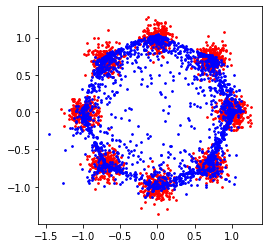

In [36]:
# k = 20, epoch 200
if __name__ == "__main__":
    print("Starting training....")
    train_20 = []
    log_20 = []
    
    for epoch in tqdm(range(1, args.epochs + 1)):
      #  train(epoch)
        a,b= train(epoch)
        train_20.append(a)
        log_20.append(b)
        
  
    print("train1", train_20, log_20)


    gt = next(train_loader)
        
    with torch.no_grad():
        #sample = torch.randn(2048, K).to(device)
        #out = model.decode(sample).cpu().numpy()
        out1 = model.sample()
        recon = model(gt)[0].cpu().numpy()

    rx,ry = recon[:,0], recon[:,1]
        
    gt = gt.cpu().numpy()
    gx, gy = gt[:,0], gt[:,1]
        
    xs, ys = out1[:,0], out1[:,1]

    plt.scatter(gx, gy, c = 'red', s=3)
    plt.scatter(xs, ys, c = 'blue', s=3)
    plt.axes().set_aspect('equal')
    plt.show()
    
#    st()

In [24]:
train_20  =[0.3346002273261547, 0.24097138360142709, 0.21124213963747024, 0.16634145364165306, 0.16161257058382034, 0.159546355009079, 0.15759661555290222, 0.15608376309275626, 0.1542793869972229, 0.15306433528661728, 0.15162322416901589, 0.15007653683423997, 0.14876222491264343, 0.14777776166796686, 0.1465276812016964, 0.14533040046691895, 0.1447061502933502, 0.14411491945385932, 0.14359843134880065, 0.14325437769293786, 0.14341667667031288, 0.14341312482953072, 0.1430576853454113, 0.14276391237974168, 0.1431458266079426, 0.14287454262375832, 0.14274519860744475, 0.14263000220060348, 0.14281062707304953, 0.14257316708564757, 0.14244409412145614, 0.14250962778925896, 0.14239498525857924, 0.14218194484710694, 0.142360125631094, 0.1422026364505291, 0.14221156746149063, 0.14224349126219749, 0.1422101491689682, 0.14233452767133714, 0.14210643485188484, 0.14220981642603875, 0.14224374398589135, 0.14230925783514978, 0.14222138360142708, 0.14218203708529473, 0.1423172615468502, 0.14209100469946861, 0.14193768218159675, 0.14240288779139518, 0.1421982815861702, 0.1422805206477642, 0.14228472948074342, 0.14217751055955888, 0.14188946098089217, 0.14230947822332382, 0.14239780217409134, 0.14199824780225753, 0.1421908561885357, 0.14228232815861702, 0.142284587174654, 0.141948943734169, 0.1423363921046257, 0.1421981219947338, 0.1422116631269455, 0.1421348686516285, 0.14209537580609322, 0.14222552210092546, 0.14188273519277572, 0.14219095572829246, 0.14222540706396103, 0.1425401635468006, 0.14212653517723084, 0.142117273658514, 0.14208988904953002, 0.14211936980485917, 0.14204430535435678, 0.14212781995534896, 0.14194645702838898, 0.14213798075914383, 0.14200059905648232, 0.14227770373225213, 0.14195818915963174, 0.14198603302240373, 0.1419911241531372, 0.14203634545207022, 0.14205307841300965, 0.14222654476761817, 0.1422225734591484, 0.1421845029294491, 0.1420464986562729, 0.1422893586754799, 0.14219471275806428, 0.1422230587899685, 0.14227164700627326, 0.14216197177767753, 0.14225030034780503, 0.1421545147895813, 0.1418409152328968, 0.1422313357889652, 0.14242835253477096, 0.1421214883029461, 0.14240032613277434, 0.14201797395944596, 0.14209659531712532, 0.14219119310379028, 0.14204324081540107, 0.1421430604159832, 0.1422475254535675, 0.14231199607253076, 0.1421826159954071, 0.1423422145843506, 0.14194435596466065, 0.14210976153612137, 0.1421682995557785, 0.14248494759202004, 0.14218538761138916, 0.1423034618794918, 0.14219871535897255, 0.14219515427947044, 0.1422197662293911, 0.1421970845758915, 0.14221105322241784, 0.14190892070531846, 0.14215159490704538, 0.14201323121786116, 0.14231632068753242, 0.14201179161667823, 0.1421201817691326, 0.14228863805532455, 0.14208927869796753, 0.14217784985899926, 0.14217972308397292, 0.14193702533841132, 0.1419845487177372, 0.14211030974984168, 0.14200209498405456, 0.14200393229722977, 0.14206047132611274, 0.14194362699985505, 0.14209818005561828, 0.14225906386971474, 0.14221159845590592, 0.14224372029304505, 0.14168160274624825, 0.1425355014204979, 0.14193807110190393, 0.14211804270744324, 0.14234449744224548, 0.14246308505535127, 0.1421057577431202, 0.14222753897309304, 0.14201318353414535, 0.1421145297586918, 0.14232926443219185, 0.14204001069068908, 0.14224469646811486, 0.14211466789245605, 0.14204408034682273, 0.14225418001413345, 0.1420102646946907, 0.1421957677602768, 0.1421942089498043, 0.14202868968248367, 0.14200860157608985, 0.1423236146569252, 0.1421724119782448, 0.1420094832777977, 0.14196192502975463, 0.14239294216036796, 0.14196113750338554, 0.14209430485963823, 0.14208154633641243, 0.14206898972392082, 0.14211707457900047, 0.14219588473439215, 0.1419519217312336, 0.1419971205294132, 0.142250324934721, 0.142164673358202, 0.14225200027227403, 0.14207949981093407, 0.1421131558716297, 0.14199252888560296, 0.14219482645392417, 0.14212810575962068, 0.14207382053136824, 0.1422721104323864, 0.14242472156882285, 0.14199793174862863, 0.14213734567165376, 0.14225002631545067, 0.14219896599650383, 0.14237689167261125, 0.14245563119649887, 0.14216312482953072, 0.14224621251225472, 0.1420922739803791, 0.1420995034277439, 0.14221278592944145] 

In [25]:
train_220 = [0.14242835253477096, 0.1421214883029461, 0.14240032613277434, 0.14201797395944596, 0.14209659531712532, 0.14219119310379028, 0.14204324081540107, 0.1421430604159832, 0.1422475254535675, 0.14231199607253076, 0.1421826159954071, 0.1423422145843506, 0.14194435596466065, 0.14210976153612137, 0.1421682995557785, 0.14248494759202004, 0.14218538761138916, 0.1423034618794918, 0.14219871535897255, 0.14219515427947044, 0.1422197662293911, 0.1421970845758915, 0.14221105322241784, 0.14190892070531846, 0.14215159490704538, 0.14201323121786116, 0.14231632068753242, 0.14201179161667823, 0.1421201817691326, 0.14228863805532455, 0.14208927869796753, 0.14217784985899926, 0.14217972308397292, 0.14193702533841132, 0.1419845487177372, 0.14211030974984168, 0.14200209498405456, 0.14200393229722977, 0.14206047132611274, 0.14194362699985505, 0.14209818005561828, 0.14225906386971474, 0.14221159845590592, 0.14224372029304505, 0.14168160274624825, 0.1425355014204979, 0.14193807110190393, 0.14211804270744324, 0.14234449744224548, 0.14246308505535127, 0.1421057577431202, 0.14222753897309304, 0.14201318353414535, 0.1421145297586918, 0.14232926443219185, 0.14204001069068908, 0.14224469646811486, 0.14211466789245605, 0.14204408034682273, 0.14225418001413345, 0.1420102646946907, 0.1421957677602768, 0.1421942089498043, 0.14202868968248367, 0.14200860157608985, 0.1423236146569252, 0.1421724119782448, 0.1420094832777977, 0.14196192502975463, 0.14239294216036796, 0.14196113750338554, 0.14209430485963823, 0.14208154633641243, 0.14206898972392082, 0.14211707457900047, 0.14219588473439215, 0.1419519217312336, 0.1419971205294132, 0.142250324934721, 0.142164673358202, 0.14225200027227403, 0.14207949981093407, 0.1421131558716297, 0.14199252888560296, 0.14219482645392417, 0.14212810575962068, 0.14207382053136824, 0.1422721104323864, 0.14242472156882285, 0.14199793174862863, 0.14213734567165376, 0.14225002631545067, 0.14219896599650383, 0.14237689167261125, 0.14245563119649887, 0.14216312482953072, 0.14224621251225472, 0.1420922739803791, 0.1420995034277439, 0.14221278592944145]

In [26]:
train20 = np.mean(train_220)

In [27]:
log_20 = [-3.959962239761304, -3.566653588769183, -2.8887704101955856, -2.7898070599029707, -2.620219514375659, -2.4486904091512907, -2.3494211088186936, -2.2741661995483238, -2.11023231364128, -2.064213527973898, -1.9769687387997315, -1.8764574726792964, -1.8021506807085832, -1.6922109782510468, -1.637314126953795, -1.6135967186264213, -1.523209241202192, -1.5238802930844844, -1.478840735265778, -1.4629207437729077, -1.462386225780785, -1.4455106660453096, -1.3944631322716527, -1.4008475392522455, -1.4338378878930498, -1.4009107025404122, -1.386195810992411, -1.4112546068292366, -1.3771013978705258, -1.3718413467777473, -1.3578764098654827, -1.3961981564783932, -1.3912899500836213, -1.39580432361912, -1.381773636612545, -1.3906386970146531, -1.3672431584287377, -1.3916583877567588, -1.395884002086903, -1.3902308189552848, -1.3599048676140981, -1.3456417355982309, -1.3758058751206752, -1.3639886307238498, -1.3502235162749034, -1.3565819321158479, -1.4031732274220228, -1.3878661298266912, -1.3862704157696997, -1.3793727925646455, -1.3792212129414407, -1.3712057500045134, -1.3824803095056262, -1.3679395081078138, -1.361623196909799, -1.352144209044379, -1.3736573090591429, -1.386451726035153, -1.3586752782429792, -1.3686542245745816, -1.387302071992036, -1.3908479563176732, -1.3515123015740205, -1.367762646798176, -1.3503014726457345, -1.3741391078986864, -1.3806918538617166, -1.3652742220451768, -1.4024028187928956, -1.3820945608423365, -1.375071751418277, -1.3422019934702747, -1.3755937895606252, -1.4133711931499215, -1.3749719617473606, -1.3782935699805576, -1.336894274640425, -1.3611580854694851, -1.3397514675550541, -1.382142836857837, -1.3885281206138085, -1.37742194940092, -1.3790278033035888, -1.3796381816911336, -1.387582202202256, -1.361765018326888, -1.3662930251114527, -1.340414054398269, -1.3676205317308745, -1.3543026729942724, -1.37444125319937, -1.3539488801386126, -1.366685157079571, -1.3652878464815466, -1.3709295102025916, -1.3722640339432255, -1.356851813891965, -1.3707358744537048, -1.3758388650907774, -1.364715087493828, -1.393840665992832, -1.3956751251981037, -1.3741971053100381, -1.36595850908444, -1.3640763469401724, -1.3656570026869468, -1.3471320867261651, -1.3814090198624789, -1.3869082099360504, -1.3750709316927852, -1.3967617402785482, -1.382172218066938, -1.3596742708389549, -1.3642331329888289, -1.3692586058108083, -1.3818600565588102, -1.3712508232626304, -1.3945800376689348, -1.3685460956552389, -1.3609974129919717, -1.3767482683639884, -1.3735621115969967, -1.3782627991669487, -1.3678589431204262, -1.3816279092157169, -1.3560217271332897, -1.3634610992551917, -1.3715355909986646, -1.3507126068976927, -1.3540457365590628, -1.383945235072543, -1.3512798546503035, -1.3932278057155747, -1.3618291911550409, -1.3493732814803372, -1.358103409688027, -1.371429683277599, -1.3491463542350308, -1.3830963777624536, -1.417749802954961, -1.3525307450498592, -1.3829675190161752, -1.3566163452828488, -1.3487791405566325, -1.3547786827709376, -1.3976593608729848, -1.3568619859113618, -1.3724126623539143, -1.3635751769247328, -1.3532561626304966, -1.369420585736107, -1.3555283838402112, -1.3514592687839775, -1.3829924192333054, -1.3663416413288412, -1.368328658598449, -1.3603395180891982, -1.375997606156266, -1.3854413961431855, -1.358985118415243, -1.388325730733312, -1.3778974901022427, -1.343372826511628, -1.3588966291059161, -1.3913391715045673, -1.3496628019385013, -1.3659509463574904, -1.3498931325899632, -1.3840846580344384, -1.3624276215865008, -1.3822635571965403, -1.3460547801511233, -1.3719180460117997, -1.3607042628471686, -1.3629574173175216, -1.3573655176037436, -1.3817772167143016, -1.4010835570312503, -1.3741589511689725, -1.3676075413067468, -1.3914567308621013, -1.3635932571559612, -1.371656128996873, -1.3564163123585666, -1.376389062767506, -1.3498481389812975, -1.3783222302544618, -1.3637766823006328, -1.3844014429198124, -1.3705713495743184, -1.3676995062467472, -1.3729689656132762, -1.352916222653116, -1.3282873912647037, -1.3463773626589735, -1.3583095499586175, -1.3729047673766508, -1.3778682938897844, -1.3618993879298562, -1.3519580601046406]

In [28]:
log_220 = [-1.393840665992832, -1.3956751251981037, -1.3741971053100381, -1.36595850908444, -1.3640763469401724, -1.3656570026869468, -1.3471320867261651, -1.3814090198624789, -1.3869082099360504, -1.3750709316927852, -1.3967617402785482, -1.382172218066938, -1.3596742708389549, -1.3642331329888289, -1.3692586058108083, -1.3818600565588102, -1.3712508232626304, -1.3945800376689348, -1.3685460956552389, -1.3609974129919717, -1.3767482683639884, -1.3735621115969967, -1.3782627991669487, -1.3678589431204262, -1.3816279092157169, -1.3560217271332897, -1.3634610992551917, -1.3715355909986646, -1.3507126068976927, -1.3540457365590628, -1.383945235072543, -1.3512798546503035, -1.3932278057155747, -1.3618291911550409, -1.3493732814803372, -1.358103409688027, -1.371429683277599, -1.3491463542350308, -1.3830963777624536, -1.417749802954961, -1.3525307450498592, -1.3829675190161752, -1.3566163452828488, -1.3487791405566325, -1.3547786827709376, -1.3976593608729848, -1.3568619859113618, -1.3724126623539143, -1.3635751769247328, -1.3532561626304966, -1.369420585736107, -1.3555283838402112, -1.3514592687839775, -1.3829924192333054, -1.3663416413288412, -1.368328658598449, -1.3603395180891982, -1.375997606156266, -1.3854413961431855, -1.358985118415243, -1.388325730733312, -1.3778974901022427, -1.343372826511628, -1.3588966291059161, -1.3913391715045673, -1.3496628019385013, -1.3659509463574904, -1.3498931325899632, -1.3840846580344384, -1.3624276215865008, -1.3822635571965403, -1.3460547801511233, -1.3719180460117997, -1.3607042628471686, -1.3629574173175216, -1.3573655176037436, -1.3817772167143016, -1.4010835570312503, -1.3741589511689725, -1.3676075413067468, -1.3914567308621013, -1.3635932571559612, -1.371656128996873, -1.3564163123585666, -1.376389062767506, -1.3498481389812975, -1.3783222302544618, -1.3637766823006328, -1.3844014429198124, -1.3705713495743184, -1.3676995062467472, -1.3729689656132762, -1.352916222653116, -1.3282873912647037, -1.3463773626589735, -1.3583095499586175, -1.3729047673766508, -1.3778682938897844, -1.3618993879298562, -1.3519580601046406]

In [29]:
log20= np.mean(log_220)

  0%|          | 0/200 [00:00<?, ?it/s]

Starting training....


  0%|          | 1/200 [00:15<51:05, 15.40s/it]

Epoch  average reconstruction error   : 1 0.2773541320860386
 likelihood  : -4.015485879675005


  1%|          | 2/200 [00:28<48:27, 14.68s/it]

Epoch  average reconstruction error   : 2 0.17834901109337806
 likelihood  : -3.1181823562897106


  2%|▏         | 3/200 [00:38<43:13, 13.17s/it]

Epoch  average reconstruction error   : 3 0.12957105867564678
 likelihood  : -2.9427956138552904


  2%|▏         | 4/200 [00:48<40:02, 12.26s/it]

Epoch  average reconstruction error   : 4 0.12359359204769134
 likelihood  : -2.8155101813273653


  2%|▎         | 5/200 [01:00<39:44, 12.23s/it]

Epoch  average reconstruction error   : 5 0.1218687903881073
 likelihood  : -2.650280518020052


  3%|▎         | 6/200 [01:12<39:20, 12.17s/it]

Epoch  average reconstruction error   : 6 0.11986209191381932
 likelihood  : -2.517014576923535


  4%|▎         | 7/200 [01:21<36:34, 11.37s/it]

Epoch  average reconstruction error   : 7 0.11796163603663444
 likelihood  : -2.3727726298709166


  4%|▍         | 8/200 [01:34<37:39, 11.77s/it]

Epoch  average reconstruction error   : 8 0.11646959379315376
 likelihood  : -2.2544843128673433


  4%|▍         | 9/200 [01:47<38:23, 12.06s/it]

Epoch  average reconstruction error   : 9 0.11488930821418762
 likelihood  : -2.145773915855584


  5%|▌         | 10/200 [01:57<36:40, 11.58s/it]

Epoch  average reconstruction error   : 10 0.11312264062464238
 likelihood  : -1.9960463056327213


  6%|▌         | 11/200 [02:08<36:01, 11.43s/it]

Epoch  average reconstruction error   : 11 0.1115620145201683
 likelihood  : -1.8527464392617428


  6%|▌         | 12/200 [02:34<49:12, 15.70s/it]

Epoch  average reconstruction error   : 12 0.10986714281141757
 likelihood  : -1.7163900994582333


  6%|▋         | 13/200 [02:49<48:04, 15.43s/it]

Epoch  average reconstruction error   : 13 0.108639510050416
 likelihood  : -1.6695083734722393


  7%|▋         | 14/200 [03:00<43:53, 14.16s/it]

Epoch  average reconstruction error   : 14 0.10745594225823879
 likelihood  : -1.521044174471396


  8%|▊         | 15/200 [03:13<42:51, 13.90s/it]

Epoch  average reconstruction error   : 15 0.10649109311401844
 likelihood  : -1.514437341431448


  8%|▊         | 16/200 [03:27<42:30, 13.86s/it]

Epoch  average reconstruction error   : 16 0.10599645547568798
 likelihood  : -1.4723040238410254


  8%|▊         | 17/200 [03:41<42:32, 13.95s/it]

Epoch  average reconstruction error   : 17 0.10565495550632477
 likelihood  : -1.4566816472465134


  9%|▉         | 18/200 [03:55<41:47, 13.78s/it]

Epoch  average reconstruction error   : 18 0.1053083161264658
 likelihood  : -1.4141847141455424


 10%|▉         | 19/200 [04:06<39:02, 12.94s/it]

Epoch  average reconstruction error   : 19 0.10492053896188736
 likelihood  : -1.424425277759286


 10%|█         | 20/200 [04:17<37:20, 12.45s/it]

Epoch  average reconstruction error   : 20 0.10504720404744149
 likelihood  : -1.4063802541628811


 10%|█         | 21/200 [04:31<38:23, 12.87s/it]

Epoch  average reconstruction error   : 21 0.10454779900610447
 likelihood  : -1.355546041500936


 11%|█         | 22/200 [04:45<39:47, 13.41s/it]

Epoch  average reconstruction error   : 22 0.10461710445582867
 likelihood  : -1.3694895988198161


 12%|█▏        | 23/200 [05:08<47:14, 16.01s/it]

Epoch  average reconstruction error   : 23 0.10454016335308552
 likelihood  : -1.341952806026353


 12%|█▏        | 24/200 [05:23<46:40, 15.91s/it]

Epoch  average reconstruction error   : 24 0.10443559095263481
 likelihood  : -1.3431275913284126


 12%|█▎        | 25/200 [05:37<44:51, 15.38s/it]

Epoch  average reconstruction error   : 25 0.10460219860076904
 likelihood  : -1.3967699071893183


 13%|█▎        | 26/200 [05:52<43:35, 15.03s/it]

Epoch  average reconstruction error   : 26 0.10437201760709286
 likelihood  : -1.3133757572603084


 14%|█▎        | 27/200 [06:05<42:19, 14.68s/it]

Epoch  average reconstruction error   : 27 0.1043309846520424
 likelihood  : -1.3277776325129793


 14%|█▍        | 28/200 [06:19<41:17, 14.40s/it]

Epoch  average reconstruction error   : 28 0.10432775847613812
 likelihood  : -1.325952866467096


 14%|█▍        | 29/200 [06:30<38:00, 13.33s/it]

Epoch  average reconstruction error   : 29 0.10408788092434407
 likelihood  : -1.3153992739458942
Epoch    30: reducing learning rate of group 0 to 1.0000e-04.


 15%|█▌        | 30/200 [06:41<35:54, 12.67s/it]

Epoch  average reconstruction error   : 30 0.10410431891679764
 likelihood  : -1.2903823411059925


 16%|█▌        | 31/200 [06:55<36:43, 13.04s/it]

Epoch  average reconstruction error   : 31 0.10379890531301499
 likelihood  : -1.335914173077037


 16%|█▌        | 32/200 [07:08<36:45, 13.13s/it]

Epoch  average reconstruction error   : 32 0.10372410461306572
 likelihood  : -1.305707399833496


 16%|█▋        | 33/200 [07:22<36:44, 13.20s/it]

Epoch  average reconstruction error   : 33 0.10368935093283653
 likelihood  : -1.3060651462769393


 17%|█▋        | 34/200 [07:46<45:36, 16.49s/it]

Epoch  average reconstruction error   : 34 0.10384588055312634
 likelihood  : -1.3406035090064756


 18%|█▊        | 35/200 [07:59<42:46, 15.55s/it]

Epoch  average reconstruction error   : 35 0.10374969594180584
 likelihood  : -1.3160254395056272


 18%|█▊        | 36/200 [08:13<41:01, 15.01s/it]

Epoch  average reconstruction error   : 36 0.10375919751822948
 likelihood  : -1.304858509574287


 18%|█▊        | 37/200 [08:26<39:26, 14.52s/it]

Epoch  average reconstruction error   : 37 0.10393625177443028
 likelihood  : -1.3172452076537198


 19%|█▉        | 38/200 [08:37<36:07, 13.38s/it]

Epoch  average reconstruction error   : 38 0.10376318611204624
 likelihood  : -1.316802813949074


 20%|█▉        | 39/200 [08:50<35:24, 13.20s/it]

Epoch  average reconstruction error   : 39 0.10371701665222645
 likelihood  : -1.308981789617797


 20%|██        | 40/200 [09:04<35:51, 13.45s/it]

Epoch  average reconstruction error   : 40 0.10382473625242711
 likelihood  : -1.320924422204158


 20%|██        | 41/200 [09:19<36:53, 13.92s/it]

Epoch  average reconstruction error   : 41 0.10383999668061733
 likelihood  : -1.3275990369947603
Epoch    42: reducing learning rate of group 0 to 1.0000e-05.


 21%|██        | 42/200 [09:32<36:07, 13.72s/it]

Epoch  average reconstruction error   : 42 0.10365977436304093
 likelihood  : -1.322396564649996


 22%|██▏       | 43/200 [09:43<33:56, 12.97s/it]

Epoch  average reconstruction error   : 43 0.10368375144898892
 likelihood  : -1.3296358008988456


 22%|██▏       | 44/200 [09:55<32:29, 12.50s/it]

Epoch  average reconstruction error   : 44 0.10372569963335991
 likelihood  : -1.3054457268761424


 22%|██▎       | 45/200 [10:08<32:56, 12.75s/it]

Epoch  average reconstruction error   : 45 0.10374277867376805
 likelihood  : -1.2605932940587459


 23%|██▎       | 46/200 [10:35<43:54, 17.11s/it]

Epoch  average reconstruction error   : 46 0.10370289072394372
 likelihood  : -1.3289764996056523


 24%|██▎       | 47/200 [10:46<38:47, 15.21s/it]

Epoch  average reconstruction error   : 47 0.10355730906128884
 likelihood  : -1.3076175217893296


 24%|██▍       | 48/200 [10:58<35:55, 14.18s/it]

Epoch  average reconstruction error   : 48 0.1035458305478096
 likelihood  : -1.2910210635063857


 24%|██▍       | 49/200 [11:11<35:04, 13.94s/it]

Epoch  average reconstruction error   : 49 0.10363909393548966
 likelihood  : -1.3147754928377102


 25%|██▌       | 50/200 [11:26<35:12, 14.08s/it]

Epoch  average reconstruction error   : 50 0.10350081086158752
 likelihood  : -1.318478469782477


 26%|██▌       | 51/200 [11:39<34:36, 13.94s/it]

Epoch  average reconstruction error   : 51 0.10364280864596367
 likelihood  : -1.3019564910625334


 26%|██▌       | 52/200 [11:50<32:02, 12.99s/it]

Epoch  average reconstruction error   : 52 0.10375732958316802
 likelihood  : -1.3218682070059318
Epoch    53: reducing learning rate of group 0 to 1.0000e-06.


 26%|██▋       | 53/200 [12:02<30:53, 12.61s/it]

Epoch  average reconstruction error   : 53 0.10369411528110505
 likelihood  : -1.299756023912587


 27%|██▋       | 54/200 [12:15<31:14, 12.84s/it]

Epoch  average reconstruction error   : 54 0.10366057381033897
 likelihood  : -1.340779470515314


 28%|██▊       | 55/200 [12:30<32:32, 13.47s/it]

Epoch  average reconstruction error   : 55 0.10366069465875626
 likelihood  : -1.2968358224910737


 28%|██▊       | 56/200 [12:43<32:09, 13.40s/it]

Epoch  average reconstruction error   : 56 0.10364596858620644
 likelihood  : -1.279302107488645


 28%|██▊       | 57/200 [13:05<37:50, 15.88s/it]

Epoch  average reconstruction error   : 57 0.10382166430354119
 likelihood  : -1.325949041415382


 29%|██▉       | 58/200 [13:17<34:58, 14.78s/it]

Epoch  average reconstruction error   : 58 0.1039630687236786
 likelihood  : -1.306861746186593


 30%|██▉       | 59/200 [13:29<32:48, 13.96s/it]

Epoch  average reconstruction error   : 59 0.1035523497313261
 likelihood  : -1.2883684054270488


 30%|███       | 60/200 [13:39<29:50, 12.79s/it]

Epoch  average reconstruction error   : 60 0.10356130123138428
 likelihood  : -1.328487580822907


 30%|███       | 61/200 [13:51<29:05, 12.56s/it]

Epoch  average reconstruction error   : 61 0.10373371608555317
 likelihood  : -1.2926105397074314


 31%|███       | 62/200 [14:04<28:51, 12.55s/it]

Epoch  average reconstruction error   : 62 0.10361722648143769
 likelihood  : -1.303534055398389


 32%|███▏      | 63/200 [14:14<26:40, 11.68s/it]

Epoch  average reconstruction error   : 63 0.10368043161928654
 likelihood  : -1.310747860713971


 32%|███▏      | 64/200 [14:25<26:00, 11.48s/it]

Epoch  average reconstruction error   : 64 0.10368131726980209
 likelihood  : -1.32147470921941


 32%|███▎      | 65/200 [14:37<26:16, 11.68s/it]

Epoch  average reconstruction error   : 65 0.10342517800629139
 likelihood  : -1.2794048375406821


 33%|███▎      | 66/200 [14:50<27:12, 12.18s/it]

Epoch  average reconstruction error   : 66 0.10354054361581802
 likelihood  : -1.325065865586194


 34%|███▎      | 67/200 [15:00<25:25, 11.47s/it]

Epoch  average reconstruction error   : 67 0.10386423006653786
 likelihood  : -1.2999283803141888


 34%|███▍      | 68/200 [15:12<25:41, 11.68s/it]

Epoch  average reconstruction error   : 68 0.10348797202110291
 likelihood  : -1.3034639969121364


 34%|███▍      | 69/200 [15:24<25:46, 11.80s/it]

Epoch  average reconstruction error   : 69 0.10383000575006009
 likelihood  : -1.3052836461649444


 35%|███▌      | 70/200 [15:45<31:18, 14.45s/it]

Epoch  average reconstruction error   : 70 0.10366279795765877
 likelihood  : -1.3119787865646688


 36%|███▌      | 71/200 [15:57<29:39, 13.79s/it]

Epoch  average reconstruction error   : 71 0.10361272223293781
 likelihood  : -1.3222396331337578


 36%|███▌      | 72/200 [16:10<28:39, 13.44s/it]

Epoch  average reconstruction error   : 72 0.1036542135477066
 likelihood  : -1.3045609244178047


 36%|███▋      | 73/200 [16:19<26:04, 12.32s/it]

Epoch  average reconstruction error   : 73 0.10369190603494643
 likelihood  : -1.3056462546346568


 37%|███▋      | 74/200 [16:32<25:59, 12.38s/it]

Epoch  average reconstruction error   : 74 0.10349163435399532
 likelihood  : -1.3041002049875223


 38%|███▊      | 75/200 [16:44<25:32, 12.26s/it]

Epoch  average reconstruction error   : 75 0.10363269843161106
 likelihood  : -1.3367676760401295


 38%|███▊      | 76/200 [16:54<24:13, 11.72s/it]

Epoch  average reconstruction error   : 76 0.10376156970858574
 likelihood  : -1.2953335030918005


 38%|███▊      | 77/200 [17:04<22:57, 11.20s/it]

Epoch  average reconstruction error   : 77 0.10362402245402336
 likelihood  : -1.3106118700163853


 39%|███▉      | 78/200 [17:16<23:18, 11.46s/it]

Epoch  average reconstruction error   : 78 0.1038067514449358
 likelihood  : -1.3207351206280995


 40%|███▉      | 79/200 [17:26<21:58, 10.90s/it]

Epoch  average reconstruction error   : 79 0.10374929711222648
 likelihood  : -1.3451339177048378


 40%|████      | 80/200 [17:36<21:21, 10.68s/it]

Epoch  average reconstruction error   : 80 0.10364553712308407
 likelihood  : -1.3116864778098107


 40%|████      | 81/200 [17:48<22:06, 11.14s/it]

Epoch  average reconstruction error   : 81 0.10367701269686222
 likelihood  : -1.3041694236797896


 41%|████      | 82/200 [18:00<22:08, 11.26s/it]

Epoch  average reconstruction error   : 82 0.10359748907387256
 likelihood  : -1.3048894000934483


 42%|████▏     | 83/200 [18:09<20:52, 10.71s/it]

Epoch  average reconstruction error   : 83 0.10379002586007119
 likelihood  : -1.3389929518438444


 42%|████▏     | 84/200 [18:35<29:15, 15.14s/it]

Epoch  average reconstruction error   : 84 0.10378354154527188
 likelihood  : -1.295775018957339


 42%|████▎     | 85/200 [18:44<25:43, 13.43s/it]

Epoch  average reconstruction error   : 85 0.10367438524961471
 likelihood  : -1.3170045143240374


 43%|████▎     | 86/200 [18:56<24:50, 13.07s/it]

Epoch  average reconstruction error   : 86 0.1036435380578041
 likelihood  : -1.3167484580232136


 44%|████▎     | 87/200 [19:09<24:19, 12.91s/it]

Epoch  average reconstruction error   : 87 0.10353998102247715
 likelihood  : -1.3189274339552957


 44%|████▍     | 88/200 [19:22<23:52, 12.79s/it]

Epoch  average reconstruction error   : 88 0.10347704328596592
 likelihood  : -1.3102250887202822


 44%|████▍     | 89/200 [19:31<21:52, 11.83s/it]

Epoch  average reconstruction error   : 89 0.10348038472235203
 likelihood  : -1.2953516913785939


 45%|████▌     | 90/200 [19:43<21:49, 11.90s/it]

Epoch  average reconstruction error   : 90 0.10376749746501446
 likelihood  : -1.3225586041945032


 46%|████▌     | 91/200 [19:55<21:44, 11.97s/it]

Epoch  average reconstruction error   : 91 0.1035772193223238
 likelihood  : -1.3164347168044643


 46%|████▌     | 92/200 [20:05<20:10, 11.21s/it]

Epoch  average reconstruction error   : 92 0.10367273643612862
 likelihood  : -1.2999204412487628


 46%|████▋     | 93/200 [20:17<20:45, 11.64s/it]

Epoch  average reconstruction error   : 93 0.10368739411234856
 likelihood  : -1.3373678552100174


 47%|████▋     | 94/200 [20:30<20:51, 11.80s/it]

Epoch  average reconstruction error   : 94 0.1036127433180809
 likelihood  : -1.300525531313252


 48%|████▊     | 95/200 [20:42<20:45, 11.86s/it]

Epoch  average reconstruction error   : 95 0.10371803022921085
 likelihood  : -1.3034870889951573


 48%|████▊     | 96/200 [20:51<19:19, 11.14s/it]

Epoch  average reconstruction error   : 96 0.10354808762669564
 likelihood  : -1.310182182789113


 48%|████▊     | 97/200 [21:13<24:54, 14.51s/it]

Epoch  average reconstruction error   : 97 0.10387423679232598
 likelihood  : -1.2865261024026768


 49%|████▉     | 98/200 [21:24<22:28, 13.22s/it]

Epoch  average reconstruction error   : 98 0.10374739721417427
 likelihood  : -1.3117453516863926


 50%|████▉     | 99/200 [21:36<21:38, 12.85s/it]

Epoch  average reconstruction error   : 99 0.10383105307817458
 likelihood  : -1.3154571867439344


 50%|█████     | 100/200 [21:48<21:00, 12.61s/it]

Epoch  average reconstruction error   : 100 0.10362336128950118
 likelihood  : -1.320667922361769


 50%|█████     | 101/200 [21:57<19:14, 11.66s/it]

Epoch  average reconstruction error   : 101 0.10366147816181183
 likelihood  : -1.3135912756078012


 51%|█████     | 102/200 [22:08<18:29, 11.32s/it]

Epoch  average reconstruction error   : 102 0.10359049290418625
 likelihood  : -1.3082382654049698


 52%|█████▏    | 103/200 [22:20<18:41, 11.56s/it]

Epoch  average reconstruction error   : 103 0.10351686045527458
 likelihood  : -1.3023319875786936


 52%|█████▏    | 104/200 [22:30<17:42, 11.07s/it]

Epoch  average reconstruction error   : 104 0.1036877317726612
 likelihood  : -1.2955014551964283


 52%|█████▎    | 105/200 [22:41<17:39, 11.16s/it]

Epoch  average reconstruction error   : 105 0.10366516895592212
 likelihood  : -1.3420464373309957


 53%|█████▎    | 106/200 [22:56<19:09, 12.23s/it]

Epoch  average reconstruction error   : 106 0.10375988438725471
 likelihood  : -1.317981016340879


 54%|█████▎    | 107/200 [23:09<19:36, 12.65s/it]

Epoch  average reconstruction error   : 107 0.10349770531058311
 likelihood  : -1.3135633159376914


 54%|█████▍    | 108/200 [23:23<19:48, 12.92s/it]

Epoch  average reconstruction error   : 108 0.10359174959361553
 likelihood  : -1.3246715306532502


 55%|█████▍    | 109/200 [23:46<24:15, 16.00s/it]

Epoch  average reconstruction error   : 109 0.10373704589903354
 likelihood  : -1.3063372686477424


 55%|█████▌    | 110/200 [24:00<22:52, 15.25s/it]

Epoch  average reconstruction error   : 110 0.10359872683882713
 likelihood  : -1.3254759926726727


 56%|█████▌    | 111/200 [24:13<21:58, 14.82s/it]

Epoch  average reconstruction error   : 111 0.10360130019485951
 likelihood  : -1.3340254702115515


 56%|█████▌    | 112/200 [24:27<21:12, 14.45s/it]

Epoch  average reconstruction error   : 112 0.10382316522300243
 likelihood  : -1.3044169963107102


 56%|█████▋    | 113/200 [24:39<19:57, 13.77s/it]

Epoch  average reconstruction error   : 113 0.10364056006073952
 likelihood  : -1.3280146248201232


 57%|█████▋    | 114/200 [24:50<18:31, 12.93s/it]

Epoch  average reconstruction error   : 114 0.10372678063809872
 likelihood  : -1.3181694764581768


 57%|█████▊    | 115/200 [25:03<18:28, 13.04s/it]

Epoch  average reconstruction error   : 115 0.10378589272499085
 likelihood  : -1.308280795340945


 58%|█████▊    | 116/200 [25:17<18:24, 13.15s/it]

Epoch  average reconstruction error   : 116 0.10371805638074875
 likelihood  : -1.3075669941485266


 58%|█████▊    | 117/200 [25:30<18:13, 13.18s/it]

Epoch  average reconstruction error   : 117 0.1034537210315466
 likelihood  : -1.316475360000935


 59%|█████▉    | 118/200 [25:42<17:17, 12.65s/it]

Epoch  average reconstruction error   : 118 0.10374778665602208
 likelihood  : -1.2600875534100031


 60%|█████▉    | 119/200 [25:54<17:02, 12.62s/it]

Epoch  average reconstruction error   : 119 0.10364719212055207
 likelihood  : -1.2999471499750008


 60%|██████    | 120/200 [26:08<17:12, 12.91s/it]

Epoch  average reconstruction error   : 120 0.10377361059188843
 likelihood  : -1.2904987101837198


 60%|██████    | 121/200 [26:35<22:45, 17.29s/it]

Epoch  average reconstruction error   : 121 0.10364412792026996
 likelihood  : -1.3381469276349094


 61%|██████    | 122/200 [26:46<20:07, 15.49s/it]

Epoch  average reconstruction error   : 122 0.10364639438688755
 likelihood  : -1.3131248445419197


 62%|██████▏   | 123/200 [26:59<18:44, 14.61s/it]

Epoch  average reconstruction error   : 123 0.10367018222808838
 likelihood  : -1.3201038775972225


 62%|██████▏   | 124/200 [27:12<18:04, 14.26s/it]

Epoch  average reconstruction error   : 124 0.10363970063626766
 likelihood  : -1.307521907528097


 62%|██████▎   | 125/200 [27:26<17:33, 14.04s/it]

Epoch  average reconstruction error   : 125 0.10364955700933934
 likelihood  : -1.3222141954678452


 63%|██████▎   | 126/200 [27:40<17:12, 13.95s/it]

Epoch  average reconstruction error   : 126 0.10364378899335862
 likelihood  : -1.3011491546722693


 64%|██████▎   | 127/200 [27:50<15:48, 12.99s/it]

Epoch  average reconstruction error   : 127 0.10383729577064514
 likelihood  : -1.317584238484243


 64%|██████▍   | 128/200 [28:02<15:03, 12.55s/it]

Epoch  average reconstruction error   : 128 0.10361561931669712
 likelihood  : -1.326469439464122


 64%|██████▍   | 129/200 [28:16<15:13, 12.87s/it]

Epoch  average reconstruction error   : 129 0.10364060670137405
 likelihood  : -1.3260629887477506


 65%|██████▌   | 130/200 [28:29<15:14, 13.07s/it]

Epoch  average reconstruction error   : 130 0.10367115095257759
 likelihood  : -1.3385506837208003


 66%|██████▌   | 131/200 [28:43<15:10, 13.19s/it]

Epoch  average reconstruction error   : 131 0.10372332997620105
 likelihood  : -1.315215038766992


 66%|██████▌   | 132/200 [29:05<18:10, 16.04s/it]

Epoch  average reconstruction error   : 132 0.10373050607740879
 likelihood  : -1.2969971325429528


 66%|██████▋   | 133/200 [29:19<17:01, 15.25s/it]

Epoch  average reconstruction error   : 133 0.10355324484407902
 likelihood  : -1.3026580310268936


 67%|██████▋   | 134/200 [29:32<16:08, 14.67s/it]

Epoch  average reconstruction error   : 134 0.10350681595504284
 likelihood  : -1.311182547868159


 68%|██████▊   | 135/200 [29:46<15:32, 14.35s/it]

Epoch  average reconstruction error   : 135 0.10354868352413177
 likelihood  : -1.3001488866308635


 68%|██████▊   | 136/200 [29:56<14:06, 13.23s/it]

Epoch  average reconstruction error   : 136 0.10364375986158848
 likelihood  : -1.3113635946117967


 68%|██████▊   | 137/200 [30:11<14:13, 13.54s/it]

Epoch  average reconstruction error   : 137 0.10372288547456264
 likelihood  : -1.3075000228464688


 69%|██████▉   | 138/200 [30:24<13:56, 13.49s/it]

Epoch  average reconstruction error   : 138 0.10369172491133213
 likelihood  : -1.3232956449998845


 70%|██████▉   | 139/200 [30:37<13:40, 13.45s/it]

Epoch  average reconstruction error   : 139 0.10382409945130348
 likelihood  : -1.3078861622427467


 70%|███████   | 140/200 [30:51<13:23, 13.39s/it]

Epoch  average reconstruction error   : 140 0.10364409245550632
 likelihood  : -1.3106960713529472


 70%|███████   | 141/200 [31:01<12:25, 12.63s/it]

Epoch  average reconstruction error   : 141 0.1035743810236454
 likelihood  : -1.3180018150154227


 71%|███████   | 142/200 [31:15<12:36, 13.04s/it]

Epoch  average reconstruction error   : 142 0.10380028881132602
 likelihood  : -1.3075559226725266


 72%|███████▏  | 143/200 [31:29<12:31, 13.19s/it]

Epoch  average reconstruction error   : 143 0.10368530958890915
 likelihood  : -1.30265888339018


 72%|███████▏  | 144/200 [31:54<15:44, 16.87s/it]

Epoch  average reconstruction error   : 144 0.10365068294107914
 likelihood  : -1.3061370573344488


 72%|███████▎  | 145/200 [32:05<13:44, 14.99s/it]

Epoch  average reconstruction error   : 145 0.1036550971865654
 likelihood  : -1.2993369785620583


 73%|███████▎  | 146/200 [32:19<13:20, 14.82s/it]

Epoch  average reconstruction error   : 146 0.10362252041697502
 likelihood  : -1.3184875293489342


 74%|███████▎  | 147/200 [32:33<12:46, 14.46s/it]

Epoch  average reconstruction error   : 147 0.10363026291131973
 likelihood  : -1.2924516852685781


 74%|███████▍  | 148/200 [32:47<12:19, 14.23s/it]

Epoch  average reconstruction error   : 148 0.10364665627479554
 likelihood  : -1.3260117706284307


 74%|███████▍  | 149/200 [33:00<11:49, 13.92s/it]

Epoch  average reconstruction error   : 149 0.1034511013329029
 likelihood  : -1.3084757318043814


 75%|███████▌  | 150/200 [33:09<10:29, 12.59s/it]

Epoch  average reconstruction error   : 150 0.10357354715466499
 likelihood  : -1.3103677656171777


 76%|███████▌  | 151/200 [33:22<10:10, 12.45s/it]

Epoch  average reconstruction error   : 151 0.10342209041118622
 likelihood  : -1.289891895972306


 76%|███████▌  | 152/200 [33:34<09:59, 12.48s/it]

Epoch  average reconstruction error   : 152 0.10370126523077489
 likelihood  : -1.2862471488022549


 76%|███████▋  | 153/200 [33:46<09:40, 12.36s/it]

Epoch  average reconstruction error   : 153 0.10371573850512504
 likelihood  : -1.3015252062835199


 77%|███████▋  | 154/200 [33:56<08:48, 11.50s/it]

Epoch  average reconstruction error   : 154 0.10359404660761357
 likelihood  : -1.3080759418637111


 78%|███████▊  | 155/200 [34:08<08:44, 11.66s/it]

Epoch  average reconstruction error   : 155 0.1037124988436699
 likelihood  : -1.2937222966587052


 78%|███████▊  | 156/200 [34:29<10:41, 14.57s/it]

Epoch  average reconstruction error   : 156 0.10368926294147968
 likelihood  : -1.3138187953426232


 78%|███████▊  | 157/200 [34:41<09:55, 13.85s/it]

Epoch  average reconstruction error   : 157 0.10356342352926731
 likelihood  : -1.3043873287024206


 79%|███████▉  | 158/200 [34:53<09:18, 13.30s/it]

Epoch  average reconstruction error   : 158 0.10356419630348683
 likelihood  : -1.3169495092869372


 80%|███████▉  | 159/200 [35:03<08:19, 12.18s/it]

Epoch  average reconstruction error   : 159 0.10346430212259293
 likelihood  : -1.32013398749675


 80%|████████  | 160/200 [35:13<07:40, 11.52s/it]

Epoch  average reconstruction error   : 160 0.10373399510979653
 likelihood  : -1.2848146015858093


 80%|████████  | 161/200 [35:25<07:37, 11.74s/it]

Epoch  average reconstruction error   : 161 0.10352064847946167
 likelihood  : -1.309127200832267


 81%|████████  | 162/200 [35:38<07:43, 12.20s/it]

Epoch  average reconstruction error   : 162 0.10376382328569889
 likelihood  : -1.2888348520336774


 82%|████████▏ | 163/200 [35:48<07:05, 11.49s/it]

Epoch  average reconstruction error   : 163 0.10372032471001148
 likelihood  : -1.3096579730869131


 82%|████████▏ | 164/200 [36:01<07:09, 11.94s/it]

Epoch  average reconstruction error   : 164 0.10358120948076248
 likelihood  : -1.3061599584512344


 82%|████████▎ | 165/200 [36:14<07:02, 12.08s/it]

Epoch  average reconstruction error   : 165 0.10354107059538364
 likelihood  : -1.2911709933743054


 83%|████████▎ | 166/200 [36:26<06:51, 12.10s/it]

Epoch  average reconstruction error   : 166 0.10350282810628414
 likelihood  : -1.3154357952578382


 84%|████████▎ | 167/200 [36:35<06:14, 11.36s/it]

Epoch  average reconstruction error   : 167 0.10374889701604843
 likelihood  : -1.30832608541038


 84%|████████▍ | 168/200 [36:48<06:15, 11.75s/it]

Epoch  average reconstruction error   : 168 0.10368000492453575
 likelihood  : -1.296848423012813


 84%|████████▍ | 169/200 [37:14<08:16, 16.02s/it]

Epoch  average reconstruction error   : 169 0.1035056047141552
 likelihood  : -1.2999022762370156


 85%|████████▌ | 170/200 [37:23<07:01, 14.05s/it]

Epoch  average reconstruction error   : 170 0.1037649554759264
 likelihood  : -1.297655563893265


 86%|████████▌ | 171/200 [37:36<06:31, 13.50s/it]

Epoch  average reconstruction error   : 171 0.10369224190711974
 likelihood  : -1.3183410007999008


 86%|████████▌ | 172/200 [37:49<06:13, 13.34s/it]

Epoch  average reconstruction error   : 172 0.10356536149978637
 likelihood  : -1.3061434682772313


 86%|████████▋ | 173/200 [37:58<05:32, 12.30s/it]

Epoch  average reconstruction error   : 173 0.10355600871145726
 likelihood  : -1.2986754708760002


 87%|████████▋ | 174/200 [38:09<05:07, 11.84s/it]

Epoch  average reconstruction error   : 174 0.10374063923954964
 likelihood  : -1.296898269865474


 88%|████████▊ | 175/200 [38:21<04:57, 11.88s/it]

Epoch  average reconstruction error   : 175 0.10373327113687993
 likelihood  : -1.302982077132838


 88%|████████▊ | 176/200 [38:31<04:28, 11.17s/it]

Epoch  average reconstruction error   : 176 0.1035865793377161
 likelihood  : -1.3325537063358364


 88%|████████▊ | 177/200 [38:41<04:08, 10.80s/it]

Epoch  average reconstruction error   : 177 0.10379642128944397
 likelihood  : -1.2989542236511702


 89%|████████▉ | 178/200 [38:53<04:05, 11.16s/it]

Epoch  average reconstruction error   : 178 0.10376122415065765
 likelihood  : -1.3083513212252436


 90%|████████▉ | 179/200 [39:04<03:54, 11.16s/it]

Epoch  average reconstruction error   : 179 0.10345566354691982
 likelihood  : -1.315615634426611


 90%|█████████ | 180/200 [39:13<03:33, 10.66s/it]

Epoch  average reconstruction error   : 180 0.10352214336395264
 likelihood  : -1.3195471530870653


 90%|█████████ | 181/200 [39:27<03:37, 11.47s/it]

Epoch  average reconstruction error   : 181 0.10342377595603466
 likelihood  : -1.3388397342791145


 91%|█████████ | 182/200 [39:48<04:18, 14.37s/it]

Epoch  average reconstruction error   : 182 0.10353929333388806
 likelihood  : -1.302642267094457


 92%|█████████▏| 183/200 [40:00<03:54, 13.79s/it]

Epoch  average reconstruction error   : 183 0.10374802500009536
 likelihood  : -1.3040659927779983


 92%|█████████▏| 184/200 [40:13<03:33, 13.37s/it]

Epoch  average reconstruction error   : 184 0.10359591990709305
 likelihood  : -1.3092534257339385


 92%|█████████▎| 185/200 [40:22<03:02, 12.19s/it]

Epoch  average reconstruction error   : 185 0.10374988600611687
 likelihood  : -1.3407794738587397


 93%|█████████▎| 186/200 [40:33<02:46, 11.88s/it]

Epoch  average reconstruction error   : 186 0.10363518312573433
 likelihood  : -1.3216740778798552


 94%|█████████▎| 187/200 [40:45<02:35, 11.95s/it]

Epoch  average reconstruction error   : 187 0.10385164618492126
 likelihood  : -1.317838103640594


 94%|█████████▍| 188/200 [40:55<02:14, 11.21s/it]

Epoch  average reconstruction error   : 188 0.10367663808166981
 likelihood  : -1.2803577213126849


 94%|█████████▍| 189/200 [41:05<02:01, 11.01s/it]

Epoch  average reconstruction error   : 189 0.10349147424101829
 likelihood  : -1.3141335696296856


 95%|█████████▌| 190/200 [41:18<01:54, 11.48s/it]

Epoch  average reconstruction error   : 190 0.10351723097264767
 likelihood  : -1.302245852367602


 96%|█████████▌| 191/200 [41:30<01:44, 11.64s/it]

Epoch  average reconstruction error   : 191 0.10387014940381051
 likelihood  : -1.3133312026121786


 96%|█████████▌| 192/200 [41:39<01:27, 10.98s/it]

Epoch  average reconstruction error   : 192 0.10354757331311702
 likelihood  : -1.2959940428175294


 96%|█████████▋| 193/200 [41:52<01:19, 11.34s/it]

Epoch  average reconstruction error   : 193 0.10352730989456177
 likelihood  : -1.3090585237434547


 97%|█████████▋| 194/200 [42:04<01:09, 11.54s/it]

Epoch  average reconstruction error   : 194 0.10377267442643642
 likelihood  : -1.3220124144575238


 98%|█████████▊| 195/200 [42:27<01:16, 15.24s/it]

Epoch  average reconstruction error   : 195 0.10350692391395569
 likelihood  : -1.3341564402764343


 98%|█████████▊| 196/200 [42:39<00:57, 14.27s/it]

Epoch  average reconstruction error   : 196 0.10369411028921605
 likelihood  : -1.3119140657213026


 98%|█████████▊| 197/200 [42:51<00:40, 13.59s/it]

Epoch  average reconstruction error   : 197 0.10360444135963917
 likelihood  : -1.2940572325144917


 99%|█████████▉| 198/200 [43:01<00:24, 12.39s/it]

Epoch  average reconstruction error   : 198 0.10361800260841847
 likelihood  : -1.3071331652785574


100%|█████████▉| 199/200 [43:13<00:12, 12.25s/it]

Epoch  average reconstruction error   : 199 0.10357108227908611
 likelihood  : -1.3108620461065819


100%|██████████| 200/200 [43:26<00:00, 13.03s/it]

Epoch  average reconstruction error   : 200 0.10355887174606324
 likelihood  : -1.3058908136879528
train1 [0.2773541320860386, 0.17834901109337806, 0.12957105867564678, 0.12359359204769134, 0.1218687903881073, 0.11986209191381932, 0.11796163603663444, 0.11646959379315376, 0.11488930821418762, 0.11312264062464238, 0.1115620145201683, 0.10986714281141757, 0.108639510050416, 0.10745594225823879, 0.10649109311401844, 0.10599645547568798, 0.10565495550632477, 0.1053083161264658, 0.10492053896188736, 0.10504720404744149, 0.10454779900610447, 0.10461710445582867, 0.10454016335308552, 0.10443559095263481, 0.10460219860076904, 0.10437201760709286, 0.1043309846520424, 0.10432775847613812, 0.10408788092434407, 0.10410431891679764, 0.10379890531301499, 0.10372410461306572, 0.10368935093283653, 0.10384588055312634, 0.10374969594180584, 0.10375919751822948, 0.10393625177443028, 0.10376318611204624, 0.10371701665222645, 0.10382473625242711, 0.10383999668061733, 0.10365977436304093, 0.1036837514489889


__main__:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


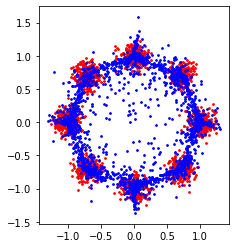

In [48]:
# k = 30, epoch 200
if __name__ == "__main__":
    print("Starting training....")
    train_30 = []
    log_30 = []
    
    for epoch in tqdm(range(1, args.epochs + 1)):
      #  train(epoch)
        a,b= train(epoch)
        train_30.append(a)
        log_30.append(b)
        
  
    print("train1", train_30, log_30)


    gt = next(train_loader)
        
    with torch.no_grad():
        #sample = torch.randn(2048, K).to(device)
        #out = model.decode(sample).cpu().numpy()
        out1 = model.sample()
        recon = model(gt)[0].cpu().numpy()

    rx,ry = recon[:,0], recon[:,1]
        
    gt = gt.cpu().numpy()
    gx, gy = gt[:,0], gt[:,1]
        
    xs, ys = out1[:,0], out1[:,1]

    plt.scatter(gx, gy, c = 'red', s=3)
    plt.scatter(xs, ys, c = 'blue', s=3)
    plt.axes().set_aspect('equal')
    plt.show()
    
#    st()

In [30]:
train_30 = [0.2773541320860386, 0.17834901109337806, 0.12957105867564678, 0.12359359204769134, 0.1218687903881073, 0.11986209191381932, 0.11796163603663444, 0.11646959379315376, 0.11488930821418762, 0.11312264062464238, 0.1115620145201683, 0.10986714281141757, 0.108639510050416, 0.10745594225823879, 0.10649109311401844, 0.10599645547568798, 0.10565495550632477, 0.1053083161264658, 0.10492053896188736, 0.10504720404744149, 0.10454779900610447, 0.10461710445582867, 0.10454016335308552, 0.10443559095263481, 0.10460219860076904, 0.10437201760709286, 0.1043309846520424, 0.10432775847613812, 0.10408788092434407, 0.10410431891679764, 0.10379890531301499, 0.10372410461306572, 0.10368935093283653, 0.10384588055312634, 0.10374969594180584, 0.10375919751822948, 0.10393625177443028, 0.10376318611204624, 0.10371701665222645, 0.10382473625242711, 0.10383999668061733, 0.10365977436304093, 0.10368375144898892, 0.10372569963335991, 0.10374277867376805, 0.10370289072394372, 0.10355730906128884, 0.1035458305478096, 0.10363909393548966, 0.10350081086158752, 0.10364280864596367, 0.10375732958316802, 0.10369411528110505, 0.10366057381033897, 0.10366069465875626, 0.10364596858620644, 0.10382166430354119, 0.1039630687236786, 0.1035523497313261, 0.10356130123138428, 0.10373371608555317, 0.10361722648143769, 0.10368043161928654, 0.10368131726980209, 0.10342517800629139, 0.10354054361581802, 0.10386423006653786, 0.10348797202110291, 0.10383000575006009, 0.10366279795765877, 0.10361272223293781, 0.1036542135477066, 0.10369190603494643, 0.10349163435399532, 0.10363269843161106, 0.10376156970858574, 0.10362402245402336, 0.1038067514449358, 0.10374929711222648, 0.10364553712308407, 0.10367701269686222, 0.10359748907387256, 0.10379002586007119, 0.10378354154527188, 0.10367438524961471, 0.1036435380578041, 0.10353998102247715, 0.10347704328596592, 0.10348038472235203, 0.10376749746501446, 0.1035772193223238, 0.10367273643612862, 0.10368739411234856, 0.1036127433180809, 0.10371803022921085, 0.10354808762669564, 0.10387423679232598, 0.10374739721417427, 0.10383105307817458, 0.10362336128950118, 0.10366147816181183, 0.10359049290418625, 0.10351686045527458, 0.1036877317726612, 0.10366516895592212, 0.10375988438725471, 0.10349770531058311, 0.10359174959361553, 0.10373704589903354, 0.10359872683882713, 0.10360130019485951, 0.10382316522300243, 0.10364056006073952, 0.10372678063809872, 0.10378589272499085, 0.10371805638074875, 0.1034537210315466, 0.10374778665602208, 0.10364719212055207, 0.10377361059188843, 0.10364412792026996, 0.10364639438688755, 0.10367018222808838, 0.10363970063626766, 0.10364955700933934, 0.10364378899335862, 0.10383729577064514, 0.10361561931669712, 0.10364060670137405, 0.10367115095257759, 0.10372332997620105, 0.10373050607740879, 0.10355324484407902, 0.10350681595504284, 0.10354868352413177, 0.10364375986158848, 0.10372288547456264, 0.10369172491133213, 0.10382409945130348, 0.10364409245550632, 0.1035743810236454, 0.10380028881132602, 0.10368530958890915, 0.10365068294107914, 0.1036550971865654, 0.10362252041697502, 0.10363026291131973, 0.10364665627479554, 0.1034511013329029, 0.10357354715466499, 0.10342209041118622, 0.10370126523077489, 0.10371573850512504, 0.10359404660761357, 0.1037124988436699, 0.10368926294147968, 0.10356342352926731, 0.10356419630348683, 0.10346430212259293, 0.10373399510979653, 0.10352064847946167, 0.10376382328569889, 0.10372032471001148, 0.10358120948076248, 0.10354107059538364, 0.10350282810628414, 0.10374889701604843, 0.10368000492453575, 0.1035056047141552, 0.1037649554759264, 0.10369224190711974, 0.10356536149978637, 0.10355600871145726, 0.10374063923954964, 0.10373327113687993, 0.1035865793377161, 0.10379642128944397, 0.10376122415065765, 0.10345566354691982, 0.10352214336395264, 0.10342377595603466, 0.10353929333388806, 0.10374802500009536, 0.10359591990709305, 0.10374988600611687, 0.10363518312573433, 0.10385164618492126, 0.10367663808166981, 0.10349147424101829, 0.10351723097264767, 0.10387014940381051, 0.10354757331311702, 0.10352730989456177, 0.10377267442643642, 0.10350692391395569, 0.10369411028921605, 0.10360444135963917, 0.10361800260841847, 0.10357108227908611, 0.10355887174606324]

In [31]:
train_230 = [0.10366147816181183, 0.10359049290418625, 0.10351686045527458, 0.1036877317726612, 0.10366516895592212, 0.10375988438725471, 0.10349770531058311, 0.10359174959361553, 0.10373704589903354, 0.10359872683882713, 0.10360130019485951, 0.10382316522300243, 0.10364056006073952, 0.10372678063809872, 0.10378589272499085, 0.10371805638074875, 0.1034537210315466, 0.10374778665602208, 0.10364719212055207, 0.10377361059188843, 0.10364412792026996, 0.10364639438688755, 0.10367018222808838, 0.10363970063626766, 0.10364955700933934, 0.10364378899335862, 0.10383729577064514, 0.10361561931669712, 0.10364060670137405, 0.10367115095257759, 0.10372332997620105, 0.10373050607740879, 0.10355324484407902, 0.10350681595504284, 0.10354868352413177, 0.10364375986158848, 0.10372288547456264, 0.10369172491133213, 0.10382409945130348, 0.10364409245550632, 0.1035743810236454, 0.10380028881132602, 0.10368530958890915, 0.10365068294107914, 0.1036550971865654, 0.10362252041697502, 0.10363026291131973, 0.10364665627479554, 0.1034511013329029, 0.10357354715466499, 0.10342209041118622, 0.10370126523077489, 0.10371573850512504, 0.10359404660761357, 0.1037124988436699, 0.10368926294147968, 0.10356342352926731, 0.10356419630348683, 0.10346430212259293, 0.10373399510979653, 0.10352064847946167, 0.10376382328569889, 0.10372032471001148, 0.10358120948076248, 0.10354107059538364, 0.10350282810628414, 0.10374889701604843, 0.10368000492453575, 0.1035056047141552, 0.1037649554759264, 0.10369224190711974, 0.10356536149978637, 0.10355600871145726, 0.10374063923954964, 0.10373327113687993, 0.1035865793377161, 0.10379642128944397, 0.10376122415065765, 0.10345566354691982, 0.10352214336395264, 0.10342377595603466, 0.10353929333388806, 0.10374802500009536, 0.10359591990709305, 0.10374988600611687, 0.10363518312573433, 0.10385164618492126, 0.10367663808166981, 0.10349147424101829, 0.10351723097264767, 0.10387014940381051, 0.10354757331311702, 0.10352730989456177, 0.10377267442643642, 0.10350692391395569, 0.10369411028921605, 0.10360444135963917, 0.10361800260841847, 0.10357108227908611, 0.10355887174606324]

In [32]:
train30 = np.mean(train_230)

In [33]:
log_30 =[-4.015485879675005, -3.1181823562897106, -2.9427956138552904, -2.8155101813273653, -2.650280518020052, -2.517014576923535, -2.3727726298709166, -2.2544843128673433, -2.145773915855584, -1.9960463056327213, -1.8527464392617428, -1.7163900994582333, -1.6695083734722393, -1.521044174471396, -1.514437341431448, -1.4723040238410254, -1.4566816472465134, -1.4141847141455424, -1.424425277759286, -1.4063802541628811, -1.355546041500936, -1.3694895988198161, -1.341952806026353, -1.3431275913284126, -1.3967699071893183, -1.3133757572603084, -1.3277776325129793, -1.325952866467096, -1.3153992739458942, -1.2903823411059925, -1.335914173077037, -1.305707399833496, -1.3060651462769393, -1.3406035090064756, -1.3160254395056272, -1.304858509574287, -1.3172452076537198, -1.316802813949074, -1.308981789617797, -1.320924422204158, -1.3275990369947603, -1.322396564649996, -1.3296358008988456, -1.3054457268761424, -1.2605932940587459, -1.3289764996056523, -1.3076175217893296, -1.2910210635063857, -1.3147754928377102, -1.318478469782477, -1.3019564910625334, -1.3218682070059318, -1.299756023912587, -1.340779470515314, -1.2968358224910737, -1.279302107488645, -1.325949041415382, -1.306861746186593, -1.2883684054270488, -1.328487580822907, -1.2926105397074314, -1.303534055398389, -1.310747860713971, -1.32147470921941, -1.2794048375406821, -1.325065865586194, -1.2999283803141888, -1.3034639969121364, -1.3052836461649444, -1.3119787865646688, -1.3222396331337578, -1.3045609244178047, -1.3056462546346568, -1.3041002049875223, -1.3367676760401295, -1.2953335030918005, -1.3106118700163853, -1.3207351206280995, -1.3451339177048378, -1.3116864778098107, -1.3041694236797896, -1.3048894000934483, -1.3389929518438444, -1.295775018957339, -1.3170045143240374, -1.3167484580232136, -1.3189274339552957, -1.3102250887202822, -1.2953516913785939, -1.3225586041945032, -1.3164347168044643, -1.2999204412487628, -1.3373678552100174, -1.300525531313252, -1.3034870889951573, -1.310182182789113, -1.2865261024026768, -1.3117453516863926, -1.3154571867439344, -1.320667922361769, -1.3135912756078012, -1.3082382654049698, -1.3023319875786936, -1.2955014551964283, -1.3420464373309957, -1.317981016340879, -1.3135633159376914, -1.3246715306532502, -1.3063372686477424, -1.3254759926726727, -1.3340254702115515, -1.3044169963107102, -1.3280146248201232, -1.3181694764581768, -1.308280795340945, -1.3075669941485266, -1.316475360000935, -1.2600875534100031, -1.2999471499750008, -1.2904987101837198, -1.3381469276349094, -1.3131248445419197, -1.3201038775972225, -1.307521907528097, -1.3222141954678452, -1.3011491546722693, -1.317584238484243, -1.326469439464122, -1.3260629887477506, -1.3385506837208003, -1.315215038766992, -1.2969971325429528, -1.3026580310268936, -1.311182547868159, -1.3001488866308635, -1.3113635946117967, -1.3075000228464688, -1.3232956449998845, -1.3078861622427467, -1.3106960713529472, -1.3180018150154227, -1.3075559226725266, -1.30265888339018, -1.3061370573344488, -1.2993369785620583, -1.3184875293489342, -1.2924516852685781, -1.3260117706284307, -1.3084757318043814, -1.3103677656171777, -1.289891895972306, -1.2862471488022549, -1.3015252062835199, -1.3080759418637111, -1.2937222966587052, -1.3138187953426232, -1.3043873287024206, -1.3169495092869372, -1.32013398749675, -1.2848146015858093, -1.309127200832267, -1.2888348520336774, -1.3096579730869131, -1.3061599584512344, -1.2911709933743054, -1.3154357952578382, -1.30832608541038, -1.296848423012813, -1.2999022762370156, -1.297655563893265, -1.3183410007999008, -1.3061434682772313, -1.2986754708760002, -1.296898269865474, -1.302982077132838, -1.3325537063358364, -1.2989542236511702, -1.3083513212252436, -1.315615634426611, -1.3195471530870653, -1.3388397342791145, -1.302642267094457, -1.3040659927779983, -1.3092534257339385, -1.3407794738587397, -1.3216740778798552, -1.317838103640594, -1.2803577213126849, -1.3141335696296856, -1.302245852367602, -1.3133312026121786, -1.2959940428175294, -1.3090585237434547, -1.3220124144575238, -1.3341564402764343, -1.3119140657213026, -1.2940572325144917, -1.3071331652785574, -1.3108620461065819, -1.3058908136879528]

In [34]:
log_230 = [ -1.3135912756078012, -1.3082382654049698, -1.3023319875786936, -1.2955014551964283, -1.3420464373309957, -1.317981016340879, -1.3135633159376914, -1.3246715306532502, -1.3063372686477424, -1.3254759926726727, -1.3340254702115515, -1.3044169963107102, -1.3280146248201232, -1.3181694764581768, -1.308280795340945, -1.3075669941485266, -1.316475360000935, -1.2600875534100031, -1.2999471499750008, -1.2904987101837198, -1.3381469276349094, -1.3131248445419197, -1.3201038775972225, -1.307521907528097, -1.3222141954678452, -1.3011491546722693, -1.317584238484243, -1.326469439464122, -1.3260629887477506, -1.3385506837208003, -1.315215038766992, -1.2969971325429528, -1.3026580310268936, -1.311182547868159, -1.3001488866308635, -1.3113635946117967, -1.3075000228464688, -1.3232956449998845, -1.3078861622427467, -1.3106960713529472, -1.3180018150154227, -1.3075559226725266, -1.30265888339018, -1.3061370573344488, -1.2993369785620583, -1.3184875293489342, -1.2924516852685781, -1.3260117706284307, -1.3084757318043814, -1.3103677656171777, -1.289891895972306, -1.2862471488022549, -1.3015252062835199, -1.3080759418637111, -1.2937222966587052, -1.3138187953426232, -1.3043873287024206, -1.3169495092869372, -1.32013398749675, -1.2848146015858093, -1.309127200832267, -1.2888348520336774, -1.3096579730869131, -1.3061599584512344, -1.2911709933743054, -1.3154357952578382, -1.30832608541038, -1.296848423012813, -1.2999022762370156, -1.297655563893265, -1.3183410007999008, -1.3061434682772313, -1.2986754708760002, -1.296898269865474, -1.302982077132838, -1.3325537063358364, -1.2989542236511702, -1.3083513212252436, -1.315615634426611, -1.3195471530870653, -1.3388397342791145, -1.302642267094457, -1.3040659927779983, -1.3092534257339385, -1.3407794738587397, -1.3216740778798552, -1.317838103640594, -1.2803577213126849, -1.3141335696296856, -1.302245852367602, -1.3133312026121786, -1.2959940428175294, -1.3090585237434547, -1.3220124144575238, -1.3341564402764343, -1.3119140657213026, -1.2940572325144917, -1.3071331652785574, -1.3108620461065819, -1.3058908136879528]

In [35]:
log30 = np.mean(log_230)

  0%|          | 0/200 [00:00<?, ?it/s]

Starting training....


  0%|          | 1/200 [00:13<46:13, 13.93s/it]

Epoch  average reconstruction error   : 1 0.23360270172357558
 likelihood  : -4.192149071159955


  1%|          | 2/200 [00:28<47:02, 14.26s/it]

Epoch  average reconstruction error   : 2 0.14653771676123142
 likelihood  : -3.051478400999673


  2%|▏         | 3/200 [00:43<47:06, 14.35s/it]

Epoch  average reconstruction error   : 3 0.11167002663016319
 likelihood  : -2.891789306339758


  2%|▏         | 4/200 [00:56<45:58, 14.07s/it]

Epoch  average reconstruction error   : 4 0.10078203476965428
 likelihood  : -2.870216232530415


  2%|▎         | 5/200 [01:09<44:35, 13.72s/it]

Epoch  average reconstruction error   : 5 0.0992840463668108
 likelihood  : -2.7665894473821027


  3%|▎         | 6/200 [01:22<43:31, 13.46s/it]

Epoch  average reconstruction error   : 6 0.09783160157501697
 likelihood  : -2.6779869761240005


  4%|▎         | 7/200 [01:33<40:18, 12.53s/it]

Epoch  average reconstruction error   : 7 0.09659772224724293
 likelihood  : -2.501185465277104


  4%|▍         | 8/200 [01:58<52:17, 16.34s/it]

Epoch  average reconstruction error   : 8 0.09559480085968972
 likelihood  : -2.3866335278112407


  4%|▍         | 9/200 [02:12<49:38, 15.60s/it]

Epoch  average reconstruction error   : 9 0.09460082061588765
 likelihood  : -2.385639324250854


  5%|▌         | 10/200 [02:22<44:20, 14.00s/it]

Epoch  average reconstruction error   : 10 0.09362021312117577
 likelihood  : -2.2729579993854223


  6%|▌         | 11/200 [02:33<41:38, 13.22s/it]

Epoch  average reconstruction error   : 11 0.0927904163300991
 likelihood  : -2.178055560675867


  6%|▌         | 12/200 [02:46<41:00, 13.09s/it]

Epoch  average reconstruction error   : 12 0.09179494321346283
 likelihood  : -2.046444143992055


  6%|▋         | 13/200 [02:59<40:55, 13.13s/it]

Epoch  average reconstruction error   : 13 0.09011370174586773
 likelihood  : -1.897761333476907


  7%|▋         | 14/200 [03:10<38:04, 12.28s/it]

Epoch  average reconstruction error   : 14 0.0884858513623476
 likelihood  : -1.7451940137802575


  8%|▊         | 15/200 [03:22<38:14, 12.40s/it]

Epoch  average reconstruction error   : 15 0.08685667559504509
 likelihood  : -1.6452855425702024


  8%|▊         | 16/200 [03:35<38:24, 12.53s/it]

Epoch  average reconstruction error   : 16 0.08587084367871284
 likelihood  : -1.5523433589887707


  8%|▊         | 17/200 [03:48<38:27, 12.61s/it]

Epoch  average reconstruction error   : 17 0.08508624494075775
 likelihood  : -1.5214218719022081


  9%|▉         | 18/200 [03:58<36:01, 11.88s/it]

Epoch  average reconstruction error   : 18 0.08461670123040677
 likelihood  : -1.4578718743223695


 10%|▉         | 19/200 [04:11<37:11, 12.33s/it]

Epoch  average reconstruction error   : 19 0.08438740499317646
 likelihood  : -1.4450566618223253


 10%|█         | 20/200 [04:24<37:19, 12.44s/it]

Epoch  average reconstruction error   : 20 0.0841206331551075
 likelihood  : -1.409985275040601


 10%|█         | 21/200 [04:37<37:34, 12.60s/it]

Epoch  average reconstruction error   : 21 0.08395830668509006
 likelihood  : -1.38881550451726


 11%|█         | 22/200 [04:49<36:37, 12.35s/it]

Epoch  average reconstruction error   : 22 0.08377946496009826
 likelihood  : -1.3715526710845425


 12%|█▏        | 23/200 [05:14<47:43, 16.18s/it]

Epoch  average reconstruction error   : 23 0.0836687034368515
 likelihood  : -1.3617830187617468


 12%|█▏        | 24/200 [05:27<44:39, 15.23s/it]

Epoch  average reconstruction error   : 24 0.08343774192035198
 likelihood  : -1.373671934823927


 12%|█▎        | 25/200 [05:40<42:17, 14.50s/it]

Epoch  average reconstruction error   : 25 0.08355601444840431
 likelihood  : -1.3579504558173736


 13%|█▎        | 26/200 [05:50<38:14, 13.19s/it]

Epoch  average reconstruction error   : 26 0.08338462561368942
 likelihood  : -1.353651772709461


 14%|█▎        | 27/200 [06:02<37:18, 12.94s/it]

Epoch  average reconstruction error   : 27 0.08324209414422512
 likelihood  : -1.3516000350160184


 14%|█▍        | 28/200 [06:15<36:51, 12.86s/it]

Epoch  average reconstruction error   : 28 0.08314396671950817
 likelihood  : -1.346667451929054


 14%|█▍        | 29/200 [06:28<37:01, 12.99s/it]

Epoch  average reconstruction error   : 29 0.08327975243330002
 likelihood  : -1.3442044443498302


 15%|█▌        | 30/200 [06:38<34:21, 12.13s/it]

Epoch  average reconstruction error   : 30 0.08316212713718414
 likelihood  : -1.3211829897575689


 16%|█▌        | 31/200 [06:49<33:12, 11.79s/it]

Epoch  average reconstruction error   : 31 0.08315749801695346
 likelihood  : -1.3200855643741323


 16%|█▌        | 32/200 [07:03<34:10, 12.21s/it]

Epoch  average reconstruction error   : 32 0.08311159037053585
 likelihood  : -1.330489626302959


 16%|█▋        | 33/200 [07:15<34:30, 12.40s/it]

Epoch  average reconstruction error   : 33 0.08298578388988971
 likelihood  : -1.3366993932946554
Epoch    34: reducing learning rate of group 0 to 1.0000e-04.


 17%|█▋        | 34/200 [07:26<33:03, 11.95s/it]

Epoch  average reconstruction error   : 34 0.08297623455524444
 likelihood  : -1.328945906479617


 18%|█▊        | 35/200 [07:37<32:09, 11.69s/it]

Epoch  average reconstruction error   : 35 0.08271043263375759
 likelihood  : -1.3146483882530795


 18%|█▊        | 36/200 [07:59<39:46, 14.55s/it]

Epoch  average reconstruction error   : 36 0.08249519303441048
 likelihood  : -1.3318129143850044


 18%|█▊        | 37/200 [08:10<37:14, 13.71s/it]

Epoch  average reconstruction error   : 37 0.08262235879898071
 likelihood  : -1.3298863019664906


 19%|█▉        | 38/200 [08:23<36:13, 13.42s/it]

Epoch  average reconstruction error   : 38 0.08254415638744832
 likelihood  : -1.3098483958558975


 20%|█▉        | 39/200 [08:37<36:09, 13.47s/it]

Epoch  average reconstruction error   : 39 0.08281962029635906
 likelihood  : -1.306584155484627


 20%|██        | 40/200 [08:47<33:20, 12.50s/it]

Epoch  average reconstruction error   : 40 0.08251341141760349
 likelihood  : -1.28377194350407


 20%|██        | 41/200 [08:59<32:27, 12.25s/it]

Epoch  average reconstruction error   : 41 0.08257261455059052
 likelihood  : -1.3007036913826555


 21%|██        | 42/200 [09:11<32:34, 12.37s/it]

Epoch  average reconstruction error   : 42 0.08263352170586585
 likelihood  : -1.2918993784089263


 22%|██▏       | 43/200 [09:24<32:36, 12.46s/it]

Epoch  average reconstruction error   : 43 0.0826023881882429
 likelihood  : -1.3237155475252398


 22%|██▏       | 44/200 [09:41<36:07, 13.90s/it]

Epoch  average reconstruction error   : 44 0.0826191970705986
 likelihood  : -1.3017185903479944


 22%|██▎       | 45/200 [09:51<32:59, 12.77s/it]

Epoch  average reconstruction error   : 45 0.08259176321327687
 likelihood  : -1.2960989680398958
Epoch    46: reducing learning rate of group 0 to 1.0000e-05.


 23%|██▎       | 46/200 [10:03<31:36, 12.31s/it]

Epoch  average reconstruction error   : 46 0.08250051811337471
 likelihood  : -1.3267262002518554


 24%|██▎       | 47/200 [10:15<31:37, 12.40s/it]

Epoch  average reconstruction error   : 47 0.08262055426836014
 likelihood  : -1.3109764588650157


 24%|██▍       | 48/200 [10:28<31:40, 12.50s/it]

Epoch  average reconstruction error   : 48 0.08246399581432343
 likelihood  : -1.2863203623886617


 24%|██▍       | 49/200 [10:50<39:00, 15.50s/it]

Epoch  average reconstruction error   : 49 0.08251552529633045
 likelihood  : -1.2992228088001982


 25%|██▌       | 50/200 [11:03<36:46, 14.71s/it]

Epoch  average reconstruction error   : 50 0.08238509707152844
 likelihood  : -1.2877355557817611


 26%|██▌       | 51/200 [11:16<34:58, 14.08s/it]

Epoch  average reconstruction error   : 51 0.08258464261889457
 likelihood  : -1.3304178933917181


 26%|██▌       | 52/200 [11:26<31:58, 12.96s/it]

Epoch  average reconstruction error   : 52 0.08233567230403423
 likelihood  : -1.2882132175826064


 26%|██▋       | 53/200 [11:37<30:22, 12.40s/it]

Epoch  average reconstruction error   : 53 0.08244352266192437
 likelihood  : -1.3168441352027012


 27%|██▋       | 54/200 [11:51<30:59, 12.74s/it]

Epoch  average reconstruction error   : 54 0.08242730282247067
 likelihood  : -1.2953114593911204


 28%|██▊       | 55/200 [12:04<30:58, 12.82s/it]

Epoch  average reconstruction error   : 55 0.082423522695899
 likelihood  : -1.289523186818184


 28%|██▊       | 56/200 [12:14<28:48, 12.00s/it]

Epoch  average reconstruction error   : 56 0.08246477879583836
 likelihood  : -1.3055375654335557
Epoch    57: reducing learning rate of group 0 to 1.0000e-06.


 28%|██▊       | 57/200 [12:26<28:53, 12.12s/it]

Epoch  average reconstruction error   : 57 0.0825162323564291
 likelihood  : -1.300272299745505


 29%|██▉       | 58/200 [12:39<29:08, 12.31s/it]

Epoch  average reconstruction error   : 58 0.0825778193026781
 likelihood  : -1.3079411820685722


 30%|██▉       | 59/200 [12:52<29:14, 12.44s/it]

Epoch  average reconstruction error   : 59 0.0823946463316679
 likelihood  : -1.3133086332390533


 30%|███       | 60/200 [13:03<27:55, 11.97s/it]

Epoch  average reconstruction error   : 60 0.08250135749578476
 likelihood  : -1.3008847686518095


 30%|███       | 61/200 [13:15<27:43, 11.97s/it]

Epoch  average reconstruction error   : 61 0.08233102671802044
 likelihood  : -1.276096092521967


 31%|███       | 62/200 [13:42<38:01, 16.53s/it]

Epoch  average reconstruction error   : 62 0.0823932434618473
 likelihood  : -1.2876880085863485


 32%|███▏      | 63/200 [13:55<35:09, 15.40s/it]

Epoch  average reconstruction error   : 63 0.08259330481290818
 likelihood  : -1.292127072274742


 32%|███▏      | 64/200 [14:06<32:02, 14.14s/it]

Epoch  average reconstruction error   : 64 0.08262329861521721
 likelihood  : -1.3296894694039727


 32%|███▎      | 65/200 [14:19<30:52, 13.72s/it]

Epoch  average reconstruction error   : 65 0.08252011723816395
 likelihood  : -1.3148905522435994


 33%|███▎      | 66/200 [14:31<30:01, 13.44s/it]

Epoch  average reconstruction error   : 66 0.08258242160081863
 likelihood  : -1.326894376855102


 34%|███▎      | 67/200 [14:46<30:20, 13.69s/it]

Epoch  average reconstruction error   : 67 0.08263342782855033
 likelihood  : -1.2987063232436915


 34%|███▍      | 68/200 [14:58<29:28, 13.40s/it]

Epoch  average reconstruction error   : 68 0.08248480066657066
 likelihood  : -1.2989989106075246


 34%|███▍      | 69/200 [15:09<27:36, 12.65s/it]

Epoch  average reconstruction error   : 69 0.08267959408462047
 likelihood  : -1.2893843133642129


 35%|███▌      | 70/200 [15:22<27:30, 12.69s/it]

Epoch  average reconstruction error   : 70 0.08255090534687043
 likelihood  : -1.3173704163882411


 36%|███▌      | 71/200 [15:36<27:46, 12.92s/it]

Epoch  average reconstruction error   : 71 0.08264477878808975
 likelihood  : -1.299458443875579


 36%|███▌      | 72/200 [15:48<27:25, 12.85s/it]

Epoch  average reconstruction error   : 72 0.08252317242324353
 likelihood  : -1.3051448966444446


 36%|███▋      | 73/200 [15:58<25:26, 12.02s/it]

Epoch  average reconstruction error   : 73 0.08247315376996994
 likelihood  : -1.29798220050893


 37%|███▋      | 74/200 [16:09<24:42, 11.77s/it]

Epoch  average reconstruction error   : 74 0.08250687681138516
 likelihood  : -1.300469515815908


 38%|███▊      | 75/200 [16:35<32:53, 15.78s/it]

Epoch  average reconstruction error   : 75 0.08263487078249454
 likelihood  : -1.3013643514849709


 38%|███▊      | 76/200 [16:45<29:11, 14.13s/it]

Epoch  average reconstruction error   : 76 0.0825695188343525
 likelihood  : -1.3151705272645131


 38%|███▊      | 77/200 [16:58<28:24, 13.86s/it]

Epoch  average reconstruction error   : 77 0.08259601809084416
 likelihood  : -1.2964994867580304


 39%|███▉      | 78/200 [17:11<27:27, 13.50s/it]

Epoch  average reconstruction error   : 78 0.08259070187807083
 likelihood  : -1.337453958545868


 40%|███▉      | 79/200 [17:24<27:12, 13.49s/it]

Epoch  average reconstruction error   : 79 0.08271176449954509
 likelihood  : -1.3050070543603969


 40%|████      | 80/200 [17:34<25:00, 12.50s/it]

Epoch  average reconstruction error   : 80 0.08262884698808193
 likelihood  : -1.2859752191719567


 40%|████      | 81/200 [17:47<24:38, 12.43s/it]

Epoch  average reconstruction error   : 81 0.0825332573056221
 likelihood  : -1.3192270096279906


 41%|████      | 82/200 [17:59<24:34, 12.49s/it]

Epoch  average reconstruction error   : 82 0.08249931134283543
 likelihood  : -1.2850286444754557


 42%|████▏     | 83/200 [18:12<24:27, 12.54s/it]

Epoch  average reconstruction error   : 83 0.08247834347188472
 likelihood  : -1.3068160316543158


 42%|████▏     | 84/200 [18:22<22:49, 11.81s/it]

Epoch  average reconstruction error   : 84 0.08257784634828567
 likelihood  : -1.2901768795072053


 42%|████▎     | 85/200 [18:35<23:19, 12.17s/it]

Epoch  average reconstruction error   : 85 0.08245885916054249
 likelihood  : -1.3081638214796585


 43%|████▎     | 86/200 [18:48<23:25, 12.33s/it]

Epoch  average reconstruction error   : 86 0.08253314048051834
 likelihood  : -1.3129074215854903


 44%|████▎     | 87/200 [19:01<23:27, 12.46s/it]

Epoch  average reconstruction error   : 87 0.08248397655785084
 likelihood  : -1.3002120562867197


 44%|████▍     | 88/200 [19:23<28:40, 15.36s/it]

Epoch  average reconstruction error   : 88 0.08251955807209015
 likelihood  : -1.2935133411556925


 44%|████▍     | 89/200 [19:37<27:46, 15.01s/it]

Epoch  average reconstruction error   : 89 0.08258113764226437
 likelihood  : -1.302898034263406


 45%|████▌     | 90/200 [19:50<26:24, 14.40s/it]

Epoch  average reconstruction error   : 90 0.08239057004451751
 likelihood  : -1.293961146510719


 46%|████▌     | 91/200 [20:03<25:39, 14.12s/it]

Epoch  average reconstruction error   : 91 0.08236506730318069
 likelihood  : -1.2844923032107176


 46%|████▌     | 92/200 [20:13<23:14, 12.91s/it]

Epoch  average reconstruction error   : 92 0.08276682920753956
 likelihood  : -1.2886367590115118


 46%|████▋     | 93/200 [20:26<22:54, 12.85s/it]

Epoch  average reconstruction error   : 93 0.08249785251915455
 likelihood  : -1.3180055041635126


 47%|████▋     | 94/200 [20:39<22:48, 12.91s/it]

Epoch  average reconstruction error   : 94 0.08240842930972576
 likelihood  : -1.3101854789492229


 48%|████▊     | 95/200 [20:52<22:35, 12.91s/it]

Epoch  average reconstruction error   : 95 0.08243985310196876
 likelihood  : -1.3185369997300707


 48%|████▊     | 96/200 [21:02<20:54, 12.06s/it]

Epoch  average reconstruction error   : 96 0.08247467912733555
 likelihood  : -1.305261411323267


 48%|████▊     | 97/200 [21:13<20:17, 11.82s/it]

Epoch  average reconstruction error   : 97 0.08241182960569858
 likelihood  : -1.3051383496876379


 49%|████▉     | 98/200 [21:26<20:34, 12.10s/it]

Epoch  average reconstruction error   : 98 0.08247515536844731
 likelihood  : -1.287240916519114


 50%|████▉     | 99/200 [21:40<21:01, 12.49s/it]

Epoch  average reconstruction error   : 99 0.08249179124832154
 likelihood  : -1.3068818284850636


 50%|█████     | 100/200 [21:51<20:06, 12.06s/it]

Epoch  average reconstruction error   : 100 0.08267932549118996
 likelihood  : -1.2954509304046646


 50%|█████     | 101/200 [22:17<27:04, 16.41s/it]

Epoch  average reconstruction error   : 101 0.08253159694373607
 likelihood  : -1.3075884122012913


 51%|█████     | 102/200 [22:30<25:08, 15.39s/it]

Epoch  average reconstruction error   : 102 0.08255526505410671
 likelihood  : -1.3008619671321504


 52%|█████▏    | 103/200 [22:43<23:33, 14.57s/it]

Epoch  average reconstruction error   : 103 0.08260088920593261
 likelihood  : -1.3060012726693513


 52%|█████▏    | 104/200 [22:54<21:33, 13.47s/it]

Epoch  average reconstruction error   : 104 0.08242910519242287
 likelihood  : -1.3075719075956898


 52%|█████▎    | 105/200 [23:06<20:57, 13.23s/it]

Epoch  average reconstruction error   : 105 0.08249961450695992
 likelihood  : -1.2883196000149963


 53%|█████▎    | 106/200 [23:19<20:27, 13.06s/it]

Epoch  average reconstruction error   : 106 0.08252906702458858
 likelihood  : -1.308479108047949


 54%|█████▎    | 107/200 [23:32<20:07, 12.98s/it]

Epoch  average reconstruction error   : 107 0.08257396280765533
 likelihood  : -1.3249731218381866


 54%|█████▍    | 108/200 [23:42<18:34, 12.11s/it]

Epoch  average reconstruction error   : 108 0.0825444382429123
 likelihood  : -1.2989552528718862


 55%|█████▍    | 109/200 [23:55<18:51, 12.43s/it]

Epoch  average reconstruction error   : 109 0.08257128186523914
 likelihood  : -1.3044032947079058


 55%|█████▌    | 110/200 [24:09<19:03, 12.70s/it]

Epoch  average reconstruction error   : 110 0.08241278551518917
 likelihood  : -1.3048350592146503


 56%|█████▌    | 111/200 [24:21<18:47, 12.67s/it]

Epoch  average reconstruction error   : 111 0.08260659776628017
 likelihood  : -1.2980165222372457


 56%|█████▌    | 112/200 [24:31<17:30, 11.93s/it]

Epoch  average reconstruction error   : 112 0.08260518543422223
 likelihood  : -1.3054581868002975


 56%|█████▋    | 113/200 [24:56<23:02, 15.89s/it]

Epoch  average reconstruction error   : 113 0.08256553620100021
 likelihood  : -1.2994146631439407


 57%|█████▋    | 114/200 [25:10<21:42, 15.15s/it]

Epoch  average reconstruction error   : 114 0.08250076875090599
 likelihood  : -1.297437148716365


 57%|█████▊    | 115/200 [25:22<20:07, 14.21s/it]

Epoch  average reconstruction error   : 115 0.08250464238226414
 likelihood  : -1.305039475288694


 58%|█████▊    | 116/200 [25:32<18:15, 13.04s/it]

Epoch  average reconstruction error   : 116 0.08250739678740501
 likelihood  : -1.2913277281077966


 58%|█████▊    | 117/200 [25:45<17:57, 12.98s/it]

Epoch  average reconstruction error   : 117 0.08252533592283726
 likelihood  : -1.2958872590158124


 59%|█████▉    | 118/200 [25:58<17:41, 12.95s/it]

Epoch  average reconstruction error   : 118 0.08247805595397949
 likelihood  : -1.2799835433632918


 60%|█████▉    | 119/200 [26:11<17:27, 12.93s/it]

Epoch  average reconstruction error   : 119 0.08251207895576954
 likelihood  : -1.3042476755841166


 60%|██████    | 120/200 [26:21<16:06, 12.08s/it]

Epoch  average reconstruction error   : 120 0.08250125020742416
 likelihood  : -1.3127995031750332


 60%|██████    | 121/200 [26:34<16:08, 12.26s/it]

Epoch  average reconstruction error   : 121 0.08236167751252652
 likelihood  : -1.3028968859251797


 61%|██████    | 122/200 [26:46<16:05, 12.38s/it]

Epoch  average reconstruction error   : 122 0.08252102121710778
 likelihood  : -1.315105765942806


 62%|██████▏   | 123/200 [26:59<15:59, 12.46s/it]

Epoch  average reconstruction error   : 123 0.0824330023676157
 likelihood  : -1.3074761962005694


 62%|██████▏   | 124/200 [27:10<15:17, 12.08s/it]

Epoch  average reconstruction error   : 124 0.08244450867176056
 likelihood  : -1.306076454141885


 62%|██████▎   | 125/200 [27:23<15:29, 12.40s/it]

Epoch  average reconstruction error   : 125 0.08253871247172356
 likelihood  : -1.2957746558481786


 63%|██████▎   | 126/200 [27:51<20:50, 16.90s/it]

Epoch  average reconstruction error   : 126 0.08262129887938499
 likelihood  : -1.2839410357311682


 64%|██████▎   | 127/200 [28:03<19:03, 15.67s/it]

Epoch  average reconstruction error   : 127 0.0824440161883831
 likelihood  : -1.3089596973210904


 64%|██████▍   | 128/200 [28:14<16:48, 14.00s/it]

Epoch  average reconstruction error   : 128 0.08255209758877755
 likelihood  : -1.2947962318229898


 64%|██████▍   | 129/200 [28:27<16:23, 13.85s/it]

Epoch  average reconstruction error   : 129 0.0824733155965805
 likelihood  : -1.2918306743684007


 65%|██████▌   | 130/200 [28:40<15:46, 13.52s/it]

Epoch  average reconstruction error   : 130 0.08252606473863125
 likelihood  : -1.3147720490868688


 66%|██████▌   | 131/200 [28:54<15:55, 13.84s/it]

Epoch  average reconstruction error   : 131 0.08246628649532795
 likelihood  : -1.3063538688833694


 66%|██████▌   | 132/200 [29:13<17:17, 15.26s/it]

Epoch  average reconstruction error   : 132 0.08262882716953754
 likelihood  : -1.2994184592412479


 66%|██████▋   | 133/200 [29:35<19:13, 17.21s/it]

Epoch  average reconstruction error   : 133 0.08243433721363544
 likelihood  : -1.2923783812051872


 67%|██████▋   | 134/200 [30:18<27:40, 25.16s/it]

Epoch  average reconstruction error   : 134 0.08250608429312706
 likelihood  : -1.3179201425749234


 68%|██████▊   | 135/200 [30:55<31:05, 28.71s/it]

Epoch  average reconstruction error   : 135 0.08250808663666248
 likelihood  : -1.316696225969752


 68%|██████▊   | 136/200 [31:51<39:05, 36.65s/it]

Epoch  average reconstruction error   : 136 0.08245884619653225
 likelihood  : -1.2989023314319315


 68%|██████▊   | 137/200 [32:24<37:24, 35.63s/it]

Epoch  average reconstruction error   : 137 0.08238656178116799
 likelihood  : -1.279051555925749


 69%|██████▉   | 138/200 [33:11<40:32, 39.24s/it]

Epoch  average reconstruction error   : 138 0.08253503404557705
 likelihood  : -1.3303013975975668


 70%|██████▉   | 139/200 [35:17<1:06:05, 65.01s/it]

Epoch  average reconstruction error   : 139 0.08251183614134788
 likelihood  : -1.3019948381234197


 70%|███████   | 140/200 [37:17<1:21:28, 81.47s/it]

Epoch  average reconstruction error   : 140 0.08242901809513568
 likelihood  : -1.300872077871492


 70%|███████   | 141/200 [39:15<1:31:05, 92.63s/it]

Epoch  average reconstruction error   : 141 0.08260477796196937
 likelihood  : -1.3077156865011714


 71%|███████   | 142/200 [40:21<1:21:48, 84.64s/it]

Epoch  average reconstruction error   : 142 0.08256443344056606
 likelihood  : -1.3057506784274955


 72%|███████▏  | 143/200 [40:53<1:05:30, 68.95s/it]

Epoch  average reconstruction error   : 143 0.08240585006773472
 likelihood  : -1.3069736384175488


 72%|███████▏  | 144/200 [41:09<49:22, 52.91s/it]  

Epoch  average reconstruction error   : 144 0.08253415606915951
 likelihood  : -1.3073566995685075


 72%|███████▎  | 145/200 [41:24<38:02, 41.50s/it]

Epoch  average reconstruction error   : 145 0.0825321414321661
 likelihood  : -1.3093788766258823


 73%|███████▎  | 146/200 [41:37<29:33, 32.85s/it]

Epoch  average reconstruction error   : 146 0.08262543708086013
 likelihood  : -1.3085740807805109


 74%|███████▎  | 147/200 [41:51<24:01, 27.19s/it]

Epoch  average reconstruction error   : 147 0.08247068658471107
 likelihood  : -1.2933503749561936


 74%|███████▍  | 148/200 [42:17<23:17, 26.88s/it]

Epoch  average reconstruction error   : 148 0.08251731917262077
 likelihood  : -1.3114613556355126


 74%|███████▍  | 149/200 [42:37<21:04, 24.80s/it]

Epoch  average reconstruction error   : 149 0.08239893436431885
 likelihood  : -1.2956357093686648


 75%|███████▌  | 150/200 [43:05<21:28, 25.77s/it]

Epoch  average reconstruction error   : 150 0.0824915037304163
 likelihood  : -1.295042815531953


 76%|███████▌  | 151/200 [43:21<18:38, 22.83s/it]

Epoch  average reconstruction error   : 151 0.08261148661375045
 likelihood  : -1.284261082016752


 76%|███████▌  | 152/200 [43:42<18:01, 22.54s/it]

Epoch  average reconstruction error   : 152 0.08258964404463769
 likelihood  : -1.318699940152164


 76%|███████▋  | 153/200 [44:49<27:59, 35.73s/it]

Epoch  average reconstruction error   : 153 0.08243630520999431
 likelihood  : -1.3143574937130524


 77%|███████▋  | 154/200 [45:13<24:47, 32.34s/it]

Epoch  average reconstruction error   : 154 0.08255138747394085
 likelihood  : -1.3008718070195917


 78%|███████▊  | 155/200 [45:36<21:58, 29.31s/it]

Epoch  average reconstruction error   : 155 0.08259547114372254
 likelihood  : -1.3062908212224666


 78%|███████▊  | 156/200 [45:50<18:10, 24.79s/it]

Epoch  average reconstruction error   : 156 0.08241873130202293
 likelihood  : -1.3238968853848725


 78%|███████▊  | 157/200 [46:11<16:58, 23.69s/it]

Epoch  average reconstruction error   : 157 0.08252887226641178
 likelihood  : -1.2784457191871148


 79%|███████▉  | 158/200 [47:16<25:13, 36.04s/it]

Epoch  average reconstruction error   : 158 0.08245720498263837
 likelihood  : -1.3040715149437583


 80%|███████▉  | 159/200 [47:58<25:50, 37.82s/it]

Epoch  average reconstruction error   : 159 0.08269577287137508
 likelihood  : -1.3091111530796267


 80%|████████  | 160/200 [48:24<22:50, 34.27s/it]

Epoch  average reconstruction error   : 160 0.08261366866528988
 likelihood  : -1.3081792374649854


 80%|████████  | 161/200 [48:53<21:21, 32.85s/it]

Epoch  average reconstruction error   : 161 0.08248598992824555
 likelihood  : -1.3219994963234352


 81%|████████  | 162/200 [49:20<19:39, 31.03s/it]

Epoch  average reconstruction error   : 162 0.08259168714284897
 likelihood  : -1.2728223932431673


 82%|████████▏ | 163/200 [49:42<17:25, 28.24s/it]

Epoch  average reconstruction error   : 163 0.08243216305971146
 likelihood  : -1.3073694114162682


 82%|████████▏ | 164/200 [50:28<20:14, 33.75s/it]

Epoch  average reconstruction error   : 164 0.08266595967113971
 likelihood  : -1.2907514803003366


 82%|████████▎ | 165/200 [51:03<19:50, 34.03s/it]

Epoch  average reconstruction error   : 165 0.08244455441832542
 likelihood  : -1.3372341681632105


 83%|████████▎ | 166/200 [51:18<16:05, 28.40s/it]

Epoch  average reconstruction error   : 166 0.08263716645538807
 likelihood  : -1.3139125026902736


 84%|████████▎ | 167/200 [51:31<13:02, 23.71s/it]

Epoch  average reconstruction error   : 167 0.0826325599104166
 likelihood  : -1.2887664329850146


 84%|████████▍ | 168/200 [51:42<10:36, 19.89s/it]

Epoch  average reconstruction error   : 168 0.08246682092547417
 likelihood  : -1.3096002048808626


 84%|████████▍ | 169/200 [51:55<09:10, 17.77s/it]

Epoch  average reconstruction error   : 169 0.082396130412817
 likelihood  : -1.297727341519942


 85%|████████▌ | 170/200 [52:08<08:08, 16.28s/it]

Epoch  average reconstruction error   : 170 0.08254146426916123
 likelihood  : -1.313031645185173


 86%|████████▌ | 171/200 [52:23<07:41, 15.90s/it]

Epoch  average reconstruction error   : 171 0.08251179076731205
 likelihood  : -1.2926848470859245


 86%|████████▌ | 172/200 [52:36<06:59, 14.97s/it]

Epoch  average reconstruction error   : 172 0.08256496265530586
 likelihood  : -1.2980467007934489


 86%|████████▋ | 173/200 [52:47<06:11, 13.76s/it]

Epoch  average reconstruction error   : 173 0.08264294438064099
 likelihood  : -1.302975293043369


 87%|████████▋ | 174/200 [53:13<07:36, 17.55s/it]

Epoch  average reconstruction error   : 174 0.08248218126595021
 likelihood  : -1.2814927010310009


 88%|████████▊ | 175/200 [53:26<06:42, 16.12s/it]

Epoch  average reconstruction error   : 175 0.08248545490205288
 likelihood  : -1.3159546227105525


 88%|████████▊ | 176/200 [53:36<05:44, 14.36s/it]

Epoch  average reconstruction error   : 176 0.08239010110497474
 likelihood  : -1.2851376615685763


 88%|████████▊ | 177/200 [53:47<05:05, 13.27s/it]

Epoch  average reconstruction error   : 177 0.0824716629832983
 likelihood  : -1.311644878706052


 89%|████████▉ | 178/200 [54:00<04:54, 13.38s/it]

Epoch  average reconstruction error   : 178 0.08248594664037227
 likelihood  : -1.286431488641251


 90%|████████▉ | 179/200 [54:13<04:36, 13.18s/it]

Epoch  average reconstruction error   : 179 0.08255539447069168
 likelihood  : -1.3087460201580194


 90%|█████████ | 180/200 [54:23<04:06, 12.32s/it]

Epoch  average reconstruction error   : 180 0.08260778039693832
 likelihood  : -1.2844630552819942


 90%|█████████ | 181/200 [54:34<03:46, 11.92s/it]

Epoch  average reconstruction error   : 181 0.08245476730167865
 likelihood  : -1.301271349614387


 91%|█████████ | 182/200 [54:47<03:39, 12.18s/it]

Epoch  average reconstruction error   : 182 0.08243814870715141
 likelihood  : -1.270259140090031


 92%|█████████▏| 183/200 [55:01<03:33, 12.55s/it]

Epoch  average reconstruction error   : 183 0.08246437601745128
 likelihood  : -1.3189466550539157


 92%|█████████▏| 184/200 [55:11<03:09, 11.86s/it]

Epoch  average reconstruction error   : 184 0.08267557561397552
 likelihood  : -1.3034800192418001


 92%|█████████▎| 185/200 [55:22<02:55, 11.67s/it]

Epoch  average reconstruction error   : 185 0.08263646766543388
 likelihood  : -1.312499947503071


 93%|█████████▎| 186/200 [55:35<02:47, 11.98s/it]

Epoch  average reconstruction error   : 186 0.08248201392591
 likelihood  : -1.2925678692712044


 94%|█████████▎| 187/200 [55:48<02:39, 12.24s/it]

Epoch  average reconstruction error   : 187 0.08256484851241112
 likelihood  : -1.3166861113685897


 94%|█████████▍| 188/200 [55:58<02:19, 11.65s/it]

Epoch  average reconstruction error   : 188 0.08250755339860916
 likelihood  : -1.3013479358956048


 94%|█████████▍| 189/200 [56:12<02:14, 12.25s/it]

Epoch  average reconstruction error   : 189 0.08254158049821854
 likelihood  : -1.2943802060031175


 95%|█████████▌| 190/200 [56:24<02:04, 12.41s/it]

Epoch  average reconstruction error   : 190 0.08251019179821015
 likelihood  : -1.2970295771324627


 96%|█████████▌| 191/200 [56:37<01:52, 12.53s/it]

Epoch  average reconstruction error   : 191 0.08239743188023567
 likelihood  : -1.304707700131419


 96%|█████████▌| 192/200 [56:47<01:34, 11.84s/it]

Epoch  average reconstruction error   : 192 0.08247849822044373
 likelihood  : -1.2995068881947311


 96%|█████████▋| 193/200 [56:59<01:22, 11.85s/it]

Epoch  average reconstruction error   : 193 0.08259485885500908
 likelihood  : -1.301569996641104


 97%|█████████▋| 194/200 [57:13<01:14, 12.37s/it]

Epoch  average reconstruction error   : 194 0.08244095109403134
 likelihood  : -1.3123512785760325


 98%|█████████▊| 195/200 [57:26<01:03, 12.71s/it]

Epoch  average reconstruction error   : 195 0.08258071936666965
 likelihood  : -1.3139509260380247


 98%|█████████▊| 196/200 [57:39<00:50, 12.73s/it]

Epoch  average reconstruction error   : 196 0.08264989167451858
 likelihood  : -1.2960471430133778


 98%|█████████▊| 197/200 [57:49<00:35, 11.96s/it]

Epoch  average reconstruction error   : 197 0.08245569594204426
 likelihood  : -1.3237272928947115


 99%|█████████▉| 198/200 [58:02<00:24, 12.24s/it]

Epoch  average reconstruction error   : 198 0.08256972044706344
 likelihood  : -1.2998427084222888


100%|█████████▉| 199/200 [58:15<00:12, 12.48s/it]

Epoch  average reconstruction error   : 199 0.08253470949828624
 likelihood  : -1.2994681440078955


100%|██████████| 200/200 [58:28<00:00, 17.54s/it]

Epoch  average reconstruction error   : 200 0.08253194734454156
 likelihood  : -1.2931959703104003
train1 [0.23360270172357558, 0.14653771676123142, 0.11167002663016319, 0.10078203476965428, 0.0992840463668108, 0.09783160157501697, 0.09659772224724293, 0.09559480085968972, 0.09460082061588765, 0.09362021312117577, 0.0927904163300991, 0.09179494321346283, 0.09011370174586773, 0.0884858513623476, 0.08685667559504509, 0.08587084367871284, 0.08508624494075775, 0.08461670123040677, 0.08438740499317646, 0.0841206331551075, 0.08395830668509006, 0.08377946496009826, 0.0836687034368515, 0.08343774192035198, 0.08355601444840431, 0.08338462561368942, 0.08324209414422512, 0.08314396671950817, 0.08327975243330002, 0.08316212713718414, 0.08315749801695346, 0.08311159037053585, 0.08298578388988971, 0.08297623455524444, 0.08271043263375759, 0.08249519303441048, 0.08262235879898071, 0.08254415638744832, 0.08281962029635906, 0.08251341141760349, 0.08257261455059052, 0.08263352170586585, 0.08260238818824

[-4.192149071159955, -3.051478400999673, -2.891789306339758, -2.870216232530415, -2.7665894473821027, -2.6779869761240005, -2.501185465277104, -2.3866335278112407, -2.385639324250854, -2.2729579993854223, -2.178055560675867, -2.046444143992055, -1.897761333476907, -1.7451940137802575, -1.6452855425702024, -1.5523433589887707, -1.5214218719022081, -1.4578718743223695, -1.4450566618223253, -1.409985275040601, -1.38881550451726, -1.3715526710845425, -1.3617830187617468, -1.373671934823927, -1.3579504558173736, -1.353651772709461, -1.3516000350160184, -1.346667451929054, -1.3442044443498302, -1.3211829897575689, -1.3200855643741323, -1.330489626302959, -1.3366993932946554, -1.328945906479617, -1.3146483882530795, -1.3318129143850044, -1.3298863019664906, -1.3098483958558975, -1.306584155484627, -1.28377194350407, -1.3007036913826555, -1.2918993784089263, -1.3237155475252398, -1.3017185903479944, -1.2960989680398958, -1.3267262002518554, -1.3109764588650157, -1.2863203623886617, -1.29922280

__main__:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


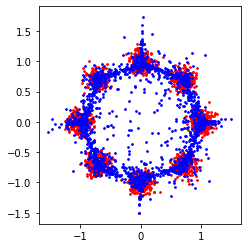

In [59]:
# k = 40, epoch 200
if __name__ == "__main__":
    print("Starting training....")
    train_40 = []
    log_40 = []
    
    for epoch in tqdm(range(1, args.epochs + 1)):
      #  train(epoch)
        a,b= train(epoch)
        train_40.append(a)
        log_40.append(b)
        
  
    print("train1", train_40, log_40)


    gt = next(train_loader)
        
    with torch.no_grad():
        #sample = torch.randn(2048, K).to(device)
        #out = model.decode(sample).cpu().numpy()
        out1 = model.sample()
        recon = model(gt)[0].cpu().numpy()

    rx,ry = recon[:,0], recon[:,1]
        
    gt = gt.cpu().numpy()
    gx, gy = gt[:,0], gt[:,1]
        
    xs, ys = out1[:,0], out1[:,1]

    plt.scatter(gx, gy, c = 'red', s=3)
    plt.scatter(xs, ys, c = 'blue', s=3)
    plt.axes().set_aspect('equal')
    plt.show()
    
#    st()

In [36]:
train_40 =[0.23360270172357558, 0.14653771676123142, 0.11167002663016319, 0.10078203476965428, 0.0992840463668108, 0.09783160157501697, 0.09659772224724293, 0.09559480085968972, 0.09460082061588765, 0.09362021312117577, 0.0927904163300991, 0.09179494321346283, 0.09011370174586773, 0.0884858513623476, 0.08685667559504509, 0.08587084367871284, 0.08508624494075775, 0.08461670123040677, 0.08438740499317646, 0.0841206331551075, 0.08395830668509006, 0.08377946496009826, 0.0836687034368515, 0.08343774192035198, 0.08355601444840431, 0.08338462561368942, 0.08324209414422512, 0.08314396671950817, 0.08327975243330002, 0.08316212713718414, 0.08315749801695346, 0.08311159037053585, 0.08298578388988971, 0.08297623455524444, 0.08271043263375759, 0.08249519303441048, 0.08262235879898071, 0.08254415638744832, 0.08281962029635906, 0.08251341141760349, 0.08257261455059052, 0.08263352170586585, 0.0826023881882429, 0.0826191970705986, 0.08259176321327687, 0.08250051811337471, 0.08262055426836014, 0.08246399581432343, 0.08251552529633045, 0.08238509707152844, 0.08258464261889457, 0.08233567230403423, 0.08244352266192437, 0.08242730282247067, 0.082423522695899, 0.08246477879583836, 0.0825162323564291, 0.0825778193026781, 0.0823946463316679, 0.08250135749578476, 0.08233102671802044, 0.0823932434618473, 0.08259330481290818, 0.08262329861521721, 0.08252011723816395, 0.08258242160081863, 0.08263342782855033, 0.08248480066657066, 0.08267959408462047, 0.08255090534687043, 0.08264477878808975, 0.08252317242324353, 0.08247315376996994, 0.08250687681138516, 0.08263487078249454, 0.0825695188343525, 0.08259601809084416, 0.08259070187807083, 0.08271176449954509, 0.08262884698808193, 0.0825332573056221, 0.08249931134283543, 0.08247834347188472, 0.08257784634828567, 0.08245885916054249, 0.08253314048051834, 0.08248397655785084, 0.08251955807209015, 0.08258113764226437, 0.08239057004451751, 0.08236506730318069, 0.08276682920753956, 0.08249785251915455, 0.08240842930972576, 0.08243985310196876, 0.08247467912733555, 0.08241182960569858, 0.08247515536844731, 0.08249179124832154, 0.08267932549118996, 0.08253159694373607, 0.08255526505410671, 0.08260088920593261, 0.08242910519242287, 0.08249961450695992, 0.08252906702458858, 0.08257396280765533, 0.0825444382429123, 0.08257128186523914, 0.08241278551518917, 0.08260659776628017, 0.08260518543422223, 0.08256553620100021, 0.08250076875090599, 0.08250464238226414, 0.08250739678740501, 0.08252533592283726, 0.08247805595397949, 0.08251207895576954, 0.08250125020742416, 0.08236167751252652, 0.08252102121710778, 0.0824330023676157, 0.08244450867176056, 0.08253871247172356, 0.08262129887938499, 0.0824440161883831, 0.08255209758877755, 0.0824733155965805, 0.08252606473863125, 0.08246628649532795, 0.08262882716953754, 0.08243433721363544, 0.08250608429312706, 0.08250808663666248, 0.08245884619653225, 0.08238656178116799, 0.08253503404557705, 0.08251183614134788, 0.08242901809513568, 0.08260477796196937, 0.08256443344056606, 0.08240585006773472, 0.08253415606915951, 0.0825321414321661, 0.08262543708086013, 0.08247068658471107, 0.08251731917262077, 0.08239893436431885, 0.0824915037304163, 0.08261148661375045, 0.08258964404463769, 0.08243630520999431, 0.08255138747394085, 0.08259547114372254, 0.08241873130202293, 0.08252887226641178, 0.08245720498263837, 0.08269577287137508, 0.08261366866528988, 0.08248598992824555, 0.08259168714284897, 0.08243216305971146, 0.08266595967113971, 0.08244455441832542, 0.08263716645538807, 0.0826325599104166, 0.08246682092547417, 0.082396130412817, 0.08254146426916123, 0.08251179076731205, 0.08256496265530586, 0.08264294438064099, 0.08248218126595021, 0.08248545490205288, 0.08239010110497474, 0.0824716629832983, 0.08248594664037227, 0.08255539447069168, 0.08260778039693832, 0.08245476730167865, 0.08243814870715141, 0.08246437601745128, 0.08267557561397552, 0.08263646766543388, 0.08248201392591, 0.08256484851241112, 0.08250755339860916, 0.08254158049821854, 0.08251019179821015, 0.08239743188023567, 0.08247849822044373, 0.08259485885500908, 0.08244095109403134, 0.08258071936666965, 0.08264989167451858, 0.08245569594204426, 0.08256972044706344, 0.08253470949828624, 0.08253194734454156] 

In [37]:
train_240=[0.08253159694373607, 0.08255526505410671, 0.08260088920593261, 0.08242910519242287, 0.08249961450695992, 0.08252906702458858, 0.08257396280765533, 0.0825444382429123, 0.08257128186523914, 0.08241278551518917, 0.08260659776628017, 0.08260518543422223, 0.08256553620100021, 0.08250076875090599, 0.08250464238226414, 0.08250739678740501, 0.08252533592283726, 0.08247805595397949, 0.08251207895576954, 0.08250125020742416, 0.08236167751252652, 0.08252102121710778, 0.0824330023676157, 0.08244450867176056, 0.08253871247172356, 0.08262129887938499, 0.0824440161883831, 0.08255209758877755, 0.0824733155965805, 0.08252606473863125, 0.08246628649532795, 0.08262882716953754, 0.08243433721363544, 0.08250608429312706, 0.08250808663666248, 0.08245884619653225, 0.08238656178116799, 0.08253503404557705, 0.08251183614134788, 0.08242901809513568, 0.08260477796196937, 0.08256443344056606, 0.08240585006773472, 0.08253415606915951, 0.0825321414321661, 0.08262543708086013, 0.08247068658471107, 0.08251731917262077, 0.08239893436431885, 0.0824915037304163, 0.08261148661375045, 0.08258964404463769, 0.08243630520999431, 0.08255138747394085, 0.08259547114372254, 0.08241873130202293, 0.08252887226641178, 0.08245720498263837, 0.08269577287137508, 0.08261366866528988, 0.08248598992824555, 0.08259168714284897, 0.08243216305971146, 0.08266595967113971, 0.08244455441832542, 0.08263716645538807, 0.0826325599104166, 0.08246682092547417, 0.082396130412817, 0.08254146426916123, 0.08251179076731205, 0.08256496265530586, 0.08264294438064099, 0.08248218126595021, 0.08248545490205288, 0.08239010110497474, 0.0824716629832983, 0.08248594664037227, 0.08255539447069168, 0.08260778039693832, 0.08245476730167865, 0.08243814870715141, 0.08246437601745128, 0.08267557561397552, 0.08263646766543388, 0.08248201392591, 0.08256484851241112, 0.08250755339860916, 0.08254158049821854, 0.08251019179821015, 0.08239743188023567, 0.08247849822044373, 0.08259485885500908, 0.08244095109403134, 0.08258071936666965, 0.08264989167451858, 0.08245569594204426, 0.08256972044706344, 0.08253470949828624, 0.08253194734454156]

In [38]:
train40=np.mean(train_240)

In [39]:
log_40 = [-4.192149071159955, -3.051478400999673, -2.891789306339758, -2.870216232530415, -2.7665894473821027, -2.6779869761240005, -2.501185465277104, -2.3866335278112407, -2.385639324250854, -2.2729579993854223, -2.178055560675867, -2.046444143992055, -1.897761333476907, -1.7451940137802575, -1.6452855425702024, -1.5523433589887707, -1.5214218719022081, -1.4578718743223695, -1.4450566618223253, -1.409985275040601, -1.38881550451726, -1.3715526710845425, -1.3617830187617468, -1.373671934823927, -1.3579504558173736, -1.353651772709461, -1.3516000350160184, -1.346667451929054, -1.3442044443498302, -1.3211829897575689, -1.3200855643741323, -1.330489626302959, -1.3366993932946554, -1.328945906479617, -1.3146483882530795, -1.3318129143850044, -1.3298863019664906, -1.3098483958558975, -1.306584155484627, -1.28377194350407, -1.3007036913826555, -1.2918993784089263, -1.3237155475252398, -1.3017185903479944, -1.2960989680398958, -1.3267262002518554, -1.3109764588650157, -1.2863203623886617, -1.2992228088001982, -1.2877355557817611, -1.3304178933917181, -1.2882132175826064, -1.3168441352027012, -1.2953114593911204, -1.289523186818184, -1.3055375654335557, -1.300272299745505, -1.3079411820685722, -1.3133086332390533, -1.3008847686518095, -1.276096092521967, -1.2876880085863485, -1.292127072274742, -1.3296894694039727, -1.3148905522435994, -1.326894376855102, -1.2987063232436915, -1.2989989106075246, -1.2893843133642129, -1.3173704163882411, -1.299458443875579, -1.3051448966444446, -1.29798220050893, -1.300469515815908, -1.3013643514849709, -1.3151705272645131, -1.2964994867580304, -1.337453958545868, -1.3050070543603969, -1.2859752191719567, -1.3192270096279906, -1.2850286444754557, -1.3068160316543158, -1.2901768795072053, -1.3081638214796585, -1.3129074215854903, -1.3002120562867197, -1.2935133411556925, -1.302898034263406, -1.293961146510719, -1.2844923032107176, -1.2886367590115118, -1.3180055041635126, -1.3101854789492229, -1.3185369997300707, -1.305261411323267, -1.3051383496876379, -1.287240916519114, -1.3068818284850636, -1.2954509304046646, -1.3075884122012913, -1.3008619671321504, -1.3060012726693513, -1.3075719075956898, -1.2883196000149963, -1.308479108047949, -1.3249731218381866, -1.2989552528718862, -1.3044032947079058, -1.3048350592146503, -1.2980165222372457, -1.3054581868002975, -1.2994146631439407, -1.297437148716365, -1.305039475288694, -1.2913277281077966, -1.2958872590158124, -1.2799835433632918, -1.3042476755841166, -1.3127995031750332, -1.3028968859251797, -1.315105765942806, -1.3074761962005694, -1.306076454141885, -1.2957746558481786, -1.2839410357311682, -1.3089596973210904, -1.2947962318229898, -1.2918306743684007, -1.3147720490868688, -1.3063538688833694, -1.2994184592412479, -1.2923783812051872, -1.3179201425749234, -1.316696225969752, -1.2989023314319315, -1.279051555925749, -1.3303013975975668, -1.3019948381234197, -1.300872077871492, -1.3077156865011714, -1.3057506784274955, -1.3069736384175488, -1.3073566995685075, -1.3093788766258823, -1.3085740807805109, -1.2933503749561936, -1.3114613556355126, -1.2956357093686648, -1.295042815531953, -1.284261082016752, -1.318699940152164, -1.3143574937130524, -1.3008718070195917, -1.3062908212224666, -1.3238968853848725, -1.2784457191871148, -1.3040715149437583, -1.3091111530796267, -1.3081792374649854, -1.3219994963234352, -1.2728223932431673, -1.3073694114162682, -1.2907514803003366, -1.3372341681632105, -1.3139125026902736, -1.2887664329850146, -1.3096002048808626, -1.297727341519942, -1.313031645185173, -1.2926848470859245, -1.2980467007934489, -1.302975293043369, -1.2814927010310009, -1.3159546227105525, -1.2851376615685763, -1.311644878706052, -1.286431488641251, -1.3087460201580194, -1.2844630552819942, -1.301271349614387, -1.270259140090031, -1.3189466550539157, -1.3034800192418001, -1.312499947503071, -1.2925678692712044, -1.3166861113685897, -1.3013479358956048, -1.2943802060031175, -1.2970295771324627, -1.304707700131419, -1.2995068881947311, -1.301569996641104, -1.3123512785760325, -1.3139509260380247, -1.2960471430133778, -1.3237272928947115, -1.2998427084222888, -1.2994681440078955, -1.2931959703104003]

In [40]:
log_240 = [-1.3075884122012913, -1.3008619671321504, -1.3060012726693513, -1.3075719075956898, -1.2883196000149963, -1.308479108047949, -1.3249731218381866, -1.2989552528718862, -1.3044032947079058, -1.3048350592146503, -1.2980165222372457, -1.3054581868002975, -1.2994146631439407, -1.297437148716365, -1.305039475288694, -1.2913277281077966, -1.2958872590158124, -1.2799835433632918, -1.3042476755841166, -1.3127995031750332, -1.3028968859251797, -1.315105765942806, -1.3074761962005694, -1.306076454141885, -1.2957746558481786, -1.2839410357311682, -1.3089596973210904, -1.2947962318229898, -1.2918306743684007, -1.3147720490868688, -1.3063538688833694, -1.2994184592412479, -1.2923783812051872, -1.3179201425749234, -1.316696225969752, -1.2989023314319315, -1.279051555925749, -1.3303013975975668, -1.3019948381234197, -1.300872077871492, -1.3077156865011714, -1.3057506784274955, -1.3069736384175488, -1.3073566995685075, -1.3093788766258823, -1.3085740807805109, -1.2933503749561936, -1.3114613556355126, -1.2956357093686648, -1.295042815531953, -1.284261082016752, -1.318699940152164, -1.3143574937130524, -1.3008718070195917, -1.3062908212224666, -1.3238968853848725, -1.2784457191871148, -1.3040715149437583, -1.3091111530796267, -1.3081792374649854, -1.3219994963234352, -1.2728223932431673, -1.3073694114162682, -1.2907514803003366, -1.3372341681632105, -1.3139125026902736, -1.2887664329850146, -1.3096002048808626, -1.297727341519942, -1.313031645185173, -1.2926848470859245, -1.2980467007934489, -1.302975293043369, -1.2814927010310009, -1.3159546227105525, -1.2851376615685763, -1.311644878706052, -1.286431488641251, -1.3087460201580194, -1.2844630552819942, -1.301271349614387, -1.270259140090031, -1.3189466550539157, -1.3034800192418001, -1.312499947503071, -1.2925678692712044, -1.3166861113685897, -1.3013479358956048, -1.2943802060031175, -1.2970295771324627, -1.304707700131419, -1.2995068881947311, -1.301569996641104, -1.3123512785760325, -1.3139509260380247, -1.2960471430133778, -1.3237272928947115, -1.2998427084222888, -1.2994681440078955, -1.2931959703104003]

In [41]:
log40=np.mean(log_240)

In [42]:
trainal = [train5,train10,train20,train30,train40]

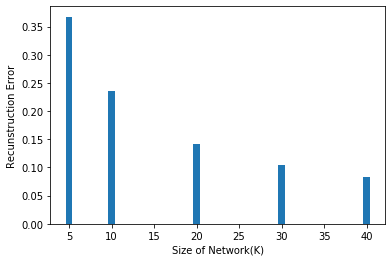

In [44]:
k = [5, 10, 20, 30, 40] 
plt.bar(k, trainal) 
plt.xlabel('Size of Network(K)', fontsize = 10) 
plt.ylabel('Recunstruction Error', fontsize = 10) 
plt.show()

In [43]:
logal = [log5,log10,log20,log30,log40]

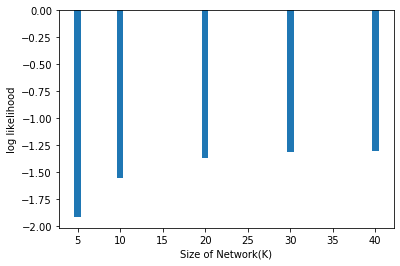

In [47]:
k = [5, 10, 20, 30, 40] 
plt.bar(k, logal) 
plt.xlabel('Size of Network(K)', fontsize = 10) 
plt.ylabel('log likelihood', fontsize = 10) 
plt.show()

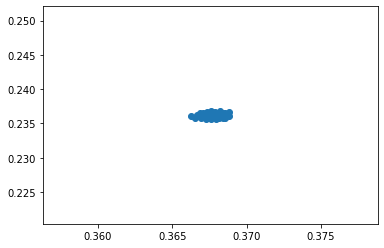

In [48]:
plt.scatter(train_25, train_210, cmap =plt.cm.winter) 
plt.show() 

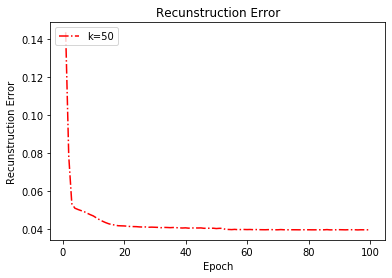

In [55]:
x = np.array(list(range(1, 101)))

plt.title('Recunstruction Error')
plt.xlabel('Epoch')
plt.ylabel('Recunstruction Error')
plt.plot(x, train_100, color = "red", linewidth = 1.5, linestyle = "-.", label = "k=50")
plt.legend(loc = "upper left")
plt.show()

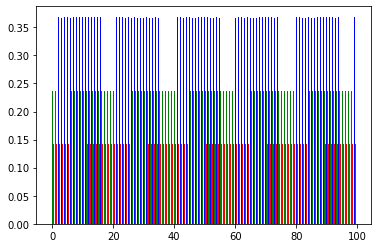

In [87]:
X = np.arange(100)
plt.bar(X + 0.00, df1[0], color = 'b', width = 0.25)
plt.bar(X + 0.25, df1[1], color = 'g', width = 0.25)
plt.bar(X + 0.50, df1[2], color = 'r', width = 0.25)

plt.show()

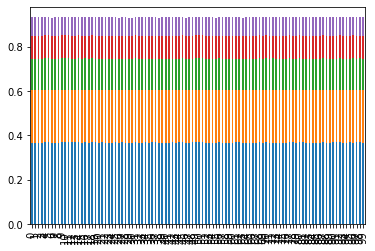

In [92]:
df[["a", "b", "c","d","e"]].plot(
    kind="bar", stacked=True, legend=False
)

In [67]:
plotdata = pd.DataFrame(df1, index=["K5", "K10", "K20", "K30", "K40"])
plotdata.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
K5,0.366641,0.367267,0.367439,0.367322,0.367885,0.368041,0.366983,0.367644,0.367469,0.368048,...,0.367724,0.367827,0.368220,0.367139,0.367593,0.367944,0.367638,0.367709,0.368070,0.367589
K10,0.236192,0.236549,0.236329,0.236211,0.236558,0.236312,0.236091,0.236038,0.235808,0.236420,...,0.236034,0.236183,0.236761,0.236226,0.235856,0.235687,0.236640,0.236246,0.236188,0.235613
K20,0.142428,0.142121,0.142400,0.142018,0.142097,0.142191,0.142043,0.142143,0.142248,0.142312,...,0.142137,0.142250,0.142199,0.142377,0.142456,0.142163,0.142246,0.142092,0.142100,0.142213
K30,0.103661,0.103590,0.103517,0.103688,0.103665,0.103760,0.103498,0.103592,0.103737,0.103599,...,0.103870,0.103548,0.103527,0.103773,0.103507,0.103694,0.103604,0.103618,0.103571,0.103559
K40,0.082532,0.082555,0.082601,0.082429,0.082500,0.082529,0.082574,0.082544,0.082571,0.082413,...,0.082397,0.082478,0.082595,0.082441,0.082581,0.082650,0.082456,0.082570,0.082535,0.082532


In [68]:
plotdata = plotdata.T

Text(0, 0.5, 'Error')

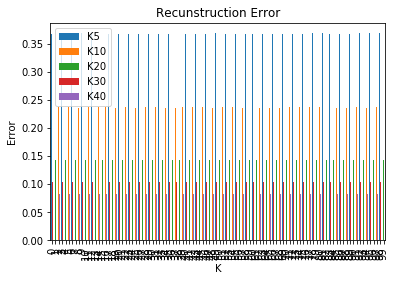

In [69]:
plotdata.reset_index().plot(
    x="index", y=["K5", "K10","K20","K30","K40"], kind="bar"
)
plt.title("Recunstruction Error")
plt.xlabel("K")
plt.ylabel("Error")

In [91]:
df.head()

,a,b,c,d,e
0,0.366641,0.236192,0.142428,0.103661,0.082532
1,0.367267,0.236549,0.142121,0.103590,0.082555
2,0.367439,0.236329,0.142400,0.103517,0.082601
3,0.367322,0.236211,0.142018,0.103688,0.082429
4,0.367885,0.236558,0.142097,0.103665,0.082500


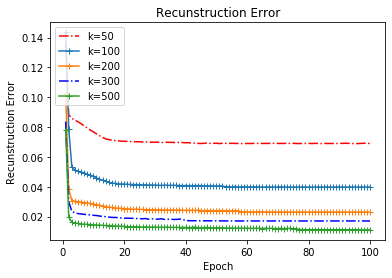

In [57]:
x = np.array(list(range(1, 101)))

plt.title('Recunstruction Error')
plt.xlabel('Epoch')
plt.ylabel('Recunstruction Error')
plt.plot(x, train50, color = "red", linewidth = 1.5, linestyle = "-.", label = "k=50")
plt.plot(x, train_100, marker = '+', linestyle = '-', label = 'k=100')
plt.plot(x, train_200, marker = '+', linestyle = '-', label = 'k=200')
plt.plot(x, train_300, color = "blue", linewidth = 1.5, linestyle = "-.", label = "k=300")
plt.plot(x, train_500,  marker = '+', linestyle = '-', label = 'k=500')
plt.legend(loc = "upper left")
plt.show()

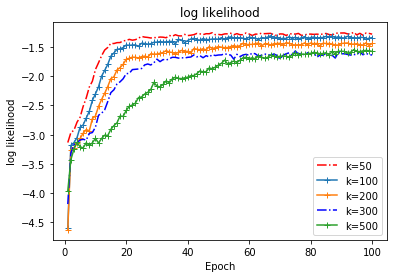

In [72]:
x = np.array(list(range(1, 101)))

plt.title('log likelihood')
plt.xlabel('Epoch')
plt.ylabel('log likelihood')
plt.plot(x, log50, color = "red", linewidth = 1.5, linestyle = "-.", label = "k=50")
plt.plot(x, log_100, marker = '+', linestyle = '-', label = 'k=100')
plt.plot(x, log_200, marker = '+', linestyle = '-', label = 'k=200')
plt.plot(x, log_300, color = "blue", linewidth = 1.5, linestyle = "-.", label = "k=300")
plt.plot(x, log_500,  marker = '+', linestyle = '-', label = 'k=500')
plt.legend(loc = "lower right")
plt.show()

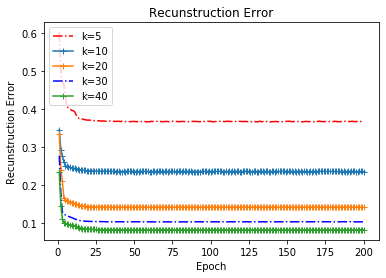

In [44]:
x = np.array(list(range(1, 201)))

plt.title('Recunstruction Error')
plt.xlabel('Epoch')
plt.ylabel('Recunstruction Error')
plt.plot(x, train_5, color = "red", linewidth = 1.5, linestyle = "-.", label = "k=5")
plt.plot(x, train_10, marker = '+', linestyle = '-', label = 'k=10')
plt.plot(x, train_20, marker = '+', linestyle = '-', label = 'k=20')
plt.plot(x, train_30, color = "blue", linewidth = 1.5, linestyle = "-.", label = "k=30")
plt.plot(x, train_40,  marker = '+', linestyle = '-', label = 'k=40')
plt.legend(loc = "upper left")
plt.show()

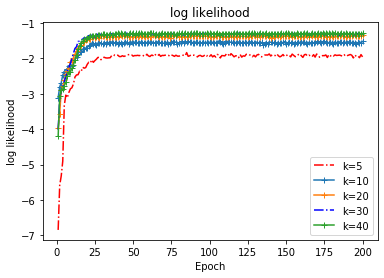

In [22]:
x = np.array(list(range(1, 201)))

plt.title('log likelihood')
plt.xlabel('Epoch')
plt.ylabel('log likelihood')
plt.plot(x, log_5, color = "red", linewidth = 1.5, linestyle = "-.", label = "k=5")
plt.plot(x, log_10, marker = '+', linestyle = '-', label = 'k=10')
plt.plot(x, log_20, marker = '+', linestyle = '-', label = 'k=20')
plt.plot(x, log_30, color = "blue", linewidth = 1.5, linestyle = "-.", label = "k=30")
plt.plot(x, log_40,  marker = '+', linestyle = '-', label = 'k=40')
plt.legend(loc = "lower right")
plt.show()

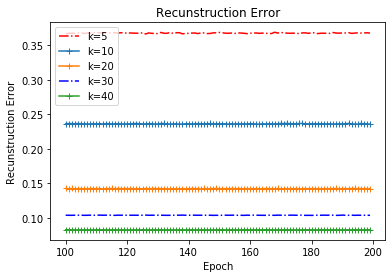

In [32]:
# Epoch higher than 100
x = np.array(list(range(100, 200)))

plt.title('Recunstruction Error')
plt.xlabel('Epoch')
plt.ylabel('Recunstruction Error')
plt.plot(x, train_25, color = "red", linewidth = 1.5, linestyle = "-.", label = "k=5")
plt.plot(x, train_210, marker = '+', linestyle = '-', label = 'k=10')
plt.plot(x, train_220, marker = '+', linestyle = '-', label = 'k=20')
plt.plot(x, train_230, color = "blue", linewidth = 1.5, linestyle = "-.", label = "k=30")
plt.plot(x, train_240,  marker = '+', linestyle = '-', label = 'k=40')
plt.legend(loc = "upper left")
plt.show()

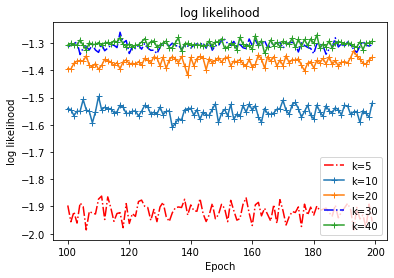

In [33]:
# Epoch Higher than 100
x = np.array(list(range(100, 200)))

plt.title('log likelihood')
plt.xlabel('Epoch')
plt.ylabel('log likelihood')
plt.plot(x, log_25, color = "red", linewidth = 1.5, linestyle = "-.", label = "k=5")
plt.plot(x, log_210, marker = '+', linestyle = '-', label = 'k=10')
plt.plot(x, log_220, marker = '+', linestyle = '-', label = 'k=20')
plt.plot(x, log_230, color = "blue", linewidth = 1.5, linestyle = "-.", label = "k=30")
plt.plot(x, log_240,  marker = '+', linestyle = '-', label = 'k=40')
plt.legend(loc = "lower right")
plt.show()

In [46]:
from chart_studio import plotly
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [142]:

import plotly.figure_factory as ff
figure = ff.create_scatterplotmatrix(
    df[['a', 'b', 'c',      
        'd','e']],
    diag='histogram',
    index='e')

In [144]:

# Train loss
df2 = df[['a','b','c','d','e']]
         
        
df2.iplot(kind='bar', xTitle='K', yTitle='Recunstraction error',
    title='train loss')

In [48]:
import pandas as pd 
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [49]:
df1 = np.array([train_25,train_210,train_220,train_230,train_240])

In [66]:
df1

array([[0.36664091, 0.36726702, 0.36743877, 0.36732192, 0.36788458,
        0.3680409 , 0.36698321, 0.36764398, 0.36746929, 0.36804816,
        0.36833236, 0.36793514, 0.36786929, 0.36771195, 0.36842059,
        0.36758952, 0.36819846, 0.36758802, 0.36813611, 0.36790827,
        0.367444  , 0.36779481, 0.36753906, 0.36744725, 0.36731089,
        0.36810117, 0.36627326, 0.36782348, 0.36723968, 0.36691139,
        0.36688261, 0.36855414, 0.3672962 , 0.36733446, 0.36856517,
        0.36708077, 0.36815339, 0.36810608, 0.36653166, 0.36716364,
        0.36719495, 0.36760203, 0.36775216, 0.36689525, 0.36780554,
        0.36785799, 0.36690978, 0.36705681, 0.3679355 , 0.36803019,
        0.36851616, 0.3680268 , 0.36741194, 0.36735504, 0.36764055,
        0.36706015, 0.36793817, 0.36761273, 0.36733244, 0.36675978,
        0.3673915 , 0.36773361, 0.36773623, 0.3672398 , 0.36758453,
        0.36740747, 0.36679439, 0.36700177, 0.36881882, 0.36759198,
        0.36877574, 0.3675634 , 0.36757607, 0.36

In [54]:
df.columns = ['a','b','c','d','e']

In [51]:
X = np.array([5,10,20,30,40])

In [78]:
df["a"]

0     0.366641
1     0.367267
2     0.367439
3     0.367322
4     0.367885
        ...   
95    0.367944
96    0.367638
97    0.367709
98    0.368070
99    0.367589
Name: a, Length: 100, dtype: float64

In [52]:
df = pd.DataFrame(df1)

In [53]:
df = df.T

In [55]:
from sklearn.decomposition import PCA

In [59]:
pca = PCA(n_components=5)
reduced_data = pca.fit_transform(df)

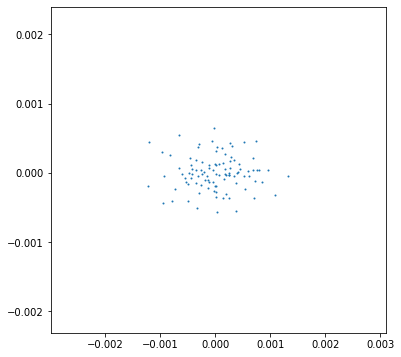

In [66]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(reduced_data[:,0], reduced_data[:,1], s=1);